## Code to generate behavioral decoding analysis plots (Fig. 1d, ED Fig. 1h, 9b-c)

In [12]:
# imports 
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, StratifiedKFold, KFold, cross_val_score, cross_validate, \
    cross_val_predict, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline
from scipy import stats
import pandas as pd
import hashlib
import pickle
import os
import time
import multiprocessing as mp
from itertools import repeat
from datetime import date
import sys
sys.path.append('../neural_analysis')
from analysisUtils import *
from neuralUtils import *
from analysis_by_class import *
from streams import DataStream
sys.path.append('../utils')
from db import get_db_info, create_connection, select_db, execute_sql
from plotting import plot_avgs, add_cbar, plot_confusion, plot_box, get_mouse_colors
from paths import parse_data_path
from matio import loadmat
from protocols import load_params

In [13]:
plt.style.use('paper_export')

In [39]:
protocol = 'SameRewDist'

# Fog Fig. 1d
class_name = 'helper'
class_labels = ['all']

# For ED Fig. 9b-c
# class_name = 'lesion'
# class_labels = ['control', 'lesioned']
# class_colors = ['#005363', '#FF69B4']

In [41]:
colors, protocol_info, periods, kwargs = load_params(protocol)
paths = get_db_info()

exclude_tt = protocol_info['exclude_tt']
n_trace_types = protocol_info['n_trace_types']
phase = 3  # expert phase of training; can be ignored

sql = 'SELECT * FROM session WHERE has_ephys=1 AND has_facemap=1 AND significance=1 AND protocol=' + \
    '"{}" AND phase>={} ORDER BY mid ASC, exp_date ASC'.format(protocol, phase)
rets = execute_sql(sql, paths['db'])
rng = np.random.default_rng()

In [16]:
df = pd.DataFrame(rets, columns=rets[0].keys())

mouse_rets = select_db(paths['db'], 'mouse', '*', 'name IN {}'.format(tuple(np.unique(df['name']))), (), unique=False)
mouse_df = pd.DataFrame(mouse_rets, columns=mouse_rets[0].keys()).sort_values('name')

if class_name == 'lesion':
    df[class_name] = 'control'
    for mouse_name in np.unique(df['name']):
        if '6-OHDA' in mouse_df.loc[mouse_df['name'] == mouse_name, 'surgery1'].values[0]:
            df.loc[df['name'] == mouse_name, class_name] = 'lesioned'
else:
    df[class_name] = class_labels[0]
df

repo  mid  name  sid  rid  \
0    Adam   79  AL39   23    1   
1    Adam   79  AL39   24    1   
2    Adam   79  AL39   25    1   
3    Adam   79  AL39   26    1   
4    Adam   79  AL39   27    1   
..    ...  ...   ...  ...  ...   
99   Adam  123  AL83   30    1   
100  Adam  123  AL83   31    1   
101  Adam  123  AL83   32    1   
102  Adam  123  AL83   33    1   
103  Adam  123  AL83   34    1   

                                         raw_data_path  \
0    /n/holystore01/LABS/uchida_users/Users/alowet/...   
1    /n/holystore01/LABS/uchida_users/Users/alowet/...   
2    /n/holystore01/LABS/uchida_users/Users/alowet/...   
3    /n/holystore01/LABS/uchida_users/Users/alowet/...   
4    /n/holystore01/LABS/uchida_users/Users/alowet/...   
..                                                 ...   
99   /n/holystore01/LABS/uchida_users/Users/alowet/...   
100  /n/holystore01/LABS/uchida_users/Users/alowet/...   
101  /n/holystore01/LABS/uchida_users/Users/alowet/...   
102  /n/holystore01/LABS/uchida_users/Users/alowet/...   
103  /n/holystore01/LABS/uchida_users/Users/alowet/...   

                                           figure_path  phase  quality  \
0    /n/holystore01/LABS/uchida_users/Users/alowet/...      3        3   
1    /n/holystore01/LABS/uchida_users/Users/alowet/...      3        3   
2    /n/holystore01/LABS/uchida_users/Users/alowet/...      3        3   
3    /n/holystore01/LABS/uchida_users/Users/alowet/...      3        3   
4    /n/holystore01/LABS/uchida_users/Users/alowet/...      3        3   
..                                                 ...    ...      ...   
99   /n/holystore01/LABS/uchida_users/Users/alowet/...      3        3   
100  /n/holystore01/LABS/uchida_users/Users/alowet/...      3        3   
101  /n/holystore01/LABS/uchida_users/Users/alowet/...      3        3   
102  /n/holystore01/LABS/uchida_users/Users/alowet/...      3        3   
103  /n/holystore01/LABS/uchida_users/Users/alowet/...      3        3   

     exp_date  ...  probe1_dye probe2_AP  probe2_ML probe2_DV probe2_angle  \
0    20210930  ...         DiD      None       None      None         None   
1    20211001  ...         DiD      None       None      None         None   
2    20211002  ...        None      None       None      None         None   
3    20211003  ...        None      None       None      None         None   
4    20211004  ...         DiI      None       None      None         None   
..        ...  ...         ...       ...        ...       ...          ...   
99   20220911  ...        None      None       None      None         None   
100  20220912  ...         DiI      None       None      None         None   
101  20220913  ...         DiO      None       None      None         None   
102  20220914  ...        None      None       None      None         None   
103  20220915  ...        None      None       None      None         None   

     probe2_dye has_facemap  exclude  has_opto  helper  
0          None           1        0         0     all  
1          None           1        0         0     all  
2          None           1        0         0     all  
3          None           1        0         0     all  
4          None           1        0         0     all  
..          ...         ...      ...       ...     ...  
99         None           1        0         0     all  
100        None           1        0         0     all  
101        None           1        0         0     all  
102        None           1        0         0     all  
103        None           1        0         0     all  

[104 rows x 42 columns]

In [28]:
# max_n_trials_per_type = 90
# n_trace_types = protocol_info['n_trace_types']
# n_prp = periods['n_prerew_periods']

# n_time_bins=24
# per_bounds = [(-1, 0), (0, 1), (1, 2), (2, 3)]

# time_bins = np.linspace(-1, 5, n_time_bins + 1)
# bin_width = np.mean(np.diff(time_bins))
# time_bin_centers = time_bins[:-1] + bin_width / 2
# n_jobs = 1  # can't use multiprocessing in nested fashion, and since this is parallel, just use 1 job here


# hash rets consistently from machine to machine
dhash = hashlib.md5()
encoded = json.dumps(sql, sort_keys=True).encode()
dhash.update(encoded)
hashed = dhash.hexdigest()

ddict_name = os.path.join(paths['behavior_fig_roots'][1], '{}_facemap_decoding_{}_{}.p'.format(protocol, len(df), hashed))

mouse_colors = get_mouse_colors(protocol)

In [29]:
if os.path.exists(ddict_name):
    print('Found saved vars at {}'.format(ddict_name))
    with open(ddict_name, 'rb') as f:
        ddict = pickle.load(f)
    # bring loaded variables into namespace
    for var in ddict.keys():
        exec("{} = ddict['{}']".format(var, var))

else:
    raise Exception('Could not find vars at {}. Ensure this file has been copied into the correct folder'.format(ddict_name))

Found saved vars at ../../data/behavior-plots/SameRewDist_facemap_decoding_104_9853e89f4e8252dc9d707f95c8909d05.p


In [30]:
beh_info = pd.DataFrame(beh_info)
if class_name == 'helper':
    beh_info[class_name] = 'all'
beh_info['str_regions'] = 'behavior'

concat_bin_resps = np.transpose(bin_resps, (1,0,2,3)).reshape(beh_resps.shape[1], -1)
concat_means = np.nanmean(concat_bin_resps, axis=1).reshape(1, -1, 1)
concat_stds = np.nanstd(concat_bin_resps, axis=1).reshape(1, -1, 1)

X_means = np.nanmean(beh_resps, axis=2)
X_means_norm = (X_means - concat_means) / concat_stds
beh_resps_norm = (beh_resps - concat_means[..., np.newaxis]) / concat_stds[..., np.newaxis]

mice = np.unique(beh_info['names'])

In [31]:
rois = ['behavior']
n_splits = 6

pers_base = [1, 2, 3]
train_pers = np.repeat(pers_base, len(pers_base))
test_pers = np.tile(pers_base, len(pers_base))
per_keys = ['_'.join([str(train_per), str(test_per)]) for train_per, test_per in zip(train_pers, test_pers)]
reg_C = 5e-3

n_time_bins=24
time_bins = np.linspace(-1, 5, n_time_bins + 1)
bin_width = np.mean(np.diff(time_bins))
time_bin_centers = time_bins[:-1] + bin_width / 2

dec_path = os.path.join(paths['behavior_fig_roots'][1], '_'.join([protocol, 'dec_dict', 'facemap', class_name, str(n_splits), str(reg_C) + '.p']))

if os.path.exists(dec_path):
    print('Found dec_path at {}'.format(dec_path))
    with open(dec_path, 'rb') as f:
        dec_dict = pickle.load(f)
else:

    dec_dict = dec_dict_setup(beh_resps, bin_resps, time_bin_centers, protocol_info, kwargs, train_pers=train_pers, test_pers=test_pers, rewards=rewards)
    dec_dict = pseudo_decode_by_class(class_name, class_labels, dec_dict, beh_info, rois, n_splits=n_splits, 
                                      by_mouse=True, match_across_class=False, kern='linear', do_zscore=True, reg_C=reg_C)
    dec_dict = simul_decode_by_class(class_name, class_labels, dec_dict, beh_info, rois, min_size=1,
                                     kern='linear', do_zscore=True, reg_C=reg_C)
    with open(dec_path, 'wb') as f:
        pickle.dump(dec_dict, f)

Found dec_path at ../../data/behavior-plots/SameRewDist_dec_dict_facemap_helper_6_0.005.p


In [32]:
dec_dict = make_dfs(class_name, class_labels, dec_dict, rois, by_mouse=True, pseudo=True)
dec_dict = make_dfs(class_name, class_labels, dec_dict, rois, by_mouse=True, pseudo=False)

for per_key in per_keys:
#     dec_dict = run_stats(class_name, class_labels, rois, dec_dict, per_key, by_mouse=False)
    dec_dict = run_stats(class_name, class_labels, rois, dec_dict, per_key, by_mouse=True)

ccgp
pair
cong
mean
odor
var
ccgp
pair
cong
mean
odor
var
ccgp
pair
cong
mean
odor
var
ccgp
disagg
pool
pair
disagg
AL39
Accuracy ~ C(grouping)
AL40
Accuracy ~ C(grouping)
AL41
Accuracy ~ C(grouping)
AL47
Accuracy ~ C(grouping)
AL49
Accuracy ~ C(grouping)
AL54
Accuracy ~ C(grouping)
AL55
Accuracy ~ C(grouping)
AL77
Accuracy ~ C(grouping)
AL79
Accuracy ~ C(grouping)
AL81
Accuracy ~ C(grouping)
AL82
Accuracy ~ C(grouping)
AL83
Accuracy ~ C(grouping)
pool
AL39
Accuracy ~ C(grouping)
AL40
Accuracy ~ C(grouping)
AL41
Accuracy ~ C(grouping)
AL47
Accuracy ~ C(grouping)
AL49
Accuracy ~ C(grouping)
AL54
Accuracy ~ C(grouping)
AL55
Accuracy ~ C(grouping)
AL77
Accuracy ~ C(grouping)
AL79
Accuracy ~ C(grouping)
AL81
Accuracy ~ C(grouping)
AL82
Accuracy ~ C(grouping)
AL83
Accuracy ~ C(grouping)
cong
disagg
AL39
Accuracy ~ C(grouping)
AL40
Accuracy ~ C(grouping)
AL41
Accuracy ~ C(grouping)
AL47
Accuracy ~ C(grouping)
AL49
Accuracy ~ C(grouping)
AL54
Accuracy ~ C(grouping)
AL55
Accuracy ~ C(grouping)

/n/holystore01/LABS/uchida_users/Users/alowet/envs/neural/lib/python3.8/site-packages/statsmodels/base/model.py:1888: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 2, but rank is 1
  warnings.warn('covariance of constraints does not have full '


AL40
Accuracy ~ C(grouping)
AL41
Accuracy ~ C(grouping)
AL47
Accuracy ~ C(grouping)
AL49
Accuracy ~ C(grouping)
AL54
Accuracy ~ C(grouping)
AL55
Accuracy ~ C(grouping)
AL77
Accuracy ~ C(grouping)
AL79
Accuracy ~ C(grouping)
AL81
Accuracy ~ C(grouping)
AL82
Accuracy ~ C(grouping)
AL83
Accuracy ~ C(grouping)
odor
disagg
pool
var
disagg
pool
ccgp
disagg
pool
pair
disagg
AL39
Accuracy ~ C(grouping)
AL40
Accuracy ~ C(grouping)
AL41
Accuracy ~ C(grouping)
AL47
Accuracy ~ C(grouping)
AL49
Accuracy ~ C(grouping)
AL54
Accuracy ~ C(grouping)
AL55
Accuracy ~ C(grouping)
AL77
Accuracy ~ C(grouping)
AL79
Accuracy ~ C(grouping)
AL81
Accuracy ~ C(grouping)
AL82
Accuracy ~ C(grouping)
AL83
Accuracy ~ C(grouping)
pool
AL39
Accuracy ~ C(grouping)
AL40
Accuracy ~ C(grouping)
AL41
Accuracy ~ C(grouping)
AL47
Accuracy ~ C(grouping)
AL49
Accuracy ~ C(grouping)
AL54
Accuracy ~ C(grouping)
AL55
Accuracy ~ C(grouping)
AL77
Accuracy ~ C(grouping)
AL79
Accuracy ~ C(grouping)
AL81
Accuracy ~ C(grouping)
AL82
Accu

/n/holystore01/LABS/uchida_users/Users/alowet/envs/neural/lib/python3.8/site-packages/statsmodels/base/model.py:1888: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 2, but rank is 1
  warnings.warn('covariance of constraints does not have full '


Accuracy ~ C(grouping)
AL47
Accuracy ~ C(grouping)
AL49
Accuracy ~ C(grouping)
AL54
Accuracy ~ C(grouping)
AL55
Accuracy ~ C(grouping)
AL77
Accuracy ~ C(grouping)
AL79
Accuracy ~ C(grouping)
AL81
Accuracy ~ C(grouping)
AL82
Accuracy ~ C(grouping)
AL83
Accuracy ~ C(grouping)
odor
disagg
pool
var
disagg
pool
ccgp
disagg
pool
pair
disagg
AL39
Accuracy ~ C(grouping)
AL40
Accuracy ~ C(grouping)
AL41
Accuracy ~ C(grouping)
AL47
Accuracy ~ C(grouping)
AL49
Accuracy ~ C(grouping)
AL54
Accuracy ~ C(grouping)
AL55
Accuracy ~ C(grouping)
AL77
Accuracy ~ C(grouping)
AL79
Accuracy ~ C(grouping)
AL81
Accuracy ~ C(grouping)
AL82
Accuracy ~ C(grouping)
AL83
Accuracy ~ C(grouping)
pool
AL39
Accuracy ~ C(grouping)
AL40
Accuracy ~ C(grouping)
AL41
Accuracy ~ C(grouping)
AL47
Accuracy ~ C(grouping)
AL49
Accuracy ~ C(grouping)
AL54
Accuracy ~ C(grouping)
AL55
Accuracy ~ C(grouping)
AL77
Accuracy ~ C(grouping)
AL79
Accuracy ~ C(grouping)
AL81
Accuracy ~ C(grouping)
AL82
Accuracy ~ C(grouping)
AL83
Accuracy 

/n/holystore01/LABS/uchida_users/Users/alowet/envs/neural/lib/python3.8/site-packages/statsmodels/base/model.py:1888: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 2, but rank is 1
  warnings.warn('covariance of constraints does not have full '
/n/holystore01/LABS/uchida_users/Users/alowet/envs/neural/lib/python3.8/site-packages/statsmodels/base/model.py:1888: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 2, but rank is 1
  warnings.warn('covariance of constraints does not have full '


Accuracy ~ C(grouping)
AL49
Accuracy ~ C(grouping)
AL54
Accuracy ~ C(grouping)
AL55
Accuracy ~ C(grouping)
AL77
Accuracy ~ C(grouping)
AL79
Accuracy ~ C(grouping)
AL81
Accuracy ~ C(grouping)
AL82
Accuracy ~ C(grouping)
AL83
Accuracy ~ C(grouping)
pool
AL39
Accuracy ~ C(grouping)
AL40
Accuracy ~ C(grouping)
AL41
Accuracy ~ C(grouping)
AL47
Accuracy ~ C(grouping)
AL49
Accuracy ~ C(grouping)
AL54
Accuracy ~ C(grouping)
AL55
Accuracy ~ C(grouping)
AL77
Accuracy ~ C(grouping)
AL79
Accuracy ~ C(grouping)
AL81
Accuracy ~ C(grouping)
AL82
Accuracy ~ C(grouping)
AL83
Accuracy ~ C(grouping)
odor
disagg
pool
var
disagg
pool


ccgp
ccgp [['#244b05', '#7cd411', '#4a9d05', '#2c6805'], ['#74B72E']] [['Distribution CCGP 1', 'Distribution CCGP 2', 'Distribution CCGP 3', 'Distribution CCGP 4'], ['ccgp']]
1_1
['ccgp']
Subregion ['behavior'] grouping ['ccgp'] helper ['all']
['ccgp']
0 0 1 1
Accuracy ~ 1
                Mixed Linear Model Regression Results
Model:                  MixedLM      Dependent Variable:      Accuracy
No. Observations:       60           Method:                  REML    
No. Groups:             12           Scale:                   0.0004  
Min. group size:        5            Log-Likelihood:          126.6484
Max. group size:        5            Converged:               Yes     
Mean group size:        5.0                                           
----------------------------------------------------------------------
            Coef.    Std.Err.     z       P>|z|     [0.025     0.975] 
----------------------------------------------------------------------
Intercept 7.313e-03 1.075e-02 6.8

../neural_analysis/analysis_by_class.py:3031: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg_df = stat_df.groupby(['mouse', 'Subregion', class_name, 'grouping']).mean().reset_index()
../neural_analysis/analysis_by_class.py:3053: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  roi_mean = diff_df[diff_df['Subregion'] == roi].groupby(class_name).mean().sort_values(
meta NOT subset; don't know how to subset; dropped


1_2
['ccgp']
Subregion ['behavior'] grouping ['ccgp'] helper ['all']
['ccgp']
0 0 1 1
Accuracy ~ 1
                Mixed Linear Model Regression Results
Model:                  MixedLM      Dependent Variable:      Accuracy
No. Observations:       60           Method:                  REML    
No. Groups:             12           Scale:                   0.0006  
Min. group size:        5            Log-Likelihood:          130.0682
Max. group size:        5            Converged:               Yes     
Mean group size:        5.0                                           
----------------------------------------------------------------------
            Coef.    Std.Err.     z       P>|z|     [0.025     0.975] 
----------------------------------------------------------------------
Intercept 4.073e-03 4.575e-03 8.903e-01 3.733e-01 -4.894e-03 1.304e-02
mouse Var 1.363e-04 4.954e-03                                         

[0] [0.3733]


../neural_analysis/analysis_by_class.py:3031: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg_df = stat_df.groupby(['mouse', 'Subregion', class_name, 'grouping']).mean().reset_index()
../neural_analysis/analysis_by_class.py:3053: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  roi_mean = diff_df[diff_df['Subregion'] == roi].groupby(class_name).mean().sort_values(
meta NOT subset; don't know how to subset; dropped


1_3
['ccgp']
Subregion ['behavior'] grouping ['ccgp'] helper ['all']
['ccgp']
0 0 1 1
Accuracy ~ 1
                Mixed Linear Model Regression Results
Model:                 MixedLM      Dependent Variable:      Accuracy
No. Observations:      60           Method:                  REML    
No. Groups:            12           Scale:                   0.0005  
Min. group size:       5            Log-Likelihood:          137.2758
Max. group size:       5            Converged:               Yes     
Mean group size:       5.0                                           
---------------------------------------------------------------------
            Coef.    Std.Err.     z       P>|z|     [0.025    0.975] 
---------------------------------------------------------------------
Intercept 5.969e-03 2.945e-03 2.026e+00 4.272e-02 1.959e-04 1.174e-02
mouse Var 5.297e-14 3.957e-03                                        

[0] [0.04272]


../neural_analysis/analysis_by_class.py:3031: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg_df = stat_df.groupby(['mouse', 'Subregion', class_name, 'grouping']).mean().reset_index()
../neural_analysis/analysis_by_class.py:3053: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  roi_mean = diff_df[diff_df['Subregion'] == roi].groupby(class_name).mean().sort_values(
meta NOT subset; don't know how to subset; dropped


2_1
['ccgp']
Subregion ['behavior'] grouping ['ccgp'] helper ['all']
['ccgp']
0 0 1 1
Accuracy ~ 1
                Mixed Linear Model Regression Results
Model:                  MixedLM      Dependent Variable:      Accuracy
No. Observations:       60           Method:                  REML    
No. Groups:             12           Scale:                   0.0005  
Min. group size:        5            Log-Likelihood:          135.1864
Max. group size:        5            Converged:               Yes     
Mean group size:        5.0                                           
----------------------------------------------------------------------
            Coef.    Std.Err.     z       P>|z|     [0.025     0.975] 
----------------------------------------------------------------------
Intercept 3.875e-03 4.409e-03 8.789e-01 3.794e-01 -4.766e-03 1.252e-02
mouse Var 1.388e-04 5.075e-03                                         

[0] [0.3794]


../neural_analysis/analysis_by_class.py:3031: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg_df = stat_df.groupby(['mouse', 'Subregion', class_name, 'grouping']).mean().reset_index()
../neural_analysis/analysis_by_class.py:3053: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  roi_mean = diff_df[diff_df['Subregion'] == roi].groupby(class_name).mean().sort_values(
meta NOT subset; don't know how to subset; dropped


2_2
['ccgp']
Subregion ['behavior'] grouping ['ccgp'] helper ['all']
['ccgp']
0 0 1 1
Accuracy ~ 1
                Mixed Linear Model Regression Results
Model:                  MixedLM      Dependent Variable:      Accuracy
No. Observations:       60           Method:                  REML    
No. Groups:             12           Scale:                   0.0006  
Min. group size:        5            Log-Likelihood:          121.6801
Max. group size:        5            Converged:               Yes     
Mean group size:        5.0                                           
----------------------------------------------------------------------
            Coef.    Std.Err.     z       P>|z|     [0.025     0.975] 
----------------------------------------------------------------------
Intercept 8.437e-03 7.874e-03 1.072e+00 2.839e-01 -6.995e-03 2.387e-02
mouse Var 6.169e-04 1.395e-02                                         

[0] [0.2839]


../neural_analysis/analysis_by_class.py:3031: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg_df = stat_df.groupby(['mouse', 'Subregion', class_name, 'grouping']).mean().reset_index()
../neural_analysis/analysis_by_class.py:3053: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  roi_mean = diff_df[diff_df['Subregion'] == roi].groupby(class_name).mean().sort_values(
meta NOT subset; don't know how to subset; dropped


2_3
['ccgp']
Subregion ['behavior'] grouping ['ccgp'] helper ['all']
['ccgp']
0 0 1 1
Accuracy ~ 1
                Mixed Linear Model Regression Results
Model:                  MixedLM      Dependent Variable:      Accuracy
No. Observations:       60           Method:                  REML    
No. Groups:             12           Scale:                   0.0005  
Min. group size:        5            Log-Likelihood:          131.9287
Max. group size:        5            Converged:               Yes     
Mean group size:        5.0                                           
----------------------------------------------------------------------
            Coef.    Std.Err.     z       P>|z|     [0.025     0.975] 
----------------------------------------------------------------------
Intercept 2.875e-03 4.349e-03 6.610e-01 5.086e-01 -5.650e-03 1.140e-02
mouse Var 1.182e-04 4.601e-03                                         

[0] [0.5086]


../neural_analysis/analysis_by_class.py:3031: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg_df = stat_df.groupby(['mouse', 'Subregion', class_name, 'grouping']).mean().reset_index()
../neural_analysis/analysis_by_class.py:3053: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  roi_mean = diff_df[diff_df['Subregion'] == roi].groupby(class_name).mean().sort_values(
meta NOT subset; don't know how to subset; dropped


3_1
['ccgp']
Subregion ['behavior'] grouping ['ccgp'] helper ['all']
['ccgp']
0 0 1 1
Accuracy ~ 1
                Mixed Linear Model Regression Results
Model:                  MixedLM      Dependent Variable:      Accuracy
No. Observations:       60           Method:                  REML    
No. Groups:             12           Scale:                   0.0006  
Min. group size:        5            Log-Likelihood:          132.2482
Max. group size:        5            Converged:               Yes     
Mean group size:        5.0                                           
----------------------------------------------------------------------
            Coef.    Std.Err.     z       P>|z|     [0.025     0.975] 
----------------------------------------------------------------------
Intercept 2.396e-04 3.525e-03 6.796e-02 9.458e-01 -6.670e-03 7.149e-03
mouse Var 3.092e-05 2.900e-03                                         

[0] [0.9458]


../neural_analysis/analysis_by_class.py:3031: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg_df = stat_df.groupby(['mouse', 'Subregion', class_name, 'grouping']).mean().reset_index()
../neural_analysis/analysis_by_class.py:3053: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  roi_mean = diff_df[diff_df['Subregion'] == roi].groupby(class_name).mean().sort_values(
meta NOT subset; don't know how to subset; dropped


3_2
['ccgp']
Subregion ['behavior'] grouping ['ccgp'] helper ['all']
['ccgp']
0 0 1 1
Accuracy ~ 1
                Mixed Linear Model Regression Results
Model:                  MixedLM      Dependent Variable:      Accuracy
No. Observations:       60           Method:                  REML    
No. Groups:             12           Scale:                   0.0006  
Min. group size:        5            Log-Likelihood:          128.8098
Max. group size:        5            Converged:               Yes     
Mean group size:        5.0                                           
----------------------------------------------------------------------
            Coef.    Std.Err.     z       P>|z|     [0.025     0.975] 
----------------------------------------------------------------------
Intercept 2.698e-03 4.946e-03 5.455e-01 5.854e-01 -6.995e-03 1.239e-02
mouse Var 1.767e-04 5.741e-03                                         

[0] [0.5854]


../neural_analysis/analysis_by_class.py:3031: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg_df = stat_df.groupby(['mouse', 'Subregion', class_name, 'grouping']).mean().reset_index()
../neural_analysis/analysis_by_class.py:3053: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  roi_mean = diff_df[diff_df['Subregion'] == roi].groupby(class_name).mean().sort_values(
meta NOT subset; don't know how to subset; dropped


3_3
['ccgp']
Subregion ['behavior'] grouping ['ccgp'] helper ['all']
['ccgp']
0 0 1 1
Accuracy ~ 1
                Mixed Linear Model Regression Results
Model:                  MixedLM      Dependent Variable:      Accuracy
No. Observations:       60           Method:                  REML    
No. Groups:             12           Scale:                   0.0006  
Min. group size:        5            Log-Likelihood:          122.0773
Max. group size:        5            Converged:               Yes     
Mean group size:        5.0                                           
----------------------------------------------------------------------
            Coef.    Std.Err.     z       P>|z|     [0.025     0.975] 
----------------------------------------------------------------------
Intercept 1.039e-02 7.612e-03 1.364e+00 1.724e-01 -4.533e-03 2.530e-02
mouse Var 5.684e-04 1.305e-02                                         

[0] [0.1724]


../neural_analysis/analysis_by_class.py:3031: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg_df = stat_df.groupby(['mouse', 'Subregion', class_name, 'grouping']).mean().reset_index()
../neural_analysis/analysis_by_class.py:3053: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  roi_mean = diff_df[diff_df['Subregion'] == roi].groupby(class_name).mean().sort_values(
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped


pair
pair [['#234d20', '#36802d', '#77ab59', '#c9df8a', '#ff7f3a', '#ffb380'], ['#74B72E', '#FF6600']] [['Fixed 1 vs. Variable 1', 'Fixed 2 vs. Variable 1', 'Fixed 1 vs. Variable 2', 'Fixed 2 vs. Variable 2', 'Fixed 1 vs. Fixed 2', 'Variable 1 vs. Variable 2'], ['Across distribution', 'Within distribution']]
1_1
['Fixed 1 vs. Variable 1', 'Fixed 2 vs. Variable 1', 'Fixed 1 vs. Variable 2', 'Fixed 2 vs. Variable 2', 'Fixed 1 vs. Fixed 2', 'Variable 1 vs. Variable 2']
Subregion ['behavior'] helper ['all'] grouping ['Fixed 1 vs. Variable 1', 'Fixed 2 vs. Variable 1', 'Fixed 1 vs. Variable 2', 'Fixed 2 vs. Variable 2', 'Fixed 1 vs. Fixed 2', 'Variable 1 vs. Variable 2']


../neural_analysis/analysis_by_class.py:3031: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg_df = stat_df.groupby(['mouse', 'Subregion', class_name, 'grouping']).mean().reset_index()


['Fixed 1 vs. Variable 1', 'Fixed 2 vs. Variable 1', 'Fixed 1 vs. Variable 2', 'Fixed 2 vs. Variable 2', 'Fixed 1 vs. Fixed 2', 'Variable 1 vs. Variable 2']
1 0 6 11
Accuracy ~ C(grouping)
                                                    Mixed Linear Model Regression Results
Model:                                          MixedLM                              Dependent Variable:                              Accuracy
No. Observations:                               360                                  Method:                                          REML    
No. Groups:                                     12                                   Scale:                                           0.0068  
Min. group size:                                30                                   Log-Likelihood:                                  349.2895
Max. group size:                                30                                   Converged:                                       Yes     
Mean g

meta NOT subset; don't know how to subset; dropped


1_2
['Fixed 1 vs. Variable 1', 'Fixed 2 vs. Variable 1', 'Fixed 1 vs. Variable 2', 'Fixed 2 vs. Variable 2', 'Fixed 1 vs. Fixed 2', 'Variable 1 vs. Variable 2']
Subregion ['behavior'] helper ['all'] grouping ['Fixed 1 vs. Variable 1', 'Fixed 2 vs. Variable 1', 'Fixed 1 vs. Variable 2', 'Fixed 2 vs. Variable 2', 'Fixed 1 vs. Fixed 2', 'Variable 1 vs. Variable 2']


../neural_analysis/analysis_by_class.py:3031: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg_df = stat_df.groupby(['mouse', 'Subregion', class_name, 'grouping']).mean().reset_index()


['Fixed 1 vs. Variable 1', 'Fixed 2 vs. Variable 1', 'Fixed 1 vs. Variable 2', 'Fixed 2 vs. Variable 2', 'Fixed 1 vs. Fixed 2', 'Variable 1 vs. Variable 2']
1 0 6 11
Accuracy ~ C(grouping)
                                                    Mixed Linear Model Regression Results
Model:                                          MixedLM                              Dependent Variable:                              Accuracy
No. Observations:                               360                                  Method:                                          REML    
No. Groups:                                     12                                   Scale:                                           0.0069  
Min. group size:                                30                                   Log-Likelihood:                                  342.6452
Max. group size:                                30                                   Converged:                                       Yes     
Mean g

meta NOT subset; don't know how to subset; dropped


1_3
['Fixed 1 vs. Variable 1', 'Fixed 2 vs. Variable 1', 'Fixed 1 vs. Variable 2', 'Fixed 2 vs. Variable 2', 'Fixed 1 vs. Fixed 2', 'Variable 1 vs. Variable 2']
Subregion ['behavior'] helper ['all'] grouping ['Fixed 1 vs. Variable 1', 'Fixed 2 vs. Variable 1', 'Fixed 1 vs. Variable 2', 'Fixed 2 vs. Variable 2', 'Fixed 1 vs. Fixed 2', 'Variable 1 vs. Variable 2']


../neural_analysis/analysis_by_class.py:3031: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg_df = stat_df.groupby(['mouse', 'Subregion', class_name, 'grouping']).mean().reset_index()


['Fixed 1 vs. Variable 1', 'Fixed 2 vs. Variable 1', 'Fixed 1 vs. Variable 2', 'Fixed 2 vs. Variable 2', 'Fixed 1 vs. Fixed 2', 'Variable 1 vs. Variable 2']
1 0 6 11
Accuracy ~ C(grouping)
                                                    Mixed Linear Model Regression Results
Model:                                          MixedLM                              Dependent Variable:                              Accuracy
No. Observations:                               360                                  Method:                                          REML    
No. Groups:                                     12                                   Scale:                                           0.0090  
Min. group size:                                30                                   Log-Likelihood:                                  303.3974
Max. group size:                                30                                   Converged:                                       Yes     
Mean g

meta NOT subset; don't know how to subset; dropped


2_1
['Fixed 1 vs. Variable 1', 'Fixed 2 vs. Variable 1', 'Fixed 1 vs. Variable 2', 'Fixed 2 vs. Variable 2', 'Fixed 1 vs. Fixed 2', 'Variable 1 vs. Variable 2']
Subregion ['behavior'] helper ['all'] grouping ['Fixed 1 vs. Variable 1', 'Fixed 2 vs. Variable 1', 'Fixed 1 vs. Variable 2', 'Fixed 2 vs. Variable 2', 'Fixed 1 vs. Fixed 2', 'Variable 1 vs. Variable 2']


../neural_analysis/analysis_by_class.py:3031: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg_df = stat_df.groupby(['mouse', 'Subregion', class_name, 'grouping']).mean().reset_index()


['Fixed 1 vs. Variable 1', 'Fixed 2 vs. Variable 1', 'Fixed 1 vs. Variable 2', 'Fixed 2 vs. Variable 2', 'Fixed 1 vs. Fixed 2', 'Variable 1 vs. Variable 2']
1 0 6 11
Accuracy ~ C(grouping)
                                                    Mixed Linear Model Regression Results
Model:                                         MixedLM                              Dependent Variable:                              Accuracy
No. Observations:                              360                                  Method:                                          REML    
No. Groups:                                    12                                   Scale:                                           0.0094  
Min. group size:                               30                                   Log-Likelihood:                                  282.5492
Max. group size:                               30                                   Converged:                                       Yes     
Mean group 

meta NOT subset; don't know how to subset; dropped


2_2
['Fixed 1 vs. Variable 1', 'Fixed 2 vs. Variable 1', 'Fixed 1 vs. Variable 2', 'Fixed 2 vs. Variable 2', 'Fixed 1 vs. Fixed 2', 'Variable 1 vs. Variable 2']
Subregion ['behavior'] helper ['all'] grouping ['Fixed 1 vs. Variable 1', 'Fixed 2 vs. Variable 1', 'Fixed 1 vs. Variable 2', 'Fixed 2 vs. Variable 2', 'Fixed 1 vs. Fixed 2', 'Variable 1 vs. Variable 2']


../neural_analysis/analysis_by_class.py:3031: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg_df = stat_df.groupby(['mouse', 'Subregion', class_name, 'grouping']).mean().reset_index()


['Fixed 1 vs. Variable 1', 'Fixed 2 vs. Variable 1', 'Fixed 1 vs. Variable 2', 'Fixed 2 vs. Variable 2', 'Fixed 1 vs. Fixed 2', 'Variable 1 vs. Variable 2']
1 0 6 11
Accuracy ~ C(grouping)
                                                   Mixed Linear Model Regression Results
Model:                                          MixedLM                             Dependent Variable:                             Accuracy
No. Observations:                               360                                 Method:                                         REML    
No. Groups:                                     12                                  Scale:                                          0.0116  
Min. group size:                                30                                  Log-Likelihood:                                 240.9657
Max. group size:                                30                                  Converged:                                      Yes     
Mean group size: 

meta NOT subset; don't know how to subset; dropped


2_3
['Fixed 1 vs. Variable 1', 'Fixed 2 vs. Variable 1', 'Fixed 1 vs. Variable 2', 'Fixed 2 vs. Variable 2', 'Fixed 1 vs. Fixed 2', 'Variable 1 vs. Variable 2']
Subregion ['behavior'] helper ['all'] grouping ['Fixed 1 vs. Variable 1', 'Fixed 2 vs. Variable 1', 'Fixed 1 vs. Variable 2', 'Fixed 2 vs. Variable 2', 'Fixed 1 vs. Fixed 2', 'Variable 1 vs. Variable 2']


../neural_analysis/analysis_by_class.py:3031: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg_df = stat_df.groupby(['mouse', 'Subregion', class_name, 'grouping']).mean().reset_index()


['Fixed 1 vs. Variable 1', 'Fixed 2 vs. Variable 1', 'Fixed 1 vs. Variable 2', 'Fixed 2 vs. Variable 2', 'Fixed 1 vs. Fixed 2', 'Variable 1 vs. Variable 2']
1 0 6 11
Accuracy ~ C(grouping)
                                                    Mixed Linear Model Regression Results
Model:                                         MixedLM                              Dependent Variable:                              Accuracy
No. Observations:                              360                                  Method:                                          REML    
No. Groups:                                    12                                   Scale:                                           0.0110  
Min. group size:                               30                                   Log-Likelihood:                                  265.5627
Max. group size:                               30                                   Converged:                                       Yes     
Mean group 

meta NOT subset; don't know how to subset; dropped


3_1
['Fixed 1 vs. Variable 1', 'Fixed 2 vs. Variable 1', 'Fixed 1 vs. Variable 2', 'Fixed 2 vs. Variable 2', 'Fixed 1 vs. Fixed 2', 'Variable 1 vs. Variable 2']
Subregion ['behavior'] helper ['all'] grouping ['Fixed 1 vs. Variable 1', 'Fixed 2 vs. Variable 1', 'Fixed 1 vs. Variable 2', 'Fixed 2 vs. Variable 2', 'Fixed 1 vs. Fixed 2', 'Variable 1 vs. Variable 2']


../neural_analysis/analysis_by_class.py:3031: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg_df = stat_df.groupby(['mouse', 'Subregion', class_name, 'grouping']).mean().reset_index()


['Fixed 1 vs. Variable 1', 'Fixed 2 vs. Variable 1', 'Fixed 1 vs. Variable 2', 'Fixed 2 vs. Variable 2', 'Fixed 1 vs. Fixed 2', 'Variable 1 vs. Variable 2']
1 0 6 11
Accuracy ~ C(grouping)
                                                    Mixed Linear Model Regression Results
Model:                                          MixedLM                              Dependent Variable:                              Accuracy
No. Observations:                               360                                  Method:                                          REML    
No. Groups:                                     12                                   Scale:                                           0.0076  
Min. group size:                                30                                   Log-Likelihood:                                  336.8033
Max. group size:                                30                                   Converged:                                       Yes     
Mean g

meta NOT subset; don't know how to subset; dropped


3_2
['Fixed 1 vs. Variable 1', 'Fixed 2 vs. Variable 1', 'Fixed 1 vs. Variable 2', 'Fixed 2 vs. Variable 2', 'Fixed 1 vs. Fixed 2', 'Variable 1 vs. Variable 2']
Subregion ['behavior'] helper ['all'] grouping ['Fixed 1 vs. Variable 1', 'Fixed 2 vs. Variable 1', 'Fixed 1 vs. Variable 2', 'Fixed 2 vs. Variable 2', 'Fixed 1 vs. Fixed 2', 'Variable 1 vs. Variable 2']


../neural_analysis/analysis_by_class.py:3031: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg_df = stat_df.groupby(['mouse', 'Subregion', class_name, 'grouping']).mean().reset_index()


['Fixed 1 vs. Variable 1', 'Fixed 2 vs. Variable 1', 'Fixed 1 vs. Variable 2', 'Fixed 2 vs. Variable 2', 'Fixed 1 vs. Fixed 2', 'Variable 1 vs. Variable 2']
1 0 6 11
Accuracy ~ C(grouping)


/n/holystore01/LABS/uchida_users/Users/alowet/envs/neural/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2706: RuntimeWarning: invalid value encountered in sqrt
  sdf[0:self.k_fe, 1] = np.sqrt(np.diag(self.cov_params()[0:self.k_fe]))
/n/holystore01/LABS/uchida_users/Users/alowet/envs/neural/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2706: RuntimeWarning: invalid value encountered in sqrt
  sdf[0:self.k_fe, 1] = np.sqrt(np.diag(self.cov_params()[0:self.k_fe]))


                                                    Mixed Linear Model Regression Results
Model:                                         MixedLM                              Dependent Variable:                              Accuracy
No. Observations:                              360                                  Method:                                          REML    
No. Groups:                                    12                                   Scale:                                           0.0089  
Min. group size:                               30                                   Log-Likelihood:                                  283.8296
Max. group size:                               30                                   Converged:                                       Yes     
Mean group size:                               30.0                                                                                          
----------------------------------------------------------

meta NOT subset; don't know how to subset; dropped


3_3
['Fixed 1 vs. Variable 1', 'Fixed 2 vs. Variable 1', 'Fixed 1 vs. Variable 2', 'Fixed 2 vs. Variable 2', 'Fixed 1 vs. Fixed 2', 'Variable 1 vs. Variable 2']
Subregion ['behavior'] helper ['all'] grouping ['Fixed 1 vs. Variable 1', 'Fixed 2 vs. Variable 1', 'Fixed 1 vs. Variable 2', 'Fixed 2 vs. Variable 2', 'Fixed 1 vs. Fixed 2', 'Variable 1 vs. Variable 2']


../neural_analysis/analysis_by_class.py:3031: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg_df = stat_df.groupby(['mouse', 'Subregion', class_name, 'grouping']).mean().reset_index()


['Fixed 1 vs. Variable 1', 'Fixed 2 vs. Variable 1', 'Fixed 1 vs. Variable 2', 'Fixed 2 vs. Variable 2', 'Fixed 1 vs. Fixed 2', 'Variable 1 vs. Variable 2']
1 0 6 11
Accuracy ~ C(grouping)
                                                    Mixed Linear Model Regression Results
Model:                                          MixedLM                              Dependent Variable:                              Accuracy
No. Observations:                               360                                  Method:                                          REML    
No. Groups:                                     12                                   Scale:                                           0.0111  
Min. group size:                                30                                   Log-Likelihood:                                  262.5150
Max. group size:                                30                                   Converged:                                       Yes     
Mean g

meta NOT subset; don't know how to subset; dropped


1_1
['Across distribution', 'Within distribution']
Subregion ['behavior'] helper ['all'] grouping ['Across distribution', 'Within distribution']
['Across distribution', 'Within distribution']
1 0 2 3
Accuracy ~ C(grouping)


../neural_analysis/analysis_by_class.py:3031: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg_df = stat_df.groupby(['mouse', 'Subregion', class_name, 'grouping']).mean().reset_index()
../neural_analysis/analysis_by_class.py:3037: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  diff_df['Accuracy'] -= agg_df.loc[agg_df['grouping'] == use_keys[1], 'Accuracy'].values


                                  Mixed Linear Model Regression Results
Model:                             MixedLM                  Dependent Variable:                  Accuracy
No. Observations:                  120                      Method:                              REML    
No. Groups:                        12                       Scale:                               0.0053  
Min. group size:                   10                       Log-Likelihood:                      133.5165
Max. group size:                   10                       Converged:                           Yes     
Mean group size:                   10.0                                                                  
---------------------------------------------------------------------------------------------------------
                                              Coef.     Std.Err.     z       P>|z|     [0.025     0.975] 
--------------------------------------------------------------------------------

../neural_analysis/analysis_by_class.py:3053: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  roi_mean = diff_df[diff_df['Subregion'] == roi].groupby(class_name).mean().sort_values(
meta NOT subset; don't know how to subset; dropped


1_2
['Across distribution', 'Within distribution']
Subregion ['behavior'] helper ['all'] grouping ['Across distribution', 'Within distribution']
['Across distribution', 'Within distribution']
1 0 2 3
Accuracy ~ C(grouping)


../neural_analysis/analysis_by_class.py:3031: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg_df = stat_df.groupby(['mouse', 'Subregion', class_name, 'grouping']).mean().reset_index()
../neural_analysis/analysis_by_class.py:3037: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  diff_df['Accuracy'] -= agg_df.loc[agg_df['grouping'] == use_keys[1], 'Accuracy'].values
../neural_analysis/analysis_by_class.py:3053: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Eithe

                                  Mixed Linear Model Regression Results
Model:                              MixedLM                  Dependent Variable:                  Accuracy
No. Observations:                   120                      Method:                              REML    
No. Groups:                         12                       Scale:                               0.0029  
Min. group size:                    10                       Log-Likelihood:                      166.4708
Max. group size:                    10                       Converged:                           Yes     
Mean group size:                    10.0                                                                  
----------------------------------------------------------------------------------------------------------
                                              Coef.     Std.Err.     z        P>|z|     [0.025     0.975] 
------------------------------------------------------------------------

meta NOT subset; don't know how to subset; dropped


1_3
['Across distribution', 'Within distribution']
Subregion ['behavior'] helper ['all'] grouping ['Across distribution', 'Within distribution']
['Across distribution', 'Within distribution']
1 0 2 3
Accuracy ~ C(grouping)


../neural_analysis/analysis_by_class.py:3031: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg_df = stat_df.groupby(['mouse', 'Subregion', class_name, 'grouping']).mean().reset_index()
../neural_analysis/analysis_by_class.py:3037: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  diff_df['Accuracy'] -= agg_df.loc[agg_df['grouping'] == use_keys[1], 'Accuracy'].values
../neural_analysis/analysis_by_class.py:3053: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Eithe

                                  Mixed Linear Model Regression Results
Model:                              MixedLM                  Dependent Variable:                  Accuracy
No. Observations:                   120                      Method:                              REML    
No. Groups:                         12                       Scale:                               0.0038  
Min. group size:                    10                       Log-Likelihood:                      153.3784
Max. group size:                    10                       Converged:                           Yes     
Mean group size:                    10.0                                                                  
----------------------------------------------------------------------------------------------------------
                                              Coef.     Std.Err.     z        P>|z|     [0.025     0.975] 
------------------------------------------------------------------------

meta NOT subset; don't know how to subset; dropped


2_1
['Across distribution', 'Within distribution']
Subregion ['behavior'] helper ['all'] grouping ['Across distribution', 'Within distribution']
['Across distribution', 'Within distribution']
1 0 2 3
Accuracy ~ C(grouping)


../neural_analysis/analysis_by_class.py:3031: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg_df = stat_df.groupby(['mouse', 'Subregion', class_name, 'grouping']).mean().reset_index()
../neural_analysis/analysis_by_class.py:3037: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  diff_df['Accuracy'] -= agg_df.loc[agg_df['grouping'] == use_keys[1], 'Accuracy'].values
../neural_analysis/analysis_by_class.py:3053: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Eithe

                                  Mixed Linear Model Regression Results
Model:                              MixedLM                  Dependent Variable:                  Accuracy
No. Observations:                   120                      Method:                              REML    
No. Groups:                         12                       Scale:                               0.0042  
Min. group size:                    10                       Log-Likelihood:                      151.3700
Max. group size:                    10                       Converged:                           Yes     
Mean group size:                    10.0                                                                  
----------------------------------------------------------------------------------------------------------
                                              Coef.     Std.Err.     z        P>|z|     [0.025     0.975] 
------------------------------------------------------------------------

meta NOT subset; don't know how to subset; dropped


2_2
['Across distribution', 'Within distribution']
Subregion ['behavior'] helper ['all'] grouping ['Across distribution', 'Within distribution']
['Across distribution', 'Within distribution']
1 0 2 3
Accuracy ~ C(grouping)


../neural_analysis/analysis_by_class.py:3031: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg_df = stat_df.groupby(['mouse', 'Subregion', class_name, 'grouping']).mean().reset_index()
../neural_analysis/analysis_by_class.py:3037: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  diff_df['Accuracy'] -= agg_df.loc[agg_df['grouping'] == use_keys[1], 'Accuracy'].values


                                 Mixed Linear Model Regression Results
Model:                              MixedLM                 Dependent Variable:                 Accuracy
No. Observations:                   120                     Method:                             REML    
No. Groups:                         12                      Scale:                              0.0051  
Min. group size:                    10                      Log-Likelihood:                     136.4491
Max. group size:                    10                      Converged:                          Yes     
Mean group size:                    10.0                                                                
--------------------------------------------------------------------------------------------------------
                                              Coef.    Std.Err.     z       P>|z|     [0.025     0.975] 
-----------------------------------------------------------------------------------------

../neural_analysis/analysis_by_class.py:3053: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  roi_mean = diff_df[diff_df['Subregion'] == roi].groupby(class_name).mean().sort_values(
meta NOT subset; don't know how to subset; dropped


2_3
['Across distribution', 'Within distribution']
Subregion ['behavior'] helper ['all'] grouping ['Across distribution', 'Within distribution']
['Across distribution', 'Within distribution']
1 0 2 3
Accuracy ~ C(grouping)


../neural_analysis/analysis_by_class.py:3031: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg_df = stat_df.groupby(['mouse', 'Subregion', class_name, 'grouping']).mean().reset_index()
../neural_analysis/analysis_by_class.py:3037: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  diff_df['Accuracy'] -= agg_df.loc[agg_df['grouping'] == use_keys[1], 'Accuracy'].values
../neural_analysis/analysis_by_class.py:3053: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Eithe

                                  Mixed Linear Model Regression Results
Model:                              MixedLM                  Dependent Variable:                  Accuracy
No. Observations:                   120                      Method:                              REML    
No. Groups:                         12                       Scale:                               0.0042  
Min. group size:                    10                       Log-Likelihood:                      145.8921
Max. group size:                    10                       Converged:                           Yes     
Mean group size:                    10.0                                                                  
----------------------------------------------------------------------------------------------------------
                                              Coef.     Std.Err.     z        P>|z|     [0.025     0.975] 
------------------------------------------------------------------------

meta NOT subset; don't know how to subset; dropped


3_1
['Across distribution', 'Within distribution']
Subregion ['behavior'] helper ['all'] grouping ['Across distribution', 'Within distribution']
['Across distribution', 'Within distribution']
1 0 2 3
Accuracy ~ C(grouping)


../neural_analysis/analysis_by_class.py:3031: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg_df = stat_df.groupby(['mouse', 'Subregion', class_name, 'grouping']).mean().reset_index()
../neural_analysis/analysis_by_class.py:3037: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  diff_df['Accuracy'] -= agg_df.loc[agg_df['grouping'] == use_keys[1], 'Accuracy'].values
../neural_analysis/analysis_by_class.py:3053: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Eithe

                                  Mixed Linear Model Regression Results
Model:                              MixedLM                  Dependent Variable:                  Accuracy
No. Observations:                   120                      Method:                              REML    
No. Groups:                         12                       Scale:                               0.0031  
Min. group size:                    10                       Log-Likelihood:                      166.4326
Max. group size:                    10                       Converged:                           Yes     
Mean group size:                    10.0                                                                  
----------------------------------------------------------------------------------------------------------
                                              Coef.     Std.Err.     z        P>|z|     [0.025     0.975] 
------------------------------------------------------------------------

meta NOT subset; don't know how to subset; dropped


3_2
['Across distribution', 'Within distribution']
Subregion ['behavior'] helper ['all'] grouping ['Across distribution', 'Within distribution']
['Across distribution', 'Within distribution']
1 0 2 3
Accuracy ~ C(grouping)


../neural_analysis/analysis_by_class.py:3031: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg_df = stat_df.groupby(['mouse', 'Subregion', class_name, 'grouping']).mean().reset_index()
../neural_analysis/analysis_by_class.py:3037: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  diff_df['Accuracy'] -= agg_df.loc[agg_df['grouping'] == use_keys[1], 'Accuracy'].values
../neural_analysis/analysis_by_class.py:3053: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Eithe

                                  Mixed Linear Model Regression Results
Model:                              MixedLM                  Dependent Variable:                  Accuracy
No. Observations:                   120                      Method:                              REML    
No. Groups:                         12                       Scale:                               0.0049  
Min. group size:                    10                       Log-Likelihood:                      142.7327
Max. group size:                    10                       Converged:                           Yes     
Mean group size:                    10.0                                                                  
----------------------------------------------------------------------------------------------------------
                                              Coef.     Std.Err.     z        P>|z|     [0.025     0.975] 
------------------------------------------------------------------------

meta NOT subset; don't know how to subset; dropped


3_3
['Across distribution', 'Within distribution']
Subregion ['behavior'] helper ['all'] grouping ['Across distribution', 'Within distribution']
['Across distribution', 'Within distribution']
1 0 2 3
Accuracy ~ C(grouping)


../neural_analysis/analysis_by_class.py:3031: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg_df = stat_df.groupby(['mouse', 'Subregion', class_name, 'grouping']).mean().reset_index()
../neural_analysis/analysis_by_class.py:3037: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  diff_df['Accuracy'] -= agg_df.loc[agg_df['grouping'] == use_keys[1], 'Accuracy'].values


                                  Mixed Linear Model Regression Results
Model:                             MixedLM                  Dependent Variable:                  Accuracy
No. Observations:                  120                      Method:                              REML    
No. Groups:                        12                       Scale:                               0.0055  
Min. group size:                   10                       Log-Likelihood:                      132.0043
Max. group size:                   10                       Converged:                           Yes     
Mean group size:                   10.0                                                                  
---------------------------------------------------------------------------------------------------------
                                              Coef.     Std.Err.     z       P>|z|     [0.025     0.975] 
--------------------------------------------------------------------------------

../neural_analysis/analysis_by_class.py:3053: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  roi_mean = diff_df[diff_df['Subregion'] == roi].groupby(class_name).mean().sort_values(
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped


cong
cong [['#32cd32', '#ff7f3a', '#ffb380'], ['#74B72E', '#FF6600']] [['Congruent', 'Incongruent 1', 'Incongruent 2'], ['Across distribution', 'Within distribution']]
1_1
['Congruent', 'Incongruent 1', 'Incongruent 2']
Subregion ['behavior'] helper ['all'] grouping ['Congruent', 'Incongruent 1', 'Incongruent 2']
['Congruent', 'Incongruent 1', 'Incongruent 2']
1 0 3 5
Accuracy ~ C(grouping)


../neural_analysis/analysis_by_class.py:3031: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg_df = stat_df.groupby(['mouse', 'Subregion', class_name, 'grouping']).mean().reset_index()


                                          Mixed Linear Model Regression Results
Model:                                   MixedLM                       Dependent Variable:                       Accuracy
No. Observations:                        180                           Method:                                   REML    
No. Groups:                              12                            Scale:                                    0.0060  
Min. group size:                         15                            Log-Likelihood:                           187.4433
Max. group size:                         15                            Converged:                                Yes     
Mean group size:                         15.0                                                                            
-------------------------------------------------------------------------------------------------------------------------
                                                            Coef. 

meta NOT subset; don't know how to subset; dropped


1_2
['Congruent', 'Incongruent 1', 'Incongruent 2']
Subregion ['behavior'] helper ['all'] grouping ['Congruent', 'Incongruent 1', 'Incongruent 2']
['Congruent', 'Incongruent 1', 'Incongruent 2']
1 0 3 5
Accuracy ~ C(grouping)


../neural_analysis/analysis_by_class.py:3031: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg_df = stat_df.groupby(['mouse', 'Subregion', class_name, 'grouping']).mean().reset_index()


                                         Mixed Linear Model Regression Results
Model:                                   MixedLM                      Dependent Variable:                      Accuracy
No. Observations:                        180                          Method:                                  REML    
No. Groups:                              12                           Scale:                                   0.0056  
Min. group size:                         15                           Log-Likelihood:                          199.9086
Max. group size:                         15                           Converged:                               Yes     
Mean group size:                         15.0                                                                          
-----------------------------------------------------------------------------------------------------------------------
                                                            Coef.     Std.Err.   

meta NOT subset; don't know how to subset; dropped


1_3
['Congruent', 'Incongruent 1', 'Incongruent 2']
Subregion ['behavior'] helper ['all'] grouping ['Congruent', 'Incongruent 1', 'Incongruent 2']
['Congruent', 'Incongruent 1', 'Incongruent 2']
1 0 3 5
Accuracy ~ C(grouping)


../neural_analysis/analysis_by_class.py:3031: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg_df = stat_df.groupby(['mouse', 'Subregion', class_name, 'grouping']).mean().reset_index()


                                         Mixed Linear Model Regression Results
Model:                                   MixedLM                      Dependent Variable:                      Accuracy
No. Observations:                        180                          Method:                                  REML    
No. Groups:                              12                           Scale:                                   0.0050  
Min. group size:                         15                           Log-Likelihood:                          208.8315
Max. group size:                         15                           Converged:                               Yes     
Mean group size:                         15.0                                                                          
-----------------------------------------------------------------------------------------------------------------------
                                                            Coef.     Std.Err.   

meta NOT subset; don't know how to subset; dropped


2_1
['Congruent', 'Incongruent 1', 'Incongruent 2']
Subregion ['behavior'] helper ['all'] grouping ['Congruent', 'Incongruent 1', 'Incongruent 2']
['Congruent', 'Incongruent 1', 'Incongruent 2']
1 0 3 5
Accuracy ~ C(grouping)


../neural_analysis/analysis_by_class.py:3031: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg_df = stat_df.groupby(['mouse', 'Subregion', class_name, 'grouping']).mean().reset_index()


                                         Mixed Linear Model Regression Results
Model:                                  MixedLM                       Dependent Variable:                       Accuracy
No. Observations:                       180                           Method:                                   REML    
No. Groups:                             12                            Scale:                                    0.0054  
Min. group size:                        15                            Log-Likelihood:                           199.0063
Max. group size:                        15                            Converged:                                Yes     
Mean group size:                        15.0                                                                            
------------------------------------------------------------------------------------------------------------------------
                                                            Coef.     Std.

meta NOT subset; don't know how to subset; dropped


2_2
['Congruent', 'Incongruent 1', 'Incongruent 2']
Subregion ['behavior'] helper ['all'] grouping ['Congruent', 'Incongruent 1', 'Incongruent 2']
['Congruent', 'Incongruent 1', 'Incongruent 2']
1 0 3 5
Accuracy ~ C(grouping)


../neural_analysis/analysis_by_class.py:3031: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg_df = stat_df.groupby(['mouse', 'Subregion', class_name, 'grouping']).mean().reset_index()


                                          Mixed Linear Model Regression Results
Model:                                   MixedLM                       Dependent Variable:                       Accuracy
No. Observations:                        180                           Method:                                   REML    
No. Groups:                              12                            Scale:                                    0.0072  
Min. group size:                         15                            Log-Likelihood:                           171.8917
Max. group size:                         15                            Converged:                                Yes     
Mean group size:                         15.0                                                                            
-------------------------------------------------------------------------------------------------------------------------
                                                            Coef. 

meta NOT subset; don't know how to subset; dropped


2_3
['Congruent', 'Incongruent 1', 'Incongruent 2']
Subregion ['behavior'] helper ['all'] grouping ['Congruent', 'Incongruent 1', 'Incongruent 2']
['Congruent', 'Incongruent 1', 'Incongruent 2']
1 0 3 5
Accuracy ~ C(grouping)


../neural_analysis/analysis_by_class.py:3031: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg_df = stat_df.groupby(['mouse', 'Subregion', class_name, 'grouping']).mean().reset_index()


                                         Mixed Linear Model Regression Results
Model:                                  MixedLM                       Dependent Variable:                       Accuracy
No. Observations:                       180                           Method:                                   REML    
No. Groups:                             12                            Scale:                                    0.0045  
Min. group size:                        15                            Log-Likelihood:                           217.2045
Max. group size:                        15                            Converged:                                Yes     
Mean group size:                        15.0                                                                            
------------------------------------------------------------------------------------------------------------------------
                                                            Coef.     Std.

meta NOT subset; don't know how to subset; dropped


3_1
['Congruent', 'Incongruent 1', 'Incongruent 2']
Subregion ['behavior'] helper ['all'] grouping ['Congruent', 'Incongruent 1', 'Incongruent 2']
['Congruent', 'Incongruent 1', 'Incongruent 2']
1 0 3 5
Accuracy ~ C(grouping)


../neural_analysis/analysis_by_class.py:3031: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg_df = stat_df.groupby(['mouse', 'Subregion', class_name, 'grouping']).mean().reset_index()


                                         Mixed Linear Model Regression Results
Model:                                   MixedLM                      Dependent Variable:                      Accuracy
No. Observations:                        180                          Method:                                  REML    
No. Groups:                              12                           Scale:                                   0.0061  
Min. group size:                         15                           Log-Likelihood:                          191.0162
Max. group size:                         15                           Converged:                               Yes     
Mean group size:                         15.0                                                                          
-----------------------------------------------------------------------------------------------------------------------
                                                            Coef.     Std.Err.   

meta NOT subset; don't know how to subset; dropped


3_2
['Congruent', 'Incongruent 1', 'Incongruent 2']
Subregion ['behavior'] helper ['all'] grouping ['Congruent', 'Incongruent 1', 'Incongruent 2']
['Congruent', 'Incongruent 1', 'Incongruent 2']
1 0 3 5
Accuracy ~ C(grouping)


../neural_analysis/analysis_by_class.py:3031: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg_df = stat_df.groupby(['mouse', 'Subregion', class_name, 'grouping']).mean().reset_index()


                                         Mixed Linear Model Regression Results
Model:                                  MixedLM                       Dependent Variable:                       Accuracy
No. Observations:                       180                           Method:                                   REML    
No. Groups:                             12                            Scale:                                    0.0064  
Min. group size:                        15                            Log-Likelihood:                           185.1642
Max. group size:                        15                            Converged:                                Yes     
Mean group size:                        15.0                                                                            
------------------------------------------------------------------------------------------------------------------------
                                                            Coef.     Std.

meta NOT subset; don't know how to subset; dropped


3_3
['Congruent', 'Incongruent 1', 'Incongruent 2']
Subregion ['behavior'] helper ['all'] grouping ['Congruent', 'Incongruent 1', 'Incongruent 2']
['Congruent', 'Incongruent 1', 'Incongruent 2']
1 0 3 5
Accuracy ~ C(grouping)


../neural_analysis/analysis_by_class.py:3031: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg_df = stat_df.groupby(['mouse', 'Subregion', class_name, 'grouping']).mean().reset_index()


                                         Mixed Linear Model Regression Results
Model:                                  MixedLM                       Dependent Variable:                       Accuracy
No. Observations:                       180                           Method:                                   REML    
No. Groups:                             12                            Scale:                                    0.0058  
Min. group size:                        15                            Log-Likelihood:                           191.2832
Max. group size:                        15                            Converged:                                Yes     
Mean group size:                        15.0                                                                            
------------------------------------------------------------------------------------------------------------------------
                                                            Coef.     Std.

meta NOT subset; don't know how to subset; dropped


1_1
['Across distribution', 'Within distribution']
Subregion ['behavior'] helper ['all'] grouping ['Across distribution', 'Within distribution']
['Across distribution', 'Within distribution']
1 0 2 3
Accuracy ~ C(grouping)


../neural_analysis/analysis_by_class.py:3031: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg_df = stat_df.groupby(['mouse', 'Subregion', class_name, 'grouping']).mean().reset_index()
../neural_analysis/analysis_by_class.py:3037: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  diff_df['Accuracy'] -= agg_df.loc[agg_df['grouping'] == use_keys[1], 'Accuracy'].values


                                   Mixed Linear Model Regression Results
Model:                               MixedLM                  Dependent Variable:                  Accuracy
No. Observations:                    120                      Method:                              REML    
No. Groups:                          12                       Scale:                               0.0037  
Min. group size:                     10                       Log-Likelihood:                      149.1756
Max. group size:                     10                       Converged:                           Yes     
Mean group size:                     10.0                                                                  
-----------------------------------------------------------------------------------------------------------
                                              Coef.     Std.Err.     z        P>|z|      [0.025     0.975] 
---------------------------------------------------------------

../neural_analysis/analysis_by_class.py:3053: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  roi_mean = diff_df[diff_df['Subregion'] == roi].groupby(class_name).mean().sort_values(
meta NOT subset; don't know how to subset; dropped


1_2
['Across distribution', 'Within distribution']
Subregion ['behavior'] helper ['all'] grouping ['Across distribution', 'Within distribution']
['Across distribution', 'Within distribution']
1 0 2 3
Accuracy ~ C(grouping)


../neural_analysis/analysis_by_class.py:3031: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg_df = stat_df.groupby(['mouse', 'Subregion', class_name, 'grouping']).mean().reset_index()
../neural_analysis/analysis_by_class.py:3037: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  diff_df['Accuracy'] -= agg_df.loc[agg_df['grouping'] == use_keys[1], 'Accuracy'].values


                                  Mixed Linear Model Regression Results
Model:                             MixedLM                  Dependent Variable:                  Accuracy
No. Observations:                  120                      Method:                              REML    
No. Groups:                        12                       Scale:                               0.0039  
Min. group size:                   10                       Log-Likelihood:                      154.6615
Max. group size:                   10                       Converged:                           Yes     
Mean group size:                   10.0                                                                  
---------------------------------------------------------------------------------------------------------
                                              Coef.     Std.Err.     z       P>|z|     [0.025     0.975] 
--------------------------------------------------------------------------------

../neural_analysis/analysis_by_class.py:3053: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  roi_mean = diff_df[diff_df['Subregion'] == roi].groupby(class_name).mean().sort_values(
meta NOT subset; don't know how to subset; dropped


1_3
['Across distribution', 'Within distribution']
Subregion ['behavior'] helper ['all'] grouping ['Across distribution', 'Within distribution']
['Across distribution', 'Within distribution']
1 0 2 3
Accuracy ~ C(grouping)


../neural_analysis/analysis_by_class.py:3031: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg_df = stat_df.groupby(['mouse', 'Subregion', class_name, 'grouping']).mean().reset_index()
../neural_analysis/analysis_by_class.py:3037: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  diff_df['Accuracy'] -= agg_df.loc[agg_df['grouping'] == use_keys[1], 'Accuracy'].values


                                  Mixed Linear Model Regression Results
Model:                             MixedLM                  Dependent Variable:                  Accuracy
No. Observations:                  120                      Method:                              REML    
No. Groups:                        12                       Scale:                               0.0038  
Min. group size:                   10                       Log-Likelihood:                      156.1581
Max. group size:                   10                       Converged:                           Yes     
Mean group size:                   10.0                                                                  
---------------------------------------------------------------------------------------------------------
                                              Coef.     Std.Err.     z       P>|z|     [0.025     0.975] 
--------------------------------------------------------------------------------

../neural_analysis/analysis_by_class.py:3053: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  roi_mean = diff_df[diff_df['Subregion'] == roi].groupby(class_name).mean().sort_values(
meta NOT subset; don't know how to subset; dropped


2_1
['Across distribution', 'Within distribution']
Subregion ['behavior'] helper ['all'] grouping ['Across distribution', 'Within distribution']
['Across distribution', 'Within distribution']
1 0 2 3
Accuracy ~ C(grouping)


../neural_analysis/analysis_by_class.py:3031: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg_df = stat_df.groupby(['mouse', 'Subregion', class_name, 'grouping']).mean().reset_index()
../neural_analysis/analysis_by_class.py:3037: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  diff_df['Accuracy'] -= agg_df.loc[agg_df['grouping'] == use_keys[1], 'Accuracy'].values


                                  Mixed Linear Model Regression Results
Model:                              MixedLM                  Dependent Variable:                  Accuracy
No. Observations:                   120                      Method:                              REML    
No. Groups:                         12                       Scale:                               0.0034  
Min. group size:                    10                       Log-Likelihood:                      157.3015
Max. group size:                    10                       Converged:                           Yes     
Mean group size:                    10.0                                                                  
----------------------------------------------------------------------------------------------------------
                                              Coef.     Std.Err.     z        P>|z|     [0.025     0.975] 
------------------------------------------------------------------------

../neural_analysis/analysis_by_class.py:3053: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  roi_mean = diff_df[diff_df['Subregion'] == roi].groupby(class_name).mean().sort_values(
meta NOT subset; don't know how to subset; dropped


2_2
['Across distribution', 'Within distribution']
Subregion ['behavior'] helper ['all'] grouping ['Across distribution', 'Within distribution']
['Across distribution', 'Within distribution']
1 0 2 3
Accuracy ~ C(grouping)


../neural_analysis/analysis_by_class.py:3031: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg_df = stat_df.groupby(['mouse', 'Subregion', class_name, 'grouping']).mean().reset_index()
../neural_analysis/analysis_by_class.py:3037: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  diff_df['Accuracy'] -= agg_df.loc[agg_df['grouping'] == use_keys[1], 'Accuracy'].values


                                  Mixed Linear Model Regression Results
Model:                              MixedLM                  Dependent Variable:                  Accuracy
No. Observations:                   120                      Method:                              REML    
No. Groups:                         12                       Scale:                               0.0054  
Min. group size:                    10                       Log-Likelihood:                      130.1942
Max. group size:                    10                       Converged:                           Yes     
Mean group size:                    10.0                                                                  
----------------------------------------------------------------------------------------------------------
                                              Coef.     Std.Err.     z       P>|z|      [0.025     0.975] 
------------------------------------------------------------------------

../neural_analysis/analysis_by_class.py:3053: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  roi_mean = diff_df[diff_df['Subregion'] == roi].groupby(class_name).mean().sort_values(
meta NOT subset; don't know how to subset; dropped


2_3
['Across distribution', 'Within distribution']
Subregion ['behavior'] helper ['all'] grouping ['Across distribution', 'Within distribution']
['Across distribution', 'Within distribution']
1 0 2 3
Accuracy ~ C(grouping)


../neural_analysis/analysis_by_class.py:3031: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg_df = stat_df.groupby(['mouse', 'Subregion', class_name, 'grouping']).mean().reset_index()
../neural_analysis/analysis_by_class.py:3037: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  diff_df['Accuracy'] -= agg_df.loc[agg_df['grouping'] == use_keys[1], 'Accuracy'].values


                                  Mixed Linear Model Regression Results
Model:                              MixedLM                  Dependent Variable:                  Accuracy
No. Observations:                   120                      Method:                              REML    
No. Groups:                         12                       Scale:                               0.0033  
Min. group size:                    10                       Log-Likelihood:                      163.3931
Max. group size:                    10                       Converged:                           Yes     
Mean group size:                    10.0                                                                  
----------------------------------------------------------------------------------------------------------
                                              Coef.     Std.Err.     z        P>|z|     [0.025     0.975] 
------------------------------------------------------------------------

../neural_analysis/analysis_by_class.py:3053: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  roi_mean = diff_df[diff_df['Subregion'] == roi].groupby(class_name).mean().sort_values(
meta NOT subset; don't know how to subset; dropped


3_1
['Across distribution', 'Within distribution']
Subregion ['behavior'] helper ['all'] grouping ['Across distribution', 'Within distribution']
['Across distribution', 'Within distribution']
1 0 2 3
Accuracy ~ C(grouping)


../neural_analysis/analysis_by_class.py:3031: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg_df = stat_df.groupby(['mouse', 'Subregion', class_name, 'grouping']).mean().reset_index()
../neural_analysis/analysis_by_class.py:3037: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  diff_df['Accuracy'] -= agg_df.loc[agg_df['grouping'] == use_keys[1], 'Accuracy'].values


                                  Mixed Linear Model Regression Results
Model:                             MixedLM                  Dependent Variable:                  Accuracy
No. Observations:                  120                      Method:                              REML    
No. Groups:                        12                       Scale:                               0.0046  
Min. group size:                   10                       Log-Likelihood:                      141.8659
Max. group size:                   10                       Converged:                           Yes     
Mean group size:                   10.0                                                                  
---------------------------------------------------------------------------------------------------------
                                              Coef.     Std.Err.     z       P>|z|     [0.025     0.975] 
--------------------------------------------------------------------------------

../neural_analysis/analysis_by_class.py:3053: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  roi_mean = diff_df[diff_df['Subregion'] == roi].groupby(class_name).mean().sort_values(
meta NOT subset; don't know how to subset; dropped


3_2
['Across distribution', 'Within distribution']
Subregion ['behavior'] helper ['all'] grouping ['Across distribution', 'Within distribution']
['Across distribution', 'Within distribution']
1 0 2 3
Accuracy ~ C(grouping)


../neural_analysis/analysis_by_class.py:3031: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg_df = stat_df.groupby(['mouse', 'Subregion', class_name, 'grouping']).mean().reset_index()
../neural_analysis/analysis_by_class.py:3037: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  diff_df['Accuracy'] -= agg_df.loc[agg_df['grouping'] == use_keys[1], 'Accuracy'].values


                                  Mixed Linear Model Regression Results
Model:                              MixedLM                  Dependent Variable:                  Accuracy
No. Observations:                   120                      Method:                              REML    
No. Groups:                         12                       Scale:                               0.0052  
Min. group size:                    10                       Log-Likelihood:                      135.0819
Max. group size:                    10                       Converged:                           Yes     
Mean group size:                    10.0                                                                  
----------------------------------------------------------------------------------------------------------
                                              Coef.     Std.Err.     z        P>|z|     [0.025     0.975] 
------------------------------------------------------------------------

../neural_analysis/analysis_by_class.py:3053: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  roi_mean = diff_df[diff_df['Subregion'] == roi].groupby(class_name).mean().sort_values(
meta NOT subset; don't know how to subset; dropped


3_3
['Across distribution', 'Within distribution']
Subregion ['behavior'] helper ['all'] grouping ['Across distribution', 'Within distribution']
['Across distribution', 'Within distribution']
1 0 2 3
Accuracy ~ C(grouping)


../neural_analysis/analysis_by_class.py:3031: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg_df = stat_df.groupby(['mouse', 'Subregion', class_name, 'grouping']).mean().reset_index()
../neural_analysis/analysis_by_class.py:3037: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  diff_df['Accuracy'] -= agg_df.loc[agg_df['grouping'] == use_keys[1], 'Accuracy'].values
../neural_analysis/analysis_by_class.py:3053: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Eithe

                                  Mixed Linear Model Regression Results
Model:                              MixedLM                  Dependent Variable:                  Accuracy
No. Observations:                   120                      Method:                              REML    
No. Groups:                         12                       Scale:                               0.0037  
Min. group size:                    10                       Log-Likelihood:                      157.7677
Max. group size:                    10                       Converged:                           Yes     
Mean group size:                    10.0                                                                  
----------------------------------------------------------------------------------------------------------
                                              Coef.     Std.Err.     z        P>|z|     [0.025     0.975] 
------------------------------------------------------------------------

meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped


mean
mean [['#e377c2', '#7f7f7f', '#17becf'], ['#C4AEAD', '#17BECF']] [['Nothing vs. Fixed', 'Nothing vs. Variable', 'Fixed vs. Variable'], ['Across mean', 'Within mean']]
1_1
['Nothing vs. Fixed', 'Nothing vs. Variable', 'Fixed vs. Variable']
Subregion ['behavior'] helper ['all'] grouping ['Nothing vs. Fixed', 'Nothing vs. Variable', 'Fixed vs. Variable']


../neural_analysis/analysis_by_class.py:3031: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg_df = stat_df.groupby(['mouse', 'Subregion', class_name, 'grouping']).mean().reset_index()


['Nothing vs. Fixed', 'Nothing vs. Variable', 'Fixed vs. Variable']
1 0 3 5
Accuracy ~ C(grouping)
                                              Mixed Linear Model Regression Results
Model:                                     MixedLM                          Dependent Variable:                          Accuracy
No. Observations:                          180                              Method:                                      REML    
No. Groups:                                12                               Scale:                                       0.0038  
Min. group size:                           15                               Log-Likelihood:                              204.7180
Max. group size:                           15                               Converged:                                   Yes     
Mean group size:                           15.0                                                                                  
-------------------------------------

meta NOT subset; don't know how to subset; dropped


1_2
['Nothing vs. Fixed', 'Nothing vs. Variable', 'Fixed vs. Variable']
Subregion ['behavior'] helper ['all'] grouping ['Nothing vs. Fixed', 'Nothing vs. Variable', 'Fixed vs. Variable']
['Nothing vs. Fixed', 'Nothing vs. Variable', 'Fixed vs. Variable']
1 0 3 5
Accuracy ~ C(grouping)


../neural_analysis/analysis_by_class.py:3031: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg_df = stat_df.groupby(['mouse', 'Subregion', class_name, 'grouping']).mean().reset_index()


                                              Mixed Linear Model Regression Results
Model:                                     MixedLM                          Dependent Variable:                          Accuracy
No. Observations:                          180                              Method:                                      REML    
No. Groups:                                12                               Scale:                                       0.0051  
Min. group size:                           15                               Log-Likelihood:                              187.7288
Max. group size:                           15                               Converged:                                   Yes     
Mean group size:                           15.0                                                                                  
---------------------------------------------------------------------------------------------------------------------------------
      

meta NOT subset; don't know how to subset; dropped


1_3
['Nothing vs. Fixed', 'Nothing vs. Variable', 'Fixed vs. Variable']
Subregion ['behavior'] helper ['all'] grouping ['Nothing vs. Fixed', 'Nothing vs. Variable', 'Fixed vs. Variable']
['Nothing vs. Fixed', 'Nothing vs. Variable', 'Fixed vs. Variable']
1 0 3 5
Accuracy ~ C(grouping)


../neural_analysis/analysis_by_class.py:3031: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg_df = stat_df.groupby(['mouse', 'Subregion', class_name, 'grouping']).mean().reset_index()


                                             Mixed Linear Model Regression Results
Model:                                      MixedLM                         Dependent Variable:                         Accuracy
No. Observations:                           180                             Method:                                     REML    
No. Groups:                                 12                              Scale:                                      0.0078  
Min. group size:                            15                              Log-Likelihood:                             154.3996
Max. group size:                            15                              Converged:                                  Yes     
Mean group size:                            15.0                                                                                
--------------------------------------------------------------------------------------------------------------------------------
              

meta NOT subset; don't know how to subset; dropped


2_1
['Nothing vs. Fixed', 'Nothing vs. Variable', 'Fixed vs. Variable']
Subregion ['behavior'] helper ['all'] grouping ['Nothing vs. Fixed', 'Nothing vs. Variable', 'Fixed vs. Variable']
['Nothing vs. Fixed', 'Nothing vs. Variable', 'Fixed vs. Variable']
1 0 3 5
Accuracy ~ C(grouping)


../neural_analysis/analysis_by_class.py:3031: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg_df = stat_df.groupby(['mouse', 'Subregion', class_name, 'grouping']).mean().reset_index()


                                             Mixed Linear Model Regression Results
Model:                                      MixedLM                         Dependent Variable:                         Accuracy
No. Observations:                           180                             Method:                                     REML    
No. Groups:                                 12                              Scale:                                      0.0044  
Min. group size:                            15                              Log-Likelihood:                             202.2935
Max. group size:                            15                              Converged:                                  Yes     
Mean group size:                            15.0                                                                                
--------------------------------------------------------------------------------------------------------------------------------
              

meta NOT subset; don't know how to subset; dropped


2_2
['Nothing vs. Fixed', 'Nothing vs. Variable', 'Fixed vs. Variable']
Subregion ['behavior'] helper ['all'] grouping ['Nothing vs. Fixed', 'Nothing vs. Variable', 'Fixed vs. Variable']
['Nothing vs. Fixed', 'Nothing vs. Variable', 'Fixed vs. Variable']
1 0 3 5
Accuracy ~ C(grouping)


../neural_analysis/analysis_by_class.py:3031: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg_df = stat_df.groupby(['mouse', 'Subregion', class_name, 'grouping']).mean().reset_index()


                                              Mixed Linear Model Regression Results
Model:                                      MixedLM                          Dependent Variable:                          Accuracy
No. Observations:                           180                              Method:                                      REML    
No. Groups:                                 12                               Scale:                                       0.0045  
Min. group size:                            15                               Log-Likelihood:                              197.1971
Max. group size:                            15                               Converged:                                   Yes     
Mean group size:                            15.0                                                                                  
----------------------------------------------------------------------------------------------------------------------------------

meta NOT subset; don't know how to subset; dropped


2_3
['Nothing vs. Fixed', 'Nothing vs. Variable', 'Fixed vs. Variable']
Subregion ['behavior'] helper ['all'] grouping ['Nothing vs. Fixed', 'Nothing vs. Variable', 'Fixed vs. Variable']
['Nothing vs. Fixed', 'Nothing vs. Variable', 'Fixed vs. Variable']
1 0 3 5
Accuracy ~ C(grouping)


../neural_analysis/analysis_by_class.py:3031: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg_df = stat_df.groupby(['mouse', 'Subregion', class_name, 'grouping']).mean().reset_index()


                                             Mixed Linear Model Regression Results
Model:                                      MixedLM                         Dependent Variable:                         Accuracy
No. Observations:                           180                             Method:                                     REML    
No. Groups:                                 12                              Scale:                                      0.0045  
Min. group size:                            15                              Log-Likelihood:                             200.9190
Max. group size:                            15                              Converged:                                  Yes     
Mean group size:                            15.0                                                                                
--------------------------------------------------------------------------------------------------------------------------------
              

meta NOT subset; don't know how to subset; dropped


3_1
['Nothing vs. Fixed', 'Nothing vs. Variable', 'Fixed vs. Variable']
Subregion ['behavior'] helper ['all'] grouping ['Nothing vs. Fixed', 'Nothing vs. Variable', 'Fixed vs. Variable']
['Nothing vs. Fixed', 'Nothing vs. Variable', 'Fixed vs. Variable']
1 0 3 5
Accuracy ~ C(grouping)


../neural_analysis/analysis_by_class.py:3031: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg_df = stat_df.groupby(['mouse', 'Subregion', class_name, 'grouping']).mean().reset_index()


                                              Mixed Linear Model Regression Results
Model:                                     MixedLM                          Dependent Variable:                          Accuracy
No. Observations:                          180                              Method:                                      REML    
No. Groups:                                12                               Scale:                                       0.0041  
Min. group size:                           15                               Log-Likelihood:                              215.9802
Max. group size:                           15                               Converged:                                   Yes     
Mean group size:                           15.0                                                                                  
---------------------------------------------------------------------------------------------------------------------------------
      

meta NOT subset; don't know how to subset; dropped


3_2
['Nothing vs. Fixed', 'Nothing vs. Variable', 'Fixed vs. Variable']
Subregion ['behavior'] helper ['all'] grouping ['Nothing vs. Fixed', 'Nothing vs. Variable', 'Fixed vs. Variable']
['Nothing vs. Fixed', 'Nothing vs. Variable', 'Fixed vs. Variable']
1 0 3 5
Accuracy ~ C(grouping)


../neural_analysis/analysis_by_class.py:3031: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg_df = stat_df.groupby(['mouse', 'Subregion', class_name, 'grouping']).mean().reset_index()


                                              Mixed Linear Model Regression Results
Model:                                     MixedLM                          Dependent Variable:                          Accuracy
No. Observations:                          180                              Method:                                      REML    
No. Groups:                                12                               Scale:                                       0.0046  
Min. group size:                           15                               Log-Likelihood:                              197.3414
Max. group size:                           15                               Converged:                                   Yes     
Mean group size:                           15.0                                                                                  
---------------------------------------------------------------------------------------------------------------------------------
      

meta NOT subset; don't know how to subset; dropped


3_3
['Nothing vs. Fixed', 'Nothing vs. Variable', 'Fixed vs. Variable']
Subregion ['behavior'] helper ['all'] grouping ['Nothing vs. Fixed', 'Nothing vs. Variable', 'Fixed vs. Variable']
['Nothing vs. Fixed', 'Nothing vs. Variable', 'Fixed vs. Variable']
1 0 3 5
Accuracy ~ C(grouping)


../neural_analysis/analysis_by_class.py:3031: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg_df = stat_df.groupby(['mouse', 'Subregion', class_name, 'grouping']).mean().reset_index()


                                             Mixed Linear Model Regression Results
Model:                                      MixedLM                         Dependent Variable:                         Accuracy
No. Observations:                           180                             Method:                                     REML    
No. Groups:                                 12                              Scale:                                      0.0027  
Min. group size:                            15                              Log-Likelihood:                             249.5063
Max. group size:                            15                              Converged:                                  Yes     
Mean group size:                            15.0                                                                                
--------------------------------------------------------------------------------------------------------------------------------
              

meta NOT subset; don't know how to subset; dropped


1_1
['Across mean', 'Within mean']
Subregion ['behavior'] helper ['all'] grouping ['Across mean', 'Within mean']
['Across mean', 'Within mean']
1 0 2 3
Accuracy ~ C(grouping)


../neural_analysis/analysis_by_class.py:3031: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg_df = stat_df.groupby(['mouse', 'Subregion', class_name, 'grouping']).mean().reset_index()
../neural_analysis/analysis_by_class.py:3037: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  diff_df['Accuracy'] -= agg_df.loc[agg_df['grouping'] == use_keys[1], 'Accuracy'].values


                               Mixed Linear Model Regression Results
Model:                           MixedLM                Dependent Variable:                Accuracy
No. Observations:                120                    Method:                            REML    
No. Groups:                      12                     Scale:                             0.0032  
Min. group size:                 10                     Log-Likelihood:                    138.8434
Max. group size:                 10                     Converged:                         Yes     
Mean group size:                 10.0                                                              
---------------------------------------------------------------------------------------------------
                                      Coef.     Std.Err.     z        P>|z|     [0.025     0.975]  
---------------------------------------------------------------------------------------------------
Intercept                      

../neural_analysis/analysis_by_class.py:3053: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  roi_mean = diff_df[diff_df['Subregion'] == roi].groupby(class_name).mean().sort_values(
meta NOT subset; don't know how to subset; dropped


1_2
['Across mean', 'Within mean']
Subregion ['behavior'] helper ['all'] grouping ['Across mean', 'Within mean']
['Across mean', 'Within mean']
1 0 2 3
Accuracy ~ C(grouping)


../neural_analysis/analysis_by_class.py:3031: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg_df = stat_df.groupby(['mouse', 'Subregion', class_name, 'grouping']).mean().reset_index()
../neural_analysis/analysis_by_class.py:3037: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  diff_df['Accuracy'] -= agg_df.loc[agg_df['grouping'] == use_keys[1], 'Accuracy'].values


                               Mixed Linear Model Regression Results
Model:                           MixedLM                Dependent Variable:                Accuracy
No. Observations:                120                    Method:                            REML    
No. Groups:                      12                     Scale:                             0.0037  
Min. group size:                 10                     Log-Likelihood:                    139.1161
Max. group size:                 10                     Converged:                         Yes     
Mean group size:                 10.0                                                              
---------------------------------------------------------------------------------------------------
                                      Coef.     Std.Err.     z        P>|z|     [0.025     0.975]  
---------------------------------------------------------------------------------------------------
Intercept                      

../neural_analysis/analysis_by_class.py:3053: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  roi_mean = diff_df[diff_df['Subregion'] == roi].groupby(class_name).mean().sort_values(
meta NOT subset; don't know how to subset; dropped


1_3
['Across mean', 'Within mean']
Subregion ['behavior'] helper ['all'] grouping ['Across mean', 'Within mean']
['Across mean', 'Within mean']
1 0 2 3
Accuracy ~ C(grouping)


../neural_analysis/analysis_by_class.py:3031: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg_df = stat_df.groupby(['mouse', 'Subregion', class_name, 'grouping']).mean().reset_index()
../neural_analysis/analysis_by_class.py:3037: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  diff_df['Accuracy'] -= agg_df.loc[agg_df['grouping'] == use_keys[1], 'Accuracy'].values


                               Mixed Linear Model Regression Results
Model:                           MixedLM                Dependent Variable:                Accuracy
No. Observations:                120                    Method:                            REML    
No. Groups:                      12                     Scale:                             0.0045  
Min. group size:                 10                     Log-Likelihood:                    130.7813
Max. group size:                 10                     Converged:                         Yes     
Mean group size:                 10.0                                                              
---------------------------------------------------------------------------------------------------
                                      Coef.     Std.Err.     z        P>|z|     [0.025     0.975]  
---------------------------------------------------------------------------------------------------
Intercept                      

../neural_analysis/analysis_by_class.py:3053: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  roi_mean = diff_df[diff_df['Subregion'] == roi].groupby(class_name).mean().sort_values(
meta NOT subset; don't know how to subset; dropped


2_1
['Across mean', 'Within mean']
Subregion ['behavior'] helper ['all'] grouping ['Across mean', 'Within mean']
['Across mean', 'Within mean']
1 0 2 3
Accuracy ~ C(grouping)


../neural_analysis/analysis_by_class.py:3031: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg_df = stat_df.groupby(['mouse', 'Subregion', class_name, 'grouping']).mean().reset_index()
../neural_analysis/analysis_by_class.py:3037: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  diff_df['Accuracy'] -= agg_df.loc[agg_df['grouping'] == use_keys[1], 'Accuracy'].values


                               Mixed Linear Model Regression Results
Model:                            MixedLM                Dependent Variable:                Accuracy
No. Observations:                 120                    Method:                            REML    
No. Groups:                       12                     Scale:                             0.0033  
Min. group size:                  10                     Log-Likelihood:                    144.5287
Max. group size:                  10                     Converged:                         Yes     
Mean group size:                  10.0                                                              
----------------------------------------------------------------------------------------------------
                                      Coef.     Std.Err.     z        P>|z|      [0.025     0.975]  
----------------------------------------------------------------------------------------------------
Intercept             

../neural_analysis/analysis_by_class.py:3053: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  roi_mean = diff_df[diff_df['Subregion'] == roi].groupby(class_name).mean().sort_values(
meta NOT subset; don't know how to subset; dropped


2_2
['Across mean', 'Within mean']
Subregion ['behavior'] helper ['all'] grouping ['Across mean', 'Within mean']
['Across mean', 'Within mean']
1 0 2 3
Accuracy ~ C(grouping)


../neural_analysis/analysis_by_class.py:3031: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg_df = stat_df.groupby(['mouse', 'Subregion', class_name, 'grouping']).mean().reset_index()
../neural_analysis/analysis_by_class.py:3037: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  diff_df['Accuracy'] -= agg_df.loc[agg_df['grouping'] == use_keys[1], 'Accuracy'].values


                               Mixed Linear Model Regression Results
Model:                            MixedLM                Dependent Variable:                Accuracy
No. Observations:                 120                    Method:                            REML    
No. Groups:                       12                     Scale:                             0.0045  
Min. group size:                  10                     Log-Likelihood:                    126.7530
Max. group size:                  10                     Converged:                         Yes     
Mean group size:                  10.0                                                              
----------------------------------------------------------------------------------------------------
                                      Coef.     Std.Err.     z        P>|z|      [0.025     0.975]  
----------------------------------------------------------------------------------------------------
Intercept             

../neural_analysis/analysis_by_class.py:3053: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  roi_mean = diff_df[diff_df['Subregion'] == roi].groupby(class_name).mean().sort_values(
meta NOT subset; don't know how to subset; dropped


2_3
['Across mean', 'Within mean']
Subregion ['behavior'] helper ['all'] grouping ['Across mean', 'Within mean']
['Across mean', 'Within mean']
1 0 2 3
Accuracy ~ C(grouping)


../neural_analysis/analysis_by_class.py:3031: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg_df = stat_df.groupby(['mouse', 'Subregion', class_name, 'grouping']).mean().reset_index()
../neural_analysis/analysis_by_class.py:3037: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  diff_df['Accuracy'] -= agg_df.loc[agg_df['grouping'] == use_keys[1], 'Accuracy'].values


                               Mixed Linear Model Regression Results
Model:                            MixedLM                Dependent Variable:                Accuracy
No. Observations:                 120                    Method:                            REML    
No. Groups:                       12                     Scale:                             0.0030  
Min. group size:                  10                     Log-Likelihood:                    152.8177
Max. group size:                  10                     Converged:                         Yes     
Mean group size:                  10.0                                                              
----------------------------------------------------------------------------------------------------
                                      Coef.     Std.Err.     z        P>|z|      [0.025     0.975]  
----------------------------------------------------------------------------------------------------
Intercept             

../neural_analysis/analysis_by_class.py:3053: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  roi_mean = diff_df[diff_df['Subregion'] == roi].groupby(class_name).mean().sort_values(
meta NOT subset; don't know how to subset; dropped


3_1
['Across mean', 'Within mean']
Subregion ['behavior'] helper ['all'] grouping ['Across mean', 'Within mean']
['Across mean', 'Within mean']
1 0 2 3
Accuracy ~ C(grouping)


../neural_analysis/analysis_by_class.py:3031: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg_df = stat_df.groupby(['mouse', 'Subregion', class_name, 'grouping']).mean().reset_index()
../neural_analysis/analysis_by_class.py:3037: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  diff_df['Accuracy'] -= agg_df.loc[agg_df['grouping'] == use_keys[1], 'Accuracy'].values


                               Mixed Linear Model Regression Results
Model:                           MixedLM                Dependent Variable:                Accuracy
No. Observations:                120                    Method:                            REML    
No. Groups:                      12                     Scale:                             0.0045  
Min. group size:                 10                     Log-Likelihood:                    138.2941
Max. group size:                 10                     Converged:                         Yes     
Mean group size:                 10.0                                                              
---------------------------------------------------------------------------------------------------
                                      Coef.     Std.Err.     z        P>|z|     [0.025     0.975]  
---------------------------------------------------------------------------------------------------
Intercept                      

../neural_analysis/analysis_by_class.py:3053: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  roi_mean = diff_df[diff_df['Subregion'] == roi].groupby(class_name).mean().sort_values(
meta NOT subset; don't know how to subset; dropped


3_2
['Across mean', 'Within mean']
Subregion ['behavior'] helper ['all'] grouping ['Across mean', 'Within mean']
['Across mean', 'Within mean']
1 0 2 3
Accuracy ~ C(grouping)


../neural_analysis/analysis_by_class.py:3031: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg_df = stat_df.groupby(['mouse', 'Subregion', class_name, 'grouping']).mean().reset_index()
../neural_analysis/analysis_by_class.py:3037: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  diff_df['Accuracy'] -= agg_df.loc[agg_df['grouping'] == use_keys[1], 'Accuracy'].values


                               Mixed Linear Model Regression Results
Model:                            MixedLM                Dependent Variable:                Accuracy
No. Observations:                 120                    Method:                            REML    
No. Groups:                       12                     Scale:                             0.0044  
Min. group size:                  10                     Log-Likelihood:                    130.3442
Max. group size:                  10                     Converged:                         Yes     
Mean group size:                  10.0                                                              
----------------------------------------------------------------------------------------------------
                                      Coef.     Std.Err.     z        P>|z|      [0.025     0.975]  
----------------------------------------------------------------------------------------------------
Intercept             

../neural_analysis/analysis_by_class.py:3053: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  roi_mean = diff_df[diff_df['Subregion'] == roi].groupby(class_name).mean().sort_values(
meta NOT subset; don't know how to subset; dropped


3_3
['Across mean', 'Within mean']
Subregion ['behavior'] helper ['all'] grouping ['Across mean', 'Within mean']
['Across mean', 'Within mean']
1 0 2 3
Accuracy ~ C(grouping)


../neural_analysis/analysis_by_class.py:3031: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg_df = stat_df.groupby(['mouse', 'Subregion', class_name, 'grouping']).mean().reset_index()
../neural_analysis/analysis_by_class.py:3037: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  diff_df['Accuracy'] -= agg_df.loc[agg_df['grouping'] == use_keys[1], 'Accuracy'].values


                               Mixed Linear Model Regression Results
Model:                           MixedLM                Dependent Variable:                Accuracy
No. Observations:                120                    Method:                            REML    
No. Groups:                      12                     Scale:                             0.0028  
Min. group size:                 10                     Log-Likelihood:                    160.3544
Max. group size:                 10                     Converged:                         Yes     
Mean group size:                 10.0                                                              
---------------------------------------------------------------------------------------------------
                                      Coef.     Std.Err.     z        P>|z|     [0.025     0.975]  
---------------------------------------------------------------------------------------------------
Intercept                      

../neural_analysis/analysis_by_class.py:3053: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  roi_mean = diff_df[diff_df['Subregion'] == roi].groupby(class_name).mean().sort_values(
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped


odor
odor [['#6B0A34'], None] [['odor'], ['odor']]
1_1
['odor']
Subregion ['behavior'] grouping ['odor'] helper ['all']
['odor']
0 0 1 1
Accuracy ~ 1
                Mixed Linear Model Regression Results
Model:                 MixedLM      Dependent Variable:      Accuracy
No. Observations:      60           Method:                  REML    
No. Groups:            12           Scale:                   0.0032  
Min. group size:       5            Log-Likelihood:          71.4742 
Max. group size:       5            Converged:               Yes     
Mean group size:       5.0                                           
---------------------------------------------------------------------
            Coef.    Std.Err.     z       P>|z|     [0.025    0.975] 
---------------------------------------------------------------------
Intercept 1.074e-01 2.238e-02 4.800e+00 1.586e-06 6.355e-02 1.513e-01
mouse Var 5.370e-03 5.030e-02                                        

[0] [1.586e-06]


../neural_analysis/analysis_by_class.py:3031: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg_df = stat_df.groupby(['mouse', 'Subregion', class_name, 'grouping']).mean().reset_index()
../neural_analysis/analysis_by_class.py:3053: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  roi_mean = diff_df[diff_df['Subregion'] == roi].groupby(class_name).mean().sort_values(
meta NOT subset; don't know how to subset; dropped


1_2
['odor']
Subregion ['behavior'] grouping ['odor'] helper ['all']
['odor']
0 0 1 1
Accuracy ~ 1
                Mixed Linear Model Regression Results
Model:                 MixedLM      Dependent Variable:      Accuracy
No. Observations:      60           Method:                  REML    
No. Groups:            12           Scale:                   0.0021  
Min. group size:       5            Log-Likelihood:          85.4027 
Max. group size:       5            Converged:               Yes     
Mean group size:       5.0                                           
---------------------------------------------------------------------
            Coef.    Std.Err.     z       P>|z|     [0.025    0.975] 
---------------------------------------------------------------------
Intercept 1.181e-01 1.546e-02 7.641e+00 2.159e-14 8.782e-02 1.484e-01
mouse Var 2.445e-03 2.949e-02                                        

[0] [2.159e-14]


../neural_analysis/analysis_by_class.py:3031: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg_df = stat_df.groupby(['mouse', 'Subregion', class_name, 'grouping']).mean().reset_index()
../neural_analysis/analysis_by_class.py:3053: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  roi_mean = diff_df[diff_df['Subregion'] == roi].groupby(class_name).mean().sort_values(
meta NOT subset; don't know how to subset; dropped
../neural_analysis/analysis_by_class.py:3031: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Eithe

1_3
['odor']
Subregion ['behavior'] grouping ['odor'] helper ['all']
['odor']
0 0 1 1
Accuracy ~ 1
                Mixed Linear Model Regression Results
Model:                 MixedLM      Dependent Variable:      Accuracy
No. Observations:      60           Method:                  REML    
No. Groups:            12           Scale:                   0.0036  
Min. group size:       5            Log-Likelihood:          75.3123 
Max. group size:       5            Converged:               Yes     
Mean group size:       5.0                                           
---------------------------------------------------------------------
            Coef.    Std.Err.     z       P>|z|     [0.025    0.975] 
---------------------------------------------------------------------
Intercept 9.278e-02 1.220e-02 7.603e+00 2.897e-14 6.886e-02 1.167e-01
mouse Var 1.070e-03 1.410e-02                                        

[0] [2.897e-14]


../neural_analysis/analysis_by_class.py:3053: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  roi_mean = diff_df[diff_df['Subregion'] == roi].groupby(class_name).mean().sort_values(
meta NOT subset; don't know how to subset; dropped


2_1
['odor']
Subregion ['behavior'] grouping ['odor'] helper ['all']
['odor']
0 0 1 1
Accuracy ~ 1
                Mixed Linear Model Regression Results
Model:                 MixedLM      Dependent Variable:      Accuracy
No. Observations:      60           Method:                  REML    
No. Groups:            12           Scale:                   0.0033  
Min. group size:       5            Log-Likelihood:          79.3116 
Max. group size:       5            Converged:               Yes     
Mean group size:       5.0                                           
---------------------------------------------------------------------
            Coef.    Std.Err.     z       P>|z|     [0.025    0.975] 
---------------------------------------------------------------------
Intercept 7.832e-02 1.042e-02 7.517e+00 5.588e-14 5.790e-02 9.874e-02
mouse Var 6.496e-04 1.078e-02                                        

[0] [5.588e-14]


../neural_analysis/analysis_by_class.py:3031: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg_df = stat_df.groupby(['mouse', 'Subregion', class_name, 'grouping']).mean().reset_index()
../neural_analysis/analysis_by_class.py:3053: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  roi_mean = diff_df[diff_df['Subregion'] == roi].groupby(class_name).mean().sort_values(
meta NOT subset; don't know how to subset; dropped
../neural_analysis/analysis_by_class.py:3031: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Eithe

2_2
['odor']
Subregion ['behavior'] grouping ['odor'] helper ['all']
['odor']
0 0 1 1
Accuracy ~ 1
                Mixed Linear Model Regression Results
Model:                 MixedLM      Dependent Variable:      Accuracy
No. Observations:      60           Method:                  REML    
No. Groups:            12           Scale:                   0.0045  
Min. group size:       5            Log-Likelihood:          65.6285 
Max. group size:       5            Converged:               Yes     
Mean group size:       5.0                                           
---------------------------------------------------------------------
            Coef.    Std.Err.     z       P>|z|     [0.025    0.975] 
---------------------------------------------------------------------
Intercept 1.801e-01 1.806e-02 9.974e+00 1.982e-23 1.447e-01 2.155e-01
mouse Var 3.016e-03 2.762e-02                                        

[0] [1.982e-23]


../neural_analysis/analysis_by_class.py:3053: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  roi_mean = diff_df[diff_df['Subregion'] == roi].groupby(class_name).mean().sort_values(
meta NOT subset; don't know how to subset; dropped


2_3
['odor']
Subregion ['behavior'] grouping ['odor'] helper ['all']
['odor']
0 0 1 1
Accuracy ~ 1
                Mixed Linear Model Regression Results
Model:                 MixedLM      Dependent Variable:      Accuracy
No. Observations:      60           Method:                  REML    
No. Groups:            12           Scale:                   0.0029  
Min. group size:       5            Log-Likelihood:          77.6499 
Max. group size:       5            Converged:               Yes     
Mean group size:       5.0                                           
---------------------------------------------------------------------
            Coef.    Std.Err.     z       P>|z|     [0.025    0.975] 
---------------------------------------------------------------------
Intercept 1.470e-01 1.605e-02 9.162e+00 5.114e-20 1.156e-01 1.785e-01
mouse Var 2.516e-03 2.726e-02                                        

[0] [5.114e-20]


../neural_analysis/analysis_by_class.py:3031: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg_df = stat_df.groupby(['mouse', 'Subregion', class_name, 'grouping']).mean().reset_index()
../neural_analysis/analysis_by_class.py:3053: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  roi_mean = diff_df[diff_df['Subregion'] == roi].groupby(class_name).mean().sort_values(
meta NOT subset; don't know how to subset; dropped


3_1
['odor']
Subregion ['behavior'] grouping ['odor'] helper ['all']
['odor']
0 0 1 1
Accuracy ~ 1
                Mixed Linear Model Regression Results
Model:                 MixedLM      Dependent Variable:      Accuracy
No. Observations:      60           Method:                  REML    
No. Groups:            12           Scale:                   0.0017  
Min. group size:       5            Log-Likelihood:          95.1986 
Max. group size:       5            Converged:               Yes     
Mean group size:       5.0                                           
---------------------------------------------------------------------
            Coef.    Std.Err.     z       P>|z|     [0.025    0.975] 
---------------------------------------------------------------------
Intercept 3.257e-02 1.026e-02 3.175e+00 1.496e-03 1.247e-02 5.267e-02
mouse Var 9.232e-04 1.449e-02                                        

[0] [0.001496]


../neural_analysis/analysis_by_class.py:3031: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg_df = stat_df.groupby(['mouse', 'Subregion', class_name, 'grouping']).mean().reset_index()
../neural_analysis/analysis_by_class.py:3053: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  roi_mean = diff_df[diff_df['Subregion'] == roi].groupby(class_name).mean().sort_values(
meta NOT subset; don't know how to subset; dropped


3_2
['odor']
Subregion ['behavior'] grouping ['odor'] helper ['all']
['odor']
0 0 1 1
Accuracy ~ 1
                Mixed Linear Model Regression Results
Model:                 MixedLM      Dependent Variable:      Accuracy
No. Observations:      60           Method:                  REML    
No. Groups:            12           Scale:                   0.0029  
Min. group size:       5            Log-Likelihood:          81.7037 
Max. group size:       5            Converged:               Yes     
Mean group size:       5.0                                           
---------------------------------------------------------------------
            Coef.    Std.Err.     z       P>|z|     [0.025    0.975] 
---------------------------------------------------------------------
Intercept 1.197e-01 1.076e-02 1.112e+01 9.960e-29 9.860e-02 1.408e-01
mouse Var 8.079e-04 1.218e-02                                        

[0] [9.96e-29]


../neural_analysis/analysis_by_class.py:3031: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg_df = stat_df.groupby(['mouse', 'Subregion', class_name, 'grouping']).mean().reset_index()
../neural_analysis/analysis_by_class.py:3053: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  roi_mean = diff_df[diff_df['Subregion'] == roi].groupby(class_name).mean().sort_values(
meta NOT subset; don't know how to subset; dropped
../neural_analysis/analysis_by_class.py:3031: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Eithe

3_3
['odor']
Subregion ['behavior'] grouping ['odor'] helper ['all']
['odor']
0 0 1 1
Accuracy ~ 1
                Mixed Linear Model Regression Results
Model:                 MixedLM      Dependent Variable:      Accuracy
No. Observations:      60           Method:                  REML    
No. Groups:            12           Scale:                   0.0028  
Min. group size:       5            Log-Likelihood:          77.5164 
Max. group size:       5            Converged:               Yes     
Mean group size:       5.0                                           
---------------------------------------------------------------------
            Coef.    Std.Err.     z       P>|z|     [0.025    0.975] 
---------------------------------------------------------------------
Intercept 2.152e-01 1.707e-02 1.261e+01 1.972e-36 1.817e-01 2.487e-01
mouse Var 2.936e-03 3.121e-02                                        

[0] [1.972e-36]


../neural_analysis/analysis_by_class.py:3053: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  roi_mean = diff_df[diff_df['Subregion'] == roi].groupby(class_name).mean().sort_values(
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped


var
var [['#1f77b4', '#aec7e8'], 'k'] [['Variable 1', 'Variable 2'], ['var']]
1_1
['Variable 1', 'Variable 2']
Subregion ['behavior'] helper ['all'] grouping ['Variable 1', 'Variable 2']
['Variable 1', 'Variable 2']
1 0 2 3
Accuracy ~ C(grouping)


../neural_analysis/analysis_by_class.py:3031: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg_df = stat_df.groupby(['mouse', 'Subregion', class_name, 'grouping']).mean().reset_index()


                             Mixed Linear Model Regression Results
Model:                          MixedLM               Dependent Variable:               Accuracy
No. Observations:               120                   Method:                           REML    
No. Groups:                     12                    Scale:                            0.0169  
Min. group size:                10                    Log-Likelihood:                   65.7071 
Max. group size:                10                    Converged:                        Yes     
Mean group size:                10.0                                                            
------------------------------------------------------------------------------------------------
                                     Coef.     Std.Err.     z       P>|z|     [0.025     0.975] 
------------------------------------------------------------------------------------------------
Intercept                           4.763e-01 2.290e-02 2.08

meta NOT subset; don't know how to subset; dropped


1_2
['Variable 1', 'Variable 2']
Subregion ['behavior'] helper ['all'] grouping ['Variable 1', 'Variable 2']
['Variable 1', 'Variable 2']
1 0 2 3
Accuracy ~ C(grouping)


../neural_analysis/analysis_by_class.py:3031: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg_df = stat_df.groupby(['mouse', 'Subregion', class_name, 'grouping']).mean().reset_index()


                              Mixed Linear Model Regression Results
Model:                            MixedLM               Dependent Variable:               Accuracy
No. Observations:                 120                   Method:                           REML    
No. Groups:                       12                    Scale:                            0.0172  
Min. group size:                  10                    Log-Likelihood:                   68.1888 
Max. group size:                  10                    Converged:                        Yes     
Mean group size:                  10.0                                                            
--------------------------------------------------------------------------------------------------
                                     Coef.     Std.Err.     z        P>|z|      [0.025     0.975] 
--------------------------------------------------------------------------------------------------
Intercept                           4.799

meta NOT subset; don't know how to subset; dropped


1_3
['Variable 1', 'Variable 2']
Subregion ['behavior'] helper ['all'] grouping ['Variable 1', 'Variable 2']
['Variable 1', 'Variable 2']
1 0 2 3
Accuracy ~ C(grouping)


../neural_analysis/analysis_by_class.py:3031: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg_df = stat_df.groupby(['mouse', 'Subregion', class_name, 'grouping']).mean().reset_index()


                              Mixed Linear Model Regression Results
Model:                            MixedLM               Dependent Variable:               Accuracy
No. Observations:                 120                   Method:                           REML    
No. Groups:                       12                    Scale:                            0.0128  
Min. group size:                  10                    Log-Likelihood:                   83.8132 
Max. group size:                  10                    Converged:                        Yes     
Mean group size:                  10.0                                                            
--------------------------------------------------------------------------------------------------
                                     Coef.     Std.Err.     z        P>|z|      [0.025     0.975] 
--------------------------------------------------------------------------------------------------
Intercept                           5.090

meta NOT subset; don't know how to subset; dropped


2_1
['Variable 1', 'Variable 2']
Subregion ['behavior'] helper ['all'] grouping ['Variable 1', 'Variable 2']
['Variable 1', 'Variable 2']
1 0 2 3
Accuracy ~ C(grouping)


../neural_analysis/analysis_by_class.py:3031: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg_df = stat_df.groupby(['mouse', 'Subregion', class_name, 'grouping']).mean().reset_index()


                              Mixed Linear Model Regression Results
Model:                           MixedLM               Dependent Variable:               Accuracy
No. Observations:                120                   Method:                           REML    
No. Groups:                      12                    Scale:                            0.0176  
Min. group size:                 10                    Log-Likelihood:                   64.3537 
Max. group size:                 10                    Converged:                        Yes     
Mean group size:                 10.0                                                            
-------------------------------------------------------------------------------------------------
                                     Coef.     Std.Err.     z       P>|z|      [0.025     0.975] 
-------------------------------------------------------------------------------------------------
Intercept                           4.878e-01 1.71

meta NOT subset; don't know how to subset; dropped


2_2
['Variable 1', 'Variable 2']
Subregion ['behavior'] helper ['all'] grouping ['Variable 1', 'Variable 2']
['Variable 1', 'Variable 2']
1 0 2 3
Accuracy ~ C(grouping)


../neural_analysis/analysis_by_class.py:3031: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg_df = stat_df.groupby(['mouse', 'Subregion', class_name, 'grouping']).mean().reset_index()


                              Mixed Linear Model Regression Results
Model:                           MixedLM               Dependent Variable:               Accuracy
No. Observations:                120                   Method:                           REML    
No. Groups:                      12                    Scale:                            0.0186  
Min. group size:                 10                    Log-Likelihood:                   63.7014 
Max. group size:                 10                    Converged:                        Yes     
Mean group size:                 10.0                                                            
-------------------------------------------------------------------------------------------------
                                     Coef.     Std.Err.     z       P>|z|      [0.025     0.975] 
-------------------------------------------------------------------------------------------------
Intercept                           4.741e-01 1.75

meta NOT subset; don't know how to subset; dropped


2_3
['Variable 1', 'Variable 2']
Subregion ['behavior'] helper ['all'] grouping ['Variable 1', 'Variable 2']
['Variable 1', 'Variable 2']
1 0 2 3
Accuracy ~ C(grouping)


../neural_analysis/analysis_by_class.py:3031: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg_df = stat_df.groupby(['mouse', 'Subregion', class_name, 'grouping']).mean().reset_index()


                              Mixed Linear Model Regression Results
Model:                           MixedLM               Dependent Variable:               Accuracy
No. Observations:                120                   Method:                           REML    
No. Groups:                      12                    Scale:                            0.0217  
Min. group size:                 10                    Log-Likelihood:                   54.4988 
Max. group size:                 10                    Converged:                        Yes     
Mean group size:                 10.0                                                            
-------------------------------------------------------------------------------------------------
                                     Coef.     Std.Err.     z       P>|z|      [0.025     0.975] 
-------------------------------------------------------------------------------------------------
Intercept                           4.758e-01 1.90

meta NOT subset; don't know how to subset; dropped


3_1
['Variable 1', 'Variable 2']
Subregion ['behavior'] helper ['all'] grouping ['Variable 1', 'Variable 2']
['Variable 1', 'Variable 2']
1 0 2 3
Accuracy ~ C(grouping)


../neural_analysis/analysis_by_class.py:3031: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg_df = stat_df.groupby(['mouse', 'Subregion', class_name, 'grouping']).mean().reset_index()


                              Mixed Linear Model Regression Results
Model:                            MixedLM               Dependent Variable:               Accuracy
No. Observations:                 120                   Method:                           REML    
No. Groups:                       12                    Scale:                            0.0147  
Min. group size:                  10                    Log-Likelihood:                   74.2833 
Max. group size:                  10                    Converged:                        Yes     
Mean group size:                  10.0                                                            
--------------------------------------------------------------------------------------------------
                                     Coef.     Std.Err.     z        P>|z|      [0.025     0.975] 
--------------------------------------------------------------------------------------------------
Intercept                           4.975

meta NOT subset; don't know how to subset; dropped


3_2
['Variable 1', 'Variable 2']
Subregion ['behavior'] helper ['all'] grouping ['Variable 1', 'Variable 2']
['Variable 1', 'Variable 2']
1 0 2 3
Accuracy ~ C(grouping)


../neural_analysis/analysis_by_class.py:3031: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg_df = stat_df.groupby(['mouse', 'Subregion', class_name, 'grouping']).mean().reset_index()


                              Mixed Linear Model Regression Results
Model:                            MixedLM               Dependent Variable:               Accuracy
No. Observations:                 120                   Method:                           REML    
No. Groups:                       12                    Scale:                            0.0200  
Min. group size:                  10                    Log-Likelihood:                   57.1388 
Max. group size:                  10                    Converged:                        Yes     
Mean group size:                  10.0                                                            
--------------------------------------------------------------------------------------------------
                                     Coef.     Std.Err.     z        P>|z|      [0.025     0.975] 
--------------------------------------------------------------------------------------------------
Intercept                           5.086

meta NOT subset; don't know how to subset; dropped


3_3
['Variable 1', 'Variable 2']
Subregion ['behavior'] helper ['all'] grouping ['Variable 1', 'Variable 2']
['Variable 1', 'Variable 2']
1 0 2 3
Accuracy ~ C(grouping)


../neural_analysis/analysis_by_class.py:3031: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg_df = stat_df.groupby(['mouse', 'Subregion', class_name, 'grouping']).mean().reset_index()


                              Mixed Linear Model Regression Results
Model:                            MixedLM               Dependent Variable:               Accuracy
No. Observations:                 120                   Method:                           REML    
No. Groups:                       12                    Scale:                            0.0199  
Min. group size:                  10                    Log-Likelihood:                   59.4609 
Max. group size:                  10                    Converged:                        Yes     
Mean group size:                  10.0                                                            
--------------------------------------------------------------------------------------------------
                                     Coef.     Std.Err.     z        P>|z|      [0.025     0.975] 
--------------------------------------------------------------------------------------------------
Intercept                           4.783

meta NOT subset; don't know how to subset; dropped


1_1
['var']
Subregion ['behavior'] grouping ['var'] helper ['all']
['var']
0 0 1 1
Accuracy ~ 1
                 Mixed Linear Model Regression Results
Model:                  MixedLM       Dependent Variable:       Accuracy
No. Observations:       60            Method:                   REML    
No. Groups:             12            Scale:                    0.0090  
Min. group size:        5             Log-Likelihood:           53.1774 
Max. group size:        5             Converged:                Yes     
Mean group size:        5.0                                             
------------------------------------------------------------------------
            Coef.     Std.Err.     z        P>|z|     [0.025     0.975] 
------------------------------------------------------------------------
Intercept -1.150e-02 1.225e-02 -9.387e-01 3.479e-01 -3.551e-02 1.251e-02
mouse Var  9.577e-13 9.149e-03                                          

[0] [0.3479]


../neural_analysis/analysis_by_class.py:3031: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg_df = stat_df.groupby(['mouse', 'Subregion', class_name, 'grouping']).mean().reset_index()
../neural_analysis/analysis_by_class.py:3053: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  roi_mean = diff_df[diff_df['Subregion'] == roi].groupby(class_name).mean().sort_values(
meta NOT subset; don't know how to subset; dropped
../neural_analysis/analysis_by_class.py:3031: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Eithe

1_2
['var']
Subregion ['behavior'] grouping ['var'] helper ['all']
['var']
0 0 1 1
Accuracy ~ 1
                  Mixed Linear Model Regression Results
Model:                   MixedLM       Dependent Variable:       Accuracy
No. Observations:        60            Method:                   REML    
No. Groups:              12            Scale:                    0.0068  
Min. group size:         5             Log-Likelihood:           61.4453 
Max. group size:         5             Converged:                Yes     
Mean group size:         5.0                                             
-------------------------------------------------------------------------
            Coef.     Std.Err.     z        P>|z|     [0.025     0.975]  
-------------------------------------------------------------------------
Intercept -2.206e-02 1.065e-02 -2.072e+00 3.829e-02 -4.293e-02 -1.190e-03
mouse Var  6.971e-13 1.699e-02                                           

[0] [0.03829]


../neural_analysis/analysis_by_class.py:3053: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  roi_mean = diff_df[diff_df['Subregion'] == roi].groupby(class_name).mean().sort_values(
meta NOT subset; don't know how to subset; dropped


1_3
['var']
Subregion ['behavior'] grouping ['var'] helper ['all']
['var']
0 0 1 1
Accuracy ~ 1
                 Mixed Linear Model Regression Results
Model:                  MixedLM       Dependent Variable:       Accuracy
No. Observations:       60            Method:                   REML    
No. Groups:             12            Scale:                    0.0060  
Min. group size:        5             Log-Likelihood:           65.0076 
Max. group size:        5             Converged:                Yes     
Mean group size:        5.0                                             
------------------------------------------------------------------------
            Coef.     Std.Err.     z        P>|z|     [0.025     0.975] 
------------------------------------------------------------------------
Intercept -1.625e-03 1.003e-02 -1.621e-01 8.712e-01 -2.127e-02 1.802e-02
mouse Var  1.578e-11 8.657e-03                                          

[0] [0.8712]


../neural_analysis/analysis_by_class.py:3031: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg_df = stat_df.groupby(['mouse', 'Subregion', class_name, 'grouping']).mean().reset_index()
../neural_analysis/analysis_by_class.py:3053: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  roi_mean = diff_df[diff_df['Subregion'] == roi].groupby(class_name).mean().sort_values(
meta NOT subset; don't know how to subset; dropped
../neural_analysis/analysis_by_class.py:3031: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Eithe

2_1
['var']
Subregion ['behavior'] grouping ['var'] helper ['all']
['var']
0 0 1 1
Accuracy ~ 1
                 Mixed Linear Model Regression Results
Model:                  MixedLM       Dependent Variable:       Accuracy
No. Observations:       60            Method:                   REML    
No. Groups:             12            Scale:                    0.0065  
Min. group size:        5             Log-Likelihood:           60.5816 
Max. group size:        5             Converged:                Yes     
Mean group size:        5.0                                             
------------------------------------------------------------------------
            Coef.     Std.Err.     z        P>|z|     [0.025     0.975] 
------------------------------------------------------------------------
Intercept -3.146e-03 1.262e-02 -2.492e-01 8.032e-01 -2.789e-02 2.159e-02
mouse Var  6.070e-04 1.119e-02                                          

[0] [0.8032]


../neural_analysis/analysis_by_class.py:3053: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  roi_mean = diff_df[diff_df['Subregion'] == roi].groupby(class_name).mean().sort_values(
meta NOT subset; don't know how to subset; dropped
../neural_analysis/analysis_by_class.py:3031: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg_df = stat_df.groupby(['mouse', 'Subregion', class_name, 'grouping']).mean().reset_index()


2_2
['var']
Subregion ['behavior'] grouping ['var'] helper ['all']
['var']
0 0 1 1
Accuracy ~ 1
                 Mixed Linear Model Regression Results
Model:                  MixedLM       Dependent Variable:       Accuracy
No. Observations:       60            Method:                   REML    
No. Groups:             12            Scale:                    0.0071  
Min. group size:        5             Log-Likelihood:           60.2912 
Max. group size:        5             Converged:                Yes     
Mean group size:        5.0                                             
------------------------------------------------------------------------
            Coef.     Std.Err.     z        P>|z|     [0.025     0.975] 
------------------------------------------------------------------------
Intercept -1.460e-02 1.086e-02 -1.345e+00 1.787e-01 -3.589e-02 6.681e-03
mouse Var  1.226e-12 1.029e-02                                          

[0] [0.1787]


../neural_analysis/analysis_by_class.py:3053: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  roi_mean = diff_df[diff_df['Subregion'] == roi].groupby(class_name).mean().sort_values(
meta NOT subset; don't know how to subset; dropped


2_3
['var']
Subregion ['behavior'] grouping ['var'] helper ['all']
['var']
0 0 1 1
Accuracy ~ 1
                 Mixed Linear Model Regression Results
Model:                  MixedLM       Dependent Variable:       Accuracy
No. Observations:       60            Method:                   REML    
No. Groups:             12            Scale:                    0.0091  
Min. group size:        5             Log-Likelihood:           52.8087 
Max. group size:        5             Converged:                Yes     
Mean group size:        5.0                                             
------------------------------------------------------------------------
            Coef.     Std.Err.     z        P>|z|     [0.025     0.975] 
------------------------------------------------------------------------
Intercept -1.904e-02 1.233e-02 -1.545e+00 1.225e-01 -4.320e-02 5.121e-03
mouse Var  9.898e-13 9.617e-03                                          

[0] [0.1225]


../neural_analysis/analysis_by_class.py:3031: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg_df = stat_df.groupby(['mouse', 'Subregion', class_name, 'grouping']).mean().reset_index()
../neural_analysis/analysis_by_class.py:3053: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  roi_mean = diff_df[diff_df['Subregion'] == roi].groupby(class_name).mean().sort_values(
meta NOT subset; don't know how to subset; dropped
../neural_analysis/analysis_by_class.py:3031: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Eithe

3_1
['var']
Subregion ['behavior'] grouping ['var'] helper ['all']
['var']
0 0 1 1
Accuracy ~ 1
                 Mixed Linear Model Regression Results
Model:                  MixedLM       Dependent Variable:       Accuracy
No. Observations:       60            Method:                   REML    
No. Groups:             12            Scale:                    0.0068  
Min. group size:        5             Log-Likelihood:           60.9443 
Max. group size:        5             Converged:                Yes     
Mean group size:        5.0                                             
------------------------------------------------------------------------
            Coef.     Std.Err.     z        P>|z|     [0.025     0.975] 
------------------------------------------------------------------------
Intercept -1.279e-02 1.109e-02 -1.153e+00 2.489e-01 -3.454e-02 8.953e-03
mouse Var  1.132e-04 8.456e-03                                          

[0] [0.2489]


../neural_analysis/analysis_by_class.py:3053: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  roi_mean = diff_df[diff_df['Subregion'] == roi].groupby(class_name).mean().sort_values(
/n/holystore01/LABS/uchida_users/Users/alowet/envs/neural/lib/python3.8/site-packages/seaborn/categorical.py:3544: UserWarning: 8.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
meta NOT subset; don't know how to subset; dropped


3_2
['var']
Subregion ['behavior'] grouping ['var'] helper ['all']
['var']
0 0 1 1
Accuracy ~ 1
                 Mixed Linear Model Regression Results
Model:                  MixedLM       Dependent Variable:       Accuracy
No. Observations:       60            Method:                   REML    
No. Groups:             12            Scale:                    0.0097  
Min. group size:        5             Log-Likelihood:           50.4609 
Max. group size:        5             Converged:                Yes     
Mean group size:        5.0                                             
------------------------------------------------------------------------
            Coef.     Std.Err.     z        P>|z|     [0.025     0.975] 
------------------------------------------------------------------------
Intercept -1.354e-03 1.326e-02 -1.021e-01 9.186e-01 -2.734e-02 2.463e-02
mouse Var  1.639e-04 1.011e-02                                          

[0] [0.9186]


../neural_analysis/analysis_by_class.py:3031: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg_df = stat_df.groupby(['mouse', 'Subregion', class_name, 'grouping']).mean().reset_index()
../neural_analysis/analysis_by_class.py:3053: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  roi_mean = diff_df[diff_df['Subregion'] == roi].groupby(class_name).mean().sort_values(
meta NOT subset; don't know how to subset; dropped
../neural_analysis/analysis_by_class.py:3031: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Eithe

3_3
['var']
Subregion ['behavior'] grouping ['var'] helper ['all']
['var']
0 0 1 1
Accuracy ~ 1
                  Mixed Linear Model Regression Results
Model:                   MixedLM       Dependent Variable:       Accuracy
No. Observations:        60            Method:                   REML    
No. Groups:              12            Scale:                    0.0107  
Min. group size:         5             Log-Likelihood:           48.2132 
Max. group size:         5             Converged:                Yes     
Mean group size:         5.0                                             
-------------------------------------------------------------------------
            Coef.     Std.Err.     z        P>|z|     [0.025     0.975]  
-------------------------------------------------------------------------
Intercept -3.771e-02 1.333e-02 -2.830e+00 4.662e-03 -6.383e-02 -1.159e-02
mouse Var  1.163e-12                                                     

[0] [0.004662]


../neural_analysis/analysis_by_class.py:3053: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  roi_mean = diff_df[diff_df['Subregion'] == roi].groupby(class_name).mean().sort_values(
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped


ccgp
ccgp [['#244b05', '#7cd411', '#4a9d05', '#2c6805'], ['#74B72E']] [['Distribution CCGP 1', 'Distribution CCGP 2', 'Distribution CCGP 3', 'Distribution CCGP 4'], ['ccgp']]
pair
pair [['#234d20', '#36802d', '#77ab59', '#c9df8a', '#ff7f3a', '#ffb380'], ['#74B72E', '#FF6600']] [['Fixed 1 vs. Variable 1', 'Fixed 2 vs. Variable 1', 'Fixed 1 vs. Variable 2', 'Fixed 2 vs. Variable 2', 'Fixed 1 vs. Fixed 2', 'Variable 1 vs. Variable 2'], ['Across distribution', 'Within distribution']]
cong
cong [['#32cd32', '#ff7f3a', '#ffb380'], ['#74B72E', '#FF6600']] [['Congruent', 'Incongruent 1', 'Incongruent 2'], ['Across distribution', 'Within distribution']]
mean
mean [['#e377c2', '#7f7f7f', '#17becf'], ['#C4AEAD', '#17BECF']] [['Nothing vs. Fixed', 'Nothing vs. Variable', 'Fixed vs. Variable'], ['Across mean', 'Within mean']]
odor
odor [['#6B0A34'], None] [['odor'], ['odor']]
var
var [['#1f77b4', '#aec7e8'], 'k'] [['Variable 1', 'Variable 2'], ['var']]
ccgp
ccgp [['#244b05', '#7cd411', '#4a9d05', '

../neural_analysis/analysis_by_class.py:3031: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg_df = stat_df.groupby(['mouse', 'Subregion', class_name, 'grouping']).mean().reset_index()
../neural_analysis/analysis_by_class.py:3053: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  roi_mean = diff_df[diff_df['Subregion'] == roi].groupby(class_name).mean().sort_values(
meta NOT subset; don't know how to subset; dropped


1_2
['ccgp']
Subregion ['behavior'] grouping ['ccgp'] helper ['all']
['ccgp']
0 0 1 1
Accuracy ~ 1
                Mixed Linear Model Regression Results
Model:                  MixedLM      Dependent Variable:      Accuracy
No. Observations:       101          Method:                  REML    
No. Groups:             12           Scale:                   0.0016  
Min. group size:        2            Log-Likelihood:          175.2056
Max. group size:        21           Converged:               Yes     
Mean group size:        8.4                                           
----------------------------------------------------------------------
            Coef.    Std.Err.     z       P>|z|     [0.025     0.975] 
----------------------------------------------------------------------
Intercept 4.718e-03 4.782e-03 9.866e-01 3.238e-01 -4.654e-03 1.409e-02
mouse Var 5.796e-05 2.952e-03                                         

[0] [0.3238]


../neural_analysis/analysis_by_class.py:3031: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg_df = stat_df.groupby(['mouse', 'Subregion', class_name, 'grouping']).mean().reset_index()
../neural_analysis/analysis_by_class.py:3053: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  roi_mean = diff_df[diff_df['Subregion'] == roi].groupby(class_name).mean().sort_values(
meta NOT subset; don't know how to subset; dropped
../neural_analysis/analysis_by_class.py:3031: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Eithe

1_3
['ccgp']
Subregion ['behavior'] grouping ['ccgp'] helper ['all']
['ccgp']
0 0 1 1
Accuracy ~ 1
                Mixed Linear Model Regression Results
Model:                  MixedLM      Dependent Variable:      Accuracy
No. Observations:       101          Method:                  REML    
No. Groups:             12           Scale:                   0.0013  
Min. group size:        2            Log-Likelihood:          186.9029
Max. group size:        21           Converged:               Yes     
Mean group size:        8.4                                           
----------------------------------------------------------------------
            Coef.    Std.Err.     z       P>|z|     [0.025     0.975] 
----------------------------------------------------------------------
Intercept 3.880e-03 3.645e-03 1.064e+00 2.872e-01 -3.265e-03 1.102e-02
mouse Var 1.343e-13 2.466e-03                                         

[0] [0.2872]


../neural_analysis/analysis_by_class.py:3053: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  roi_mean = diff_df[diff_df['Subregion'] == roi].groupby(class_name).mean().sort_values(
meta NOT subset; don't know how to subset; dropped


2_1
['ccgp']
Subregion ['behavior'] grouping ['ccgp'] helper ['all']
['ccgp']
0 0 1 1
Accuracy ~ 1
                Mixed Linear Model Regression Results
Model:                  MixedLM      Dependent Variable:      Accuracy
No. Observations:       101          Method:                  REML    
No. Groups:             12           Scale:                   0.0013  
Min. group size:        2            Log-Likelihood:          186.6855
Max. group size:        21           Converged:               Yes     
Mean group size:        8.4                                           
----------------------------------------------------------------------
            Coef.    Std.Err.     z       P>|z|     [0.025     0.975] 
----------------------------------------------------------------------
Intercept 2.586e-03 4.797e-03 5.391e-01 5.898e-01 -6.816e-03 1.199e-02
mouse Var 1.076e-04 3.556e-03                                         

[0] [0.5898]


../neural_analysis/analysis_by_class.py:3031: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg_df = stat_df.groupby(['mouse', 'Subregion', class_name, 'grouping']).mean().reset_index()
../neural_analysis/analysis_by_class.py:3053: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  roi_mean = diff_df[diff_df['Subregion'] == roi].groupby(class_name).mean().sort_values(
meta NOT subset; don't know how to subset; dropped
../neural_analysis/analysis_by_class.py:3031: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Eithe

2_2
['ccgp']
Subregion ['behavior'] grouping ['ccgp'] helper ['all']
['ccgp']
0 0 1 1
Accuracy ~ 1
                Mixed Linear Model Regression Results
Model:                  MixedLM      Dependent Variable:      Accuracy
No. Observations:       101          Method:                  REML    
No. Groups:             12           Scale:                   0.0024  
Min. group size:        2            Log-Likelihood:          151.5357
Max. group size:        21           Converged:               Yes     
Mean group size:        8.4                                           
----------------------------------------------------------------------
            Coef.    Std.Err.     z       P>|z|     [0.025     0.975] 
----------------------------------------------------------------------
Intercept 8.198e-03 8.393e-03 9.767e-01 3.287e-01 -8.253e-03 2.465e-02
mouse Var 5.023e-04 7.961e-03                                         

[0] [0.3287]


../neural_analysis/analysis_by_class.py:3053: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  roi_mean = diff_df[diff_df['Subregion'] == roi].groupby(class_name).mean().sort_values(
meta NOT subset; don't know how to subset; dropped
../neural_analysis/analysis_by_class.py:3031: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg_df = stat_df.groupby(['mouse', 'Subregion', class_name, 'grouping']).mean().reset_index()


2_3
['ccgp']
Subregion ['behavior'] grouping ['ccgp'] helper ['all']
['ccgp']
0 0 1 1
Accuracy ~ 1
                Mixed Linear Model Regression Results
Model:                 MixedLM      Dependent Variable:      Accuracy
No. Observations:      101          Method:                  REML    
No. Groups:            12           Scale:                   0.0016  
Min. group size:       2            Log-Likelihood:          177.5093
Max. group size:       21           Converged:               Yes     
Mean group size:       8.4                                           
---------------------------------------------------------------------
            Coef.    Std.Err.     z       P>|z|     [0.025    0.975] 
---------------------------------------------------------------------
Intercept 9.915e-03 4.753e-03 2.086e+00 3.695e-02 6.004e-04 1.923e-02
mouse Var 6.709e-05 3.172e-03                                        

[0] [0.03695]


../neural_analysis/analysis_by_class.py:3053: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  roi_mean = diff_df[diff_df['Subregion'] == roi].groupby(class_name).mean().sort_values(
meta NOT subset; don't know how to subset; dropped


3_1
['ccgp']
Subregion ['behavior'] grouping ['ccgp'] helper ['all']
['ccgp']
0 0 1 1
Accuracy ~ 1
                 Mixed Linear Model Regression Results
Model:                  MixedLM       Dependent Variable:       Accuracy
No. Observations:       101           Method:                   REML    
No. Groups:             12            Scale:                    0.0011  
Min. group size:        2             Log-Likelihood:           192.5691
Max. group size:        21            Converged:                Yes     
Mean group size:        8.4                                             
------------------------------------------------------------------------
            Coef.     Std.Err.     z        P>|z|     [0.025     0.975] 
------------------------------------------------------------------------
Intercept -1.200e-03 4.251e-03 -2.822e-01 7.778e-01 -9.532e-03 7.133e-03
mouse Var  6.875e-05 2.688e-03                                          

[0] [0.7778]


../neural_analysis/analysis_by_class.py:3031: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg_df = stat_df.groupby(['mouse', 'Subregion', class_name, 'grouping']).mean().reset_index()
../neural_analysis/analysis_by_class.py:3053: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  roi_mean = diff_df[diff_df['Subregion'] == roi].groupby(class_name).mean().sort_values(
meta NOT subset; don't know how to subset; dropped


3_2
['ccgp']
Subregion ['behavior'] grouping ['ccgp'] helper ['all']
['ccgp']
0 0 1 1
Accuracy ~ 1
                Mixed Linear Model Regression Results
Model:                  MixedLM      Dependent Variable:      Accuracy
No. Observations:       101          Method:                  REML    
No. Groups:             12           Scale:                   0.0014  
Min. group size:        2            Log-Likelihood:          183.3141
Max. group size:        21           Converged:               Yes     
Mean group size:        8.4                                           
----------------------------------------------------------------------
            Coef.    Std.Err.     z       P>|z|     [0.025     0.975] 
----------------------------------------------------------------------
Intercept 5.637e-03 4.012e-03 1.405e+00 1.600e-01 -2.226e-03 1.350e-02
mouse Var 1.435e-13 4.414e-03                                         

[0] [0.16]


../neural_analysis/analysis_by_class.py:3031: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg_df = stat_df.groupby(['mouse', 'Subregion', class_name, 'grouping']).mean().reset_index()
../neural_analysis/analysis_by_class.py:3053: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  roi_mean = diff_df[diff_df['Subregion'] == roi].groupby(class_name).mean().sort_values(
meta NOT subset; don't know how to subset; dropped
../neural_analysis/analysis_by_class.py:3031: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Eithe

3_3
['ccgp']
Subregion ['behavior'] grouping ['ccgp'] helper ['all']
['ccgp']
0 0 1 1
Accuracy ~ 1
                Mixed Linear Model Regression Results
Model:                  MixedLM      Dependent Variable:      Accuracy
No. Observations:       101          Method:                  REML    
No. Groups:             12           Scale:                   0.0032  
Min. group size:        2            Log-Likelihood:          140.5541
Max. group size:        21           Converged:               Yes     
Mean group size:        8.4                                           
----------------------------------------------------------------------
            Coef.    Std.Err.     z       P>|z|     [0.025     0.975] 
----------------------------------------------------------------------
Intercept 1.190e-02 7.382e-03 1.612e+00 1.069e-01 -2.565e-03 2.637e-02
mouse Var 2.317e-04 5.668e-03                                         

[0] [0.1069]


../neural_analysis/analysis_by_class.py:3053: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  roi_mean = diff_df[diff_df['Subregion'] == roi].groupby(class_name).mean().sort_values(
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped


pair
pair [['#234d20', '#36802d', '#77ab59', '#c9df8a', '#ff7f3a', '#ffb380'], ['#74B72E', '#FF6600']] [['Fixed 1 vs. Variable 1', 'Fixed 2 vs. Variable 1', 'Fixed 1 vs. Variable 2', 'Fixed 2 vs. Variable 2', 'Fixed 1 vs. Fixed 2', 'Variable 1 vs. Variable 2'], ['Across distribution', 'Within distribution']]
1_1
['Fixed 1 vs. Variable 1', 'Fixed 2 vs. Variable 1', 'Fixed 1 vs. Variable 2', 'Fixed 2 vs. Variable 2', 'Fixed 1 vs. Fixed 2', 'Variable 1 vs. Variable 2']
Subregion ['behavior'] helper ['all'] grouping ['Fixed 1 vs. Variable 1', 'Fixed 2 vs. Variable 1', 'Fixed 1 vs. Variable 2', 'Fixed 2 vs. Variable 2', 'Fixed 1 vs. Fixed 2', 'Variable 1 vs. Variable 2']


../neural_analysis/analysis_by_class.py:3031: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg_df = stat_df.groupby(['mouse', 'Subregion', class_name, 'grouping']).mean().reset_index()


['Fixed 1 vs. Variable 1', 'Fixed 2 vs. Variable 1', 'Fixed 1 vs. Variable 2', 'Fixed 2 vs. Variable 2', 'Fixed 1 vs. Fixed 2', 'Variable 1 vs. Variable 2']
0 1 5 9
Accuracy ~ C(grouping)
                                                  Mixed Linear Model Regression Results
Model:                                        MixedLM                             Dependent Variable:                             Accuracy
No. Observations:                             505                                 Method:                                         REML    
No. Groups:                                   12                                  Scale:                                          0.0054  
Min. group size:                              10                                  Log-Likelihood:                                 552.6627
Max. group size:                              105                                 Converged:                                      Yes     
Mean group size:             

meta NOT subset; don't know how to subset; dropped


1_2
['Fixed 1 vs. Variable 1', 'Fixed 2 vs. Variable 1', 'Fixed 1 vs. Variable 2', 'Fixed 2 vs. Variable 2', 'Fixed 1 vs. Fixed 2', 'Variable 1 vs. Variable 2']
Subregion ['behavior'] helper ['all'] grouping ['Fixed 1 vs. Variable 1', 'Fixed 2 vs. Variable 1', 'Fixed 1 vs. Variable 2', 'Fixed 2 vs. Variable 2', 'Fixed 1 vs. Fixed 2', 'Variable 1 vs. Variable 2']


../neural_analysis/analysis_by_class.py:3031: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg_df = stat_df.groupby(['mouse', 'Subregion', class_name, 'grouping']).mean().reset_index()


['Fixed 1 vs. Variable 1', 'Fixed 2 vs. Variable 1', 'Fixed 1 vs. Variable 2', 'Fixed 2 vs. Variable 2', 'Fixed 1 vs. Fixed 2', 'Variable 1 vs. Variable 2']
0 1 5 9
Accuracy ~ C(grouping)
                                                  Mixed Linear Model Regression Results
Model:                                        MixedLM                             Dependent Variable:                             Accuracy
No. Observations:                             505                                 Method:                                         REML    
No. Groups:                                   12                                  Scale:                                          0.0072  
Min. group size:                              10                                  Log-Likelihood:                                 498.4113
Max. group size:                              105                                 Converged:                                      Yes     
Mean group size:             

meta NOT subset; don't know how to subset; dropped


1_3
['Fixed 1 vs. Variable 1', 'Fixed 2 vs. Variable 1', 'Fixed 1 vs. Variable 2', 'Fixed 2 vs. Variable 2', 'Fixed 1 vs. Fixed 2', 'Variable 1 vs. Variable 2']
Subregion ['behavior'] helper ['all'] grouping ['Fixed 1 vs. Variable 1', 'Fixed 2 vs. Variable 1', 'Fixed 1 vs. Variable 2', 'Fixed 2 vs. Variable 2', 'Fixed 1 vs. Fixed 2', 'Variable 1 vs. Variable 2']


../neural_analysis/analysis_by_class.py:3031: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg_df = stat_df.groupby(['mouse', 'Subregion', class_name, 'grouping']).mean().reset_index()


['Fixed 1 vs. Variable 1', 'Fixed 2 vs. Variable 1', 'Fixed 1 vs. Variable 2', 'Fixed 2 vs. Variable 2', 'Fixed 1 vs. Fixed 2', 'Variable 1 vs. Variable 2']
0 1 5 9
Accuracy ~ C(grouping)
                                                  Mixed Linear Model Regression Results
Model:                                        MixedLM                             Dependent Variable:                             Accuracy
No. Observations:                             505                                 Method:                                         REML    
No. Groups:                                   12                                  Scale:                                          0.0074  
Min. group size:                              10                                  Log-Likelihood:                                 492.6435
Max. group size:                              105                                 Converged:                                      Yes     
Mean group size:             

meta NOT subset; don't know how to subset; dropped


2_1
['Fixed 1 vs. Variable 1', 'Fixed 2 vs. Variable 1', 'Fixed 1 vs. Variable 2', 'Fixed 2 vs. Variable 2', 'Fixed 1 vs. Fixed 2', 'Variable 1 vs. Variable 2']
Subregion ['behavior'] helper ['all'] grouping ['Fixed 1 vs. Variable 1', 'Fixed 2 vs. Variable 1', 'Fixed 1 vs. Variable 2', 'Fixed 2 vs. Variable 2', 'Fixed 1 vs. Fixed 2', 'Variable 1 vs. Variable 2']


../neural_analysis/analysis_by_class.py:3031: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg_df = stat_df.groupby(['mouse', 'Subregion', class_name, 'grouping']).mean().reset_index()


['Fixed 1 vs. Variable 1', 'Fixed 2 vs. Variable 1', 'Fixed 1 vs. Variable 2', 'Fixed 2 vs. Variable 2', 'Fixed 1 vs. Fixed 2', 'Variable 1 vs. Variable 2']
0 1 5 9
Accuracy ~ C(grouping)


/n/holystore01/LABS/uchida_users/Users/alowet/envs/neural/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2706: RuntimeWarning: invalid value encountered in sqrt
  sdf[0:self.k_fe, 1] = np.sqrt(np.diag(self.cov_params()[0:self.k_fe]))
/n/holystore01/LABS/uchida_users/Users/alowet/envs/neural/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2706: RuntimeWarning: invalid value encountered in sqrt
  sdf[0:self.k_fe, 1] = np.sqrt(np.diag(self.cov_params()[0:self.k_fe]))


                                                   Mixed Linear Model Regression Results
Model:                                         MixedLM                             Dependent Variable:                             Accuracy
No. Observations:                              505                                 Method:                                         REML    
No. Groups:                                    12                                  Scale:                                          0.0063  
Min. group size:                               10                                  Log-Likelihood:                                 517.9544
Max. group size:                               105                                 Converged:                                      Yes     
Mean group size:                               42.1                                                                                        
-----------------------------------------------------------------------

meta NOT subset; don't know how to subset; dropped


2_2
['Fixed 1 vs. Variable 1', 'Fixed 2 vs. Variable 1', 'Fixed 1 vs. Variable 2', 'Fixed 2 vs. Variable 2', 'Fixed 1 vs. Fixed 2', 'Variable 1 vs. Variable 2']
Subregion ['behavior'] helper ['all'] grouping ['Fixed 1 vs. Variable 1', 'Fixed 2 vs. Variable 1', 'Fixed 1 vs. Variable 2', 'Fixed 2 vs. Variable 2', 'Fixed 1 vs. Fixed 2', 'Variable 1 vs. Variable 2']


../neural_analysis/analysis_by_class.py:3031: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg_df = stat_df.groupby(['mouse', 'Subregion', class_name, 'grouping']).mean().reset_index()


['Fixed 1 vs. Variable 1', 'Fixed 2 vs. Variable 1', 'Fixed 1 vs. Variable 2', 'Fixed 2 vs. Variable 2', 'Fixed 1 vs. Fixed 2', 'Variable 1 vs. Variable 2']
0 1 5 9
Accuracy ~ C(grouping)
                                                  Mixed Linear Model Regression Results
Model:                                        MixedLM                             Dependent Variable:                             Accuracy
No. Observations:                             505                                 Method:                                         REML    
No. Groups:                                   12                                  Scale:                                          0.0059  
Min. group size:                              10                                  Log-Likelihood:                                 551.4508
Max. group size:                              105                                 Converged:                                      Yes     
Mean group size:             

meta NOT subset; don't know how to subset; dropped


2_3
['Fixed 1 vs. Variable 1', 'Fixed 2 vs. Variable 1', 'Fixed 1 vs. Variable 2', 'Fixed 2 vs. Variable 2', 'Fixed 1 vs. Fixed 2', 'Variable 1 vs. Variable 2']
Subregion ['behavior'] helper ['all'] grouping ['Fixed 1 vs. Variable 1', 'Fixed 2 vs. Variable 1', 'Fixed 1 vs. Variable 2', 'Fixed 2 vs. Variable 2', 'Fixed 1 vs. Fixed 2', 'Variable 1 vs. Variable 2']


../neural_analysis/analysis_by_class.py:3031: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg_df = stat_df.groupby(['mouse', 'Subregion', class_name, 'grouping']).mean().reset_index()


['Fixed 1 vs. Variable 1', 'Fixed 2 vs. Variable 1', 'Fixed 1 vs. Variable 2', 'Fixed 2 vs. Variable 2', 'Fixed 1 vs. Fixed 2', 'Variable 1 vs. Variable 2']
0 1 5 9
Accuracy ~ C(grouping)
                                                  Mixed Linear Model Regression Results
Model:                                        MixedLM                             Dependent Variable:                             Accuracy
No. Observations:                             505                                 Method:                                         REML    
No. Groups:                                   12                                  Scale:                                          0.0076  
Min. group size:                              10                                  Log-Likelihood:                                 486.1450
Max. group size:                              105                                 Converged:                                      Yes     
Mean group size:             

meta NOT subset; don't know how to subset; dropped


3_1
['Fixed 1 vs. Variable 1', 'Fixed 2 vs. Variable 1', 'Fixed 1 vs. Variable 2', 'Fixed 2 vs. Variable 2', 'Fixed 1 vs. Fixed 2', 'Variable 1 vs. Variable 2']
Subregion ['behavior'] helper ['all'] grouping ['Fixed 1 vs. Variable 1', 'Fixed 2 vs. Variable 1', 'Fixed 1 vs. Variable 2', 'Fixed 2 vs. Variable 2', 'Fixed 1 vs. Fixed 2', 'Variable 1 vs. Variable 2']


../neural_analysis/analysis_by_class.py:3031: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg_df = stat_df.groupby(['mouse', 'Subregion', class_name, 'grouping']).mean().reset_index()


['Fixed 1 vs. Variable 1', 'Fixed 2 vs. Variable 1', 'Fixed 1 vs. Variable 2', 'Fixed 2 vs. Variable 2', 'Fixed 1 vs. Fixed 2', 'Variable 1 vs. Variable 2']
0 1 5 9
Accuracy ~ C(grouping)
                                                  Mixed Linear Model Regression Results
Model:                                        MixedLM                             Dependent Variable:                             Accuracy
No. Observations:                             505                                 Method:                                         REML    
No. Groups:                                   12                                  Scale:                                          0.0098  
Min. group size:                              10                                  Log-Likelihood:                                 420.8651
Max. group size:                              105                                 Converged:                                      Yes     
Mean group size:             

meta NOT subset; don't know how to subset; dropped


3_2
['Fixed 1 vs. Variable 1', 'Fixed 2 vs. Variable 1', 'Fixed 1 vs. Variable 2', 'Fixed 2 vs. Variable 2', 'Fixed 1 vs. Fixed 2', 'Variable 1 vs. Variable 2']
Subregion ['behavior'] helper ['all'] grouping ['Fixed 1 vs. Variable 1', 'Fixed 2 vs. Variable 1', 'Fixed 1 vs. Variable 2', 'Fixed 2 vs. Variable 2', 'Fixed 1 vs. Fixed 2', 'Variable 1 vs. Variable 2']


../neural_analysis/analysis_by_class.py:3031: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg_df = stat_df.groupby(['mouse', 'Subregion', class_name, 'grouping']).mean().reset_index()


['Fixed 1 vs. Variable 1', 'Fixed 2 vs. Variable 1', 'Fixed 1 vs. Variable 2', 'Fixed 2 vs. Variable 2', 'Fixed 1 vs. Fixed 2', 'Variable 1 vs. Variable 2']
0 1 5 9
Accuracy ~ C(grouping)
                                                  Mixed Linear Model Regression Results
Model:                                        MixedLM                             Dependent Variable:                             Accuracy
No. Observations:                             505                                 Method:                                         REML    
No. Groups:                                   12                                  Scale:                                          0.0080  
Min. group size:                              10                                  Log-Likelihood:                                 474.4970
Max. group size:                              105                                 Converged:                                      Yes     
Mean group size:             

meta NOT subset; don't know how to subset; dropped


3_3
['Fixed 1 vs. Variable 1', 'Fixed 2 vs. Variable 1', 'Fixed 1 vs. Variable 2', 'Fixed 2 vs. Variable 2', 'Fixed 1 vs. Fixed 2', 'Variable 1 vs. Variable 2']
Subregion ['behavior'] helper ['all'] grouping ['Fixed 1 vs. Variable 1', 'Fixed 2 vs. Variable 1', 'Fixed 1 vs. Variable 2', 'Fixed 2 vs. Variable 2', 'Fixed 1 vs. Fixed 2', 'Variable 1 vs. Variable 2']


../neural_analysis/analysis_by_class.py:3031: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg_df = stat_df.groupby(['mouse', 'Subregion', class_name, 'grouping']).mean().reset_index()


['Fixed 1 vs. Variable 1', 'Fixed 2 vs. Variable 1', 'Fixed 1 vs. Variable 2', 'Fixed 2 vs. Variable 2', 'Fixed 1 vs. Fixed 2', 'Variable 1 vs. Variable 2']
0 1 5 9
Accuracy ~ C(grouping)
                                                  Mixed Linear Model Regression Results
Model:                                        MixedLM                             Dependent Variable:                             Accuracy
No. Observations:                             505                                 Method:                                         REML    
No. Groups:                                   12                                  Scale:                                          0.0035  
Min. group size:                              10                                  Log-Likelihood:                                 665.2881
Max. group size:                              105                                 Converged:                                      Yes     
Mean group size:             

meta NOT subset; don't know how to subset; dropped


1_1
['Across distribution', 'Within distribution']
Subregion ['behavior'] helper ['all'] grouping ['Across distribution', 'Within distribution']
['Across distribution', 'Within distribution']
0 1 1 1
Accuracy ~ 1


../neural_analysis/analysis_by_class.py:3031: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg_df = stat_df.groupby(['mouse', 'Subregion', class_name, 'grouping']).mean().reset_index()
../neural_analysis/analysis_by_class.py:3053: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  roi_mean = diff_df[diff_df['Subregion'] == roi].groupby(class_name).mean().sort_values(


                Mixed Linear Model Regression Results
Model:                  MixedLM      Dependent Variable:      Accuracy
No. Observations:       101          Method:                  REML    
No. Groups:             12           Scale:                   0.0018  
Min. group size:        2            Log-Likelihood:          171.2942
Max. group size:        21           Converged:               Yes     
Mean group size:        8.4                                           
----------------------------------------------------------------------
            Coef.    Std.Err.     z       P>|z|     [0.025     0.975] 
----------------------------------------------------------------------
Intercept 2.744e-03 4.334e-03 6.332e-01 5.266e-01 -5.750e-03 1.124e-02
mouse Var 1.659e-06 2.562e-03                                         

[0.5] [0.5266]
Across distribution
                Mixed Linear Model Regression Results
Model:                 MixedLM      Dependent Variable:      Accuracy
No. O

meta NOT subset; don't know how to subset; dropped


1_2
['Across distribution', 'Within distribution']
Subregion ['behavior'] helper ['all'] grouping ['Across distribution', 'Within distribution']
['Across distribution', 'Within distribution']
0 1 1 1
Accuracy ~ 1
                Mixed Linear Model Regression Results
Model:                 MixedLM      Dependent Variable:      Accuracy
No. Observations:      101          Method:                  REML    
No. Groups:            12           Scale:                   0.0033  
Min. group size:       2            Log-Likelihood:          139.3482
Max. group size:       21           Converged:               Yes     
Mean group size:       8.4                                           
---------------------------------------------------------------------
            Coef.    Std.Err.     z       P>|z|     [0.025    0.975] 
---------------------------------------------------------------------
Intercept 2.800e-02 6.791e-03 4.123e+00 3.737e-05 1.469e-02 4.131e-02
mouse Var 1.260e-04 4.797e-03    

../neural_analysis/analysis_by_class.py:3031: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg_df = stat_df.groupby(['mouse', 'Subregion', class_name, 'grouping']).mean().reset_index()
../neural_analysis/analysis_by_class.py:3053: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  roi_mean = diff_df[diff_df['Subregion'] == roi].groupby(class_name).mean().sort_values(


                Mixed Linear Model Regression Results
Model:                 MixedLM      Dependent Variable:      Accuracy
No. Observations:      101          Method:                  REML    
No. Groups:            12           Scale:                   0.0025  
Min. group size:       2            Log-Likelihood:          154.9052
Max. group size:       21           Converged:               Yes     
Mean group size:       8.4                                           
---------------------------------------------------------------------
            Coef.    Std.Err.     z       P>|z|     [0.025    0.975] 
---------------------------------------------------------------------
Intercept 3.788e-02 5.667e-03 6.685e+00 2.308e-11 2.678e-02 4.899e-02
mouse Var 3.908e-05 3.906e-03                                        

Within distribution
                Mixed Linear Model Regression Results
Model:                  MixedLM      Dependent Variable:      Accuracy
No. Observations:       101   

meta NOT subset; don't know how to subset; dropped


1_3
['Across distribution', 'Within distribution']
Subregion ['behavior'] helper ['all'] grouping ['Across distribution', 'Within distribution']
['Across distribution', 'Within distribution']
0 1 1 1
Accuracy ~ 1
                Mixed Linear Model Regression Results
Model:                 MixedLM      Dependent Variable:      Accuracy
No. Observations:      101          Method:                  REML    
No. Groups:            12           Scale:                   0.0031  
Min. group size:       2            Log-Likelihood:          142.8485
Max. group size:       21           Converged:               Yes     
Mean group size:       8.4                                           
---------------------------------------------------------------------
            Coef.    Std.Err.     z       P>|z|     [0.025    0.975] 
---------------------------------------------------------------------
Intercept 1.602e-02 7.162e-03 2.237e+00 2.531e-02 1.982e-03 3.006e-02
mouse Var 2.114e-04 5.799e-03    

../neural_analysis/analysis_by_class.py:3031: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg_df = stat_df.groupby(['mouse', 'Subregion', class_name, 'grouping']).mean().reset_index()
../neural_analysis/analysis_by_class.py:3053: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  roi_mean = diff_df[diff_df['Subregion'] == roi].groupby(class_name).mean().sort_values(
/n/holystore01/LABS/uchida_users/Users/alowet/envs/neural/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2706: RuntimeWarning: invalid value encountered in sqrt
  sdf[0:self.k_fe, 1] = np.sqrt(np.diag(self.cov_params()[0:s

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: Accuracy
No. Observations: 101     Method:             REML    
No. Groups:       12      Scale:              0.0031  
Min. group size:  2       Log-Likelihood:     145.2593
Max. group size:  21      Converged:          Yes     
Mean group size:  8.4                                 
------------------------------------------------------
                Coef.   Std.Err. z P>|z| [0.025 0.975]
------------------------------------------------------
Intercept     1.867e-02                               
mouse Var     3.074e-13                               

Within distribution
                Mixed Linear Model Regression Results
Model:                  MixedLM      Dependent Variable:      Accuracy
No. Observations:       101          Method:                  REML    
No. Groups:             12           Scale:                   0.0018  
Min. group size:        2            Log-Likelihood:         

../neural_analysis/analysis_by_class.py:3096: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  plot_stars(g.axes.flat[i_roi], np.arange(len(use_keys)), np.array(pvals), ytop_scale=1.1)
meta NOT subset; don't know how to subset; dropped


2_1
['Across distribution', 'Within distribution']
Subregion ['behavior'] helper ['all'] grouping ['Across distribution', 'Within distribution']
['Across distribution', 'Within distribution']
0 1 1 1
Accuracy ~ 1
                Mixed Linear Model Regression Results
Model:                  MixedLM      Dependent Variable:      Accuracy
No. Observations:       101          Method:                  REML    
No. Groups:             12           Scale:                   0.0038  
Min. group size:        2            Log-Likelihood:          131.7127
Max. group size:        21           Converged:               Yes     
Mean group size:        8.4                                           
----------------------------------------------------------------------
            Coef.    Std.Err.     z       P>|z|     [0.025     0.975] 
----------------------------------------------------------------------
Intercept 1.197e-02 8.356e-03 1.432e+00 1.521e-01 -4.411e-03 2.834e-02
mouse Var 3.004e-04 5.3

../neural_analysis/analysis_by_class.py:3031: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg_df = stat_df.groupby(['mouse', 'Subregion', class_name, 'grouping']).mean().reset_index()
../neural_analysis/analysis_by_class.py:3053: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  roi_mean = diff_df[diff_df['Subregion'] == roi].groupby(class_name).mean().sort_values(


                Mixed Linear Model Regression Results
Model:                 MixedLM      Dependent Variable:      Accuracy
No. Observations:      101          Method:                  REML    
No. Groups:            12           Scale:                   0.0041  
Min. group size:       2            Log-Likelihood:          130.0224
Max. group size:       21           Converged:               Yes     
Mean group size:       8.4                                           
---------------------------------------------------------------------
            Coef.    Std.Err.     z       P>|z|     [0.025    0.975] 
---------------------------------------------------------------------
Intercept 1.719e-02 7.541e-03 2.279e+00 2.265e-02 2.408e-03 3.197e-02
mouse Var 1.235e-04 4.045e-03                                        

Within distribution
                Mixed Linear Model Regression Results
Model:                  MixedLM      Dependent Variable:      Accuracy
No. Observations:       101   

meta NOT subset; don't know how to subset; dropped


2_2
['Across distribution', 'Within distribution']
Subregion ['behavior'] helper ['all'] grouping ['Across distribution', 'Within distribution']
['Across distribution', 'Within distribution']
0 1 1 1
Accuracy ~ 1
                Mixed Linear Model Regression Results
Model:                  MixedLM      Dependent Variable:      Accuracy
No. Observations:       101          Method:                  REML    
No. Groups:             12           Scale:                   0.0022  
Min. group size:        2            Log-Likelihood:          160.5102
Max. group size:        21           Converged:               Yes     
Mean group size:        8.4                                           
----------------------------------------------------------------------
            Coef.    Std.Err.     z       P>|z|     [0.025     0.975] 
----------------------------------------------------------------------
Intercept 3.546e-03 5.855e-03 6.056e-01 5.448e-01 -7.930e-03 1.502e-02
mouse Var 1.253e-04 3.6

../neural_analysis/analysis_by_class.py:3031: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg_df = stat_df.groupby(['mouse', 'Subregion', class_name, 'grouping']).mean().reset_index()
../neural_analysis/analysis_by_class.py:3053: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  roi_mean = diff_df[diff_df['Subregion'] == roi].groupby(class_name).mean().sort_values(


                Mixed Linear Model Regression Results
Model:                 MixedLM      Dependent Variable:      Accuracy
No. Observations:      101          Method:                  REML    
No. Groups:            12           Scale:                   0.0018  
Min. group size:       2            Log-Likelihood:          171.2899
Max. group size:       21           Converged:               Yes     
Mean group size:       8.4                                           
---------------------------------------------------------------------
            Coef.    Std.Err.     z       P>|z|     [0.025    0.975] 
---------------------------------------------------------------------
Intercept 3.803e-02 5.127e-03 7.418e+00 1.192e-13 2.798e-02 4.808e-02
mouse Var 8.644e-05 3.626e-03                                        

Within distribution
                Mixed Linear Model Regression Results
Model:                 MixedLM      Dependent Variable:      Accuracy
No. Observations:      101     

meta NOT subset; don't know how to subset; dropped


2_3
['Across distribution', 'Within distribution']
Subregion ['behavior'] helper ['all'] grouping ['Across distribution', 'Within distribution']
['Across distribution', 'Within distribution']
0 1 1 1
Accuracy ~ 1
                Mixed Linear Model Regression Results
Model:                 MixedLM      Dependent Variable:      Accuracy
No. Observations:      101          Method:                  REML    
No. Groups:            12           Scale:                   0.0036  
Min. group size:       2            Log-Likelihood:          136.5422
Max. group size:       21           Converged:               Yes     
Mean group size:       8.4                                           
---------------------------------------------------------------------
            Coef.    Std.Err.     z       P>|z|     [0.025    0.975] 
---------------------------------------------------------------------
Intercept 2.528e-02 6.413e-03 3.941e+00 8.099e-05 1.271e-02 3.785e-02
mouse Var 8.496e-13 3.860e-03    

../neural_analysis/analysis_by_class.py:3031: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg_df = stat_df.groupby(['mouse', 'Subregion', class_name, 'grouping']).mean().reset_index()
../neural_analysis/analysis_by_class.py:3053: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  roi_mean = diff_df[diff_df['Subregion'] == roi].groupby(class_name).mean().sort_values(


                Mixed Linear Model Regression Results
Model:                 MixedLM      Dependent Variable:      Accuracy
No. Observations:      101          Method:                  REML    
No. Groups:            12           Scale:                   0.0025  
Min. group size:       2            Log-Likelihood:          155.2376
Max. group size:       21           Converged:               Yes     
Mean group size:       8.4                                           
---------------------------------------------------------------------
            Coef.    Std.Err.     z       P>|z|     [0.025    0.975] 
---------------------------------------------------------------------
Intercept 2.802e-02 5.536e-03 5.062e+00 4.140e-07 1.717e-02 3.887e-02
mouse Var 4.675e-12 4.954e-03                                        

Within distribution
                Mixed Linear Model Regression Results
Model:                  MixedLM      Dependent Variable:      Accuracy
No. Observations:       101   

meta NOT subset; don't know how to subset; dropped


3_1
['Across distribution', 'Within distribution']
Subregion ['behavior'] helper ['all'] grouping ['Across distribution', 'Within distribution']
['Across distribution', 'Within distribution']
0 1 1 1
Accuracy ~ 1
                 Mixed Linear Model Regression Results
Model:                  MixedLM       Dependent Variable:       Accuracy
No. Observations:       101           Method:                   REML    
No. Groups:             12            Scale:                    0.0053  
Min. group size:        2             Log-Likelihood:           114.2744
Max. group size:        21            Converged:                Yes     
Mean group size:        8.4                                             
------------------------------------------------------------------------
            Coef.     Std.Err.     z        P>|z|     [0.025     0.975] 
------------------------------------------------------------------------
Intercept -1.496e-02 1.067e-02 -1.403e+00 1.608e-01 -3.588e-02 5.948e-03
mo

../neural_analysis/analysis_by_class.py:3031: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg_df = stat_df.groupby(['mouse', 'Subregion', class_name, 'grouping']).mean().reset_index()
../neural_analysis/analysis_by_class.py:3053: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  roi_mean = diff_df[diff_df['Subregion'] == roi].groupby(class_name).mean().sort_values(


                 Mixed Linear Model Regression Results
Model:                  MixedLM       Dependent Variable:       Accuracy
No. Observations:       101           Method:                   REML    
No. Groups:             12            Scale:                    0.0046  
Min. group size:        2             Log-Likelihood:           121.0545
Max. group size:        21            Converged:                Yes     
Mean group size:        8.4                                             
------------------------------------------------------------------------
            Coef.     Std.Err.     z        P>|z|     [0.025     0.975] 
------------------------------------------------------------------------
Intercept -8.550e-03 9.824e-03 -8.703e-01 3.842e-01 -2.781e-02 1.071e-02
mouse Var  5.058e-04 8.237e-03                                          

Within distribution
                Mixed Linear Model Regression Results
Model:                  MixedLM      Dependent Variable:      Accur

meta NOT subset; don't know how to subset; dropped


3_2
['Across distribution', 'Within distribution']
Subregion ['behavior'] helper ['all'] grouping ['Across distribution', 'Within distribution']
['Across distribution', 'Within distribution']
0 1 1 1
Accuracy ~ 1
                 Mixed Linear Model Regression Results
Model:                  MixedLM       Dependent Variable:       Accuracy
No. Observations:       101           Method:                   REML    
No. Groups:             12            Scale:                    0.0043  
Min. group size:        2             Log-Likelihood:           127.3007
Max. group size:        21            Converged:                Yes     
Mean group size:        8.4                                             
------------------------------------------------------------------------
            Coef.     Std.Err.     z        P>|z|     [0.025     0.975] 
------------------------------------------------------------------------
Intercept -8.444e-04 7.504e-03 -1.125e-01 9.104e-01 -1.555e-02 1.386e-02
mo

../neural_analysis/analysis_by_class.py:3031: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg_df = stat_df.groupby(['mouse', 'Subregion', class_name, 'grouping']).mean().reset_index()
../neural_analysis/analysis_by_class.py:3053: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  roi_mean = diff_df[diff_df['Subregion'] == roi].groupby(class_name).mean().sort_values(


                Mixed Linear Model Regression Results
Model:                  MixedLM      Dependent Variable:      Accuracy
No. Observations:       101          Method:                  REML    
No. Groups:             12           Scale:                   0.0037  
Min. group size:        2            Log-Likelihood:          133.3674
Max. group size:        21           Converged:               Yes     
Mean group size:        8.4                                           
----------------------------------------------------------------------
            Coef.    Std.Err.     z       P>|z|     [0.025     0.975] 
----------------------------------------------------------------------
Intercept 1.137e-02 8.423e-03 1.349e+00 1.773e-01 -5.144e-03 2.787e-02
mouse Var 3.466e-04 6.536e-03                                         

Within distribution
                Mixed Linear Model Regression Results
Model:                 MixedLM      Dependent Variable:      Accuracy
No. Observations:   

meta NOT subset; don't know how to subset; dropped


3_3
['Across distribution', 'Within distribution']
Subregion ['behavior'] helper ['all'] grouping ['Across distribution', 'Within distribution']
['Across distribution', 'Within distribution']
0 1 1 1
Accuracy ~ 1
                Mixed Linear Model Regression Results
Model:                  MixedLM      Dependent Variable:      Accuracy
No. Observations:       101          Method:                  REML    
No. Groups:             12           Scale:                   0.0017  
Min. group size:        2            Log-Likelihood:          170.8553
Max. group size:        21           Converged:               Yes     
Mean group size:        8.4                                           
----------------------------------------------------------------------
            Coef.    Std.Err.     z       P>|z|     [0.025     0.975] 
----------------------------------------------------------------------
Intercept 6.912e-03 5.578e-03 1.239e+00 2.153e-01 -4.020e-03 1.784e-02
mouse Var 1.430e-04 4.3

../neural_analysis/analysis_by_class.py:3031: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg_df = stat_df.groupby(['mouse', 'Subregion', class_name, 'grouping']).mean().reset_index()
../neural_analysis/analysis_by_class.py:3053: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  roi_mean = diff_df[diff_df['Subregion'] == roi].groupby(class_name).mean().sort_values(


                Mixed Linear Model Regression Results
Model:                 MixedLM      Dependent Variable:      Accuracy
No. Observations:      101          Method:                  REML    
No. Groups:            12           Scale:                   0.0018  
Min. group size:       2            Log-Likelihood:          167.3340
Max. group size:       21           Converged:               Yes     
Mean group size:       8.4                                           
---------------------------------------------------------------------
            Coef.    Std.Err.     z       P>|z|     [0.025    0.975] 
---------------------------------------------------------------------
Intercept 3.348e-02 6.353e-03 5.270e+00 1.366e-07 2.103e-02 4.593e-02
mouse Var 2.342e-04 4.646e-03                                        

Within distribution
                Mixed Linear Model Regression Results
Model:                 MixedLM      Dependent Variable:      Accuracy
No. Observations:      101     

meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped


cong
cong [['#32cd32', '#ff7f3a', '#ffb380'], ['#74B72E', '#FF6600']] [['Congruent', 'Incongruent 1', 'Incongruent 2'], ['Across distribution', 'Within distribution']]
1_1
['Congruent', 'Incongruent 1', 'Incongruent 2']
Subregion ['behavior'] helper ['all'] grouping ['Congruent', 'Incongruent 1', 'Incongruent 2']
['Congruent', 'Incongruent 1', 'Incongruent 2']
0 1 2 3
Accuracy ~ C(grouping)


../neural_analysis/analysis_by_class.py:3031: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg_df = stat_df.groupby(['mouse', 'Subregion', class_name, 'grouping']).mean().reset_index()


                               Mixed Linear Model Regression Results
Model:                            MixedLM                Dependent Variable:                Accuracy
No. Observations:                 202                    Method:                            REML    
No. Groups:                       12                     Scale:                             0.0047  
Min. group size:                  4                      Log-Likelihood:                    238.4479
Max. group size:                  42                     Converged:                         Yes     
Mean group size:                  16.8                                                              
----------------------------------------------------------------------------------------------------
                                        Coef.     Std.Err.     z        P>|z|     [0.025     0.975] 
----------------------------------------------------------------------------------------------------
Intercept             

meta NOT subset; don't know how to subset; dropped


1_2
['Congruent', 'Incongruent 1', 'Incongruent 2']
Subregion ['behavior'] helper ['all'] grouping ['Congruent', 'Incongruent 1', 'Incongruent 2']
['Congruent', 'Incongruent 1', 'Incongruent 2']
0 1 2 3
Accuracy ~ C(grouping)


../neural_analysis/analysis_by_class.py:3031: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg_df = stat_df.groupby(['mouse', 'Subregion', class_name, 'grouping']).mean().reset_index()


                               Mixed Linear Model Regression Results
Model:                            MixedLM                Dependent Variable:                Accuracy
No. Observations:                 202                    Method:                            REML    
No. Groups:                       12                     Scale:                             0.0046  
Min. group size:                  4                      Log-Likelihood:                    248.8649
Max. group size:                  42                     Converged:                         Yes     
Mean group size:                  16.8                                                              
----------------------------------------------------------------------------------------------------
                                        Coef.     Std.Err.     z        P>|z|     [0.025     0.975] 
----------------------------------------------------------------------------------------------------
Intercept             

meta NOT subset; don't know how to subset; dropped


1_3
['Congruent', 'Incongruent 1', 'Incongruent 2']
Subregion ['behavior'] helper ['all'] grouping ['Congruent', 'Incongruent 1', 'Incongruent 2']
['Congruent', 'Incongruent 1', 'Incongruent 2']
0 1 2 3
Accuracy ~ C(grouping)


../neural_analysis/analysis_by_class.py:3031: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg_df = stat_df.groupby(['mouse', 'Subregion', class_name, 'grouping']).mean().reset_index()


                               Mixed Linear Model Regression Results
Model:                            MixedLM                Dependent Variable:                Accuracy
No. Observations:                 202                    Method:                            REML    
No. Groups:                       12                     Scale:                             0.0045  
Min. group size:                  4                      Log-Likelihood:                    247.6771
Max. group size:                  42                     Converged:                         Yes     
Mean group size:                  16.8                                                              
----------------------------------------------------------------------------------------------------
                                        Coef.     Std.Err.     z        P>|z|     [0.025     0.975] 
----------------------------------------------------------------------------------------------------
Intercept             

meta NOT subset; don't know how to subset; dropped


2_1
['Congruent', 'Incongruent 1', 'Incongruent 2']
Subregion ['behavior'] helper ['all'] grouping ['Congruent', 'Incongruent 1', 'Incongruent 2']
['Congruent', 'Incongruent 1', 'Incongruent 2']
0 1 2 3
Accuracy ~ C(grouping)


../neural_analysis/analysis_by_class.py:3031: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg_df = stat_df.groupby(['mouse', 'Subregion', class_name, 'grouping']).mean().reset_index()


                               Mixed Linear Model Regression Results
Model:                            MixedLM                Dependent Variable:                Accuracy
No. Observations:                 202                    Method:                            REML    
No. Groups:                       12                     Scale:                             0.0050  
Min. group size:                  4                      Log-Likelihood:                    236.6306
Max. group size:                  42                     Converged:                         Yes     
Mean group size:                  16.8                                                              
----------------------------------------------------------------------------------------------------
                                        Coef.     Std.Err.     z        P>|z|     [0.025     0.975] 
----------------------------------------------------------------------------------------------------
Intercept             

meta NOT subset; don't know how to subset; dropped


2_2
['Congruent', 'Incongruent 1', 'Incongruent 2']
Subregion ['behavior'] helper ['all'] grouping ['Congruent', 'Incongruent 1', 'Incongruent 2']
['Congruent', 'Incongruent 1', 'Incongruent 2']
0 1 2 3
Accuracy ~ C(grouping)


../neural_analysis/analysis_by_class.py:3031: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg_df = stat_df.groupby(['mouse', 'Subregion', class_name, 'grouping']).mean().reset_index()


                               Mixed Linear Model Regression Results
Model:                            MixedLM                Dependent Variable:                Accuracy
No. Observations:                 202                    Method:                            REML    
No. Groups:                       12                     Scale:                             0.0056  
Min. group size:                  4                      Log-Likelihood:                    224.1493
Max. group size:                  42                     Converged:                         Yes     
Mean group size:                  16.8                                                              
----------------------------------------------------------------------------------------------------
                                        Coef.     Std.Err.     z        P>|z|     [0.025     0.975] 
----------------------------------------------------------------------------------------------------
Intercept             

meta NOT subset; don't know how to subset; dropped


2_3
['Congruent', 'Incongruent 1', 'Incongruent 2']
Subregion ['behavior'] helper ['all'] grouping ['Congruent', 'Incongruent 1', 'Incongruent 2']
['Congruent', 'Incongruent 1', 'Incongruent 2']
0 1 2 3
Accuracy ~ C(grouping)


../neural_analysis/analysis_by_class.py:3031: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg_df = stat_df.groupby(['mouse', 'Subregion', class_name, 'grouping']).mean().reset_index()


                               Mixed Linear Model Regression Results
Model:                            MixedLM                Dependent Variable:                Accuracy
No. Observations:                 202                    Method:                            REML    
No. Groups:                       12                     Scale:                             0.0032  
Min. group size:                  4                      Log-Likelihood:                    280.7316
Max. group size:                  42                     Converged:                         Yes     
Mean group size:                  16.8                                                              
----------------------------------------------------------------------------------------------------
                                        Coef.     Std.Err.     z        P>|z|     [0.025     0.975] 
----------------------------------------------------------------------------------------------------
Intercept             

meta NOT subset; don't know how to subset; dropped


3_1
['Congruent', 'Incongruent 1', 'Incongruent 2']
Subregion ['behavior'] helper ['all'] grouping ['Congruent', 'Incongruent 1', 'Incongruent 2']
['Congruent', 'Incongruent 1', 'Incongruent 2']
0 1 2 3
Accuracy ~ C(grouping)


../neural_analysis/analysis_by_class.py:3031: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg_df = stat_df.groupby(['mouse', 'Subregion', class_name, 'grouping']).mean().reset_index()


                                Mixed Linear Model Regression Results
Model:                             MixedLM                Dependent Variable:                Accuracy
No. Observations:                  202                    Method:                            REML    
No. Groups:                        12                     Scale:                             0.0062  
Min. group size:                   4                      Log-Likelihood:                    212.1488
Max. group size:                   42                     Converged:                         Yes     
Mean group size:                   16.8                                                              
-----------------------------------------------------------------------------------------------------
                                        Coef.     Std.Err.     z        P>|z|     [0.025     0.975]  
-----------------------------------------------------------------------------------------------------
Intercept   

meta NOT subset; don't know how to subset; dropped


3_2
['Congruent', 'Incongruent 1', 'Incongruent 2']
Subregion ['behavior'] helper ['all'] grouping ['Congruent', 'Incongruent 1', 'Incongruent 2']
['Congruent', 'Incongruent 1', 'Incongruent 2']
0 1 2 3
Accuracy ~ C(grouping)


../neural_analysis/analysis_by_class.py:3031: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg_df = stat_df.groupby(['mouse', 'Subregion', class_name, 'grouping']).mean().reset_index()


                               Mixed Linear Model Regression Results
Model:                            MixedLM                Dependent Variable:                Accuracy
No. Observations:                 202                    Method:                            REML    
No. Groups:                       12                     Scale:                             0.0051  
Min. group size:                  4                      Log-Likelihood:                    231.2860
Max. group size:                  42                     Converged:                         Yes     
Mean group size:                  16.8                                                              
----------------------------------------------------------------------------------------------------
                                        Coef.     Std.Err.     z        P>|z|     [0.025     0.975] 
----------------------------------------------------------------------------------------------------
Intercept             

meta NOT subset; don't know how to subset; dropped


3_3
['Congruent', 'Incongruent 1', 'Incongruent 2']
Subregion ['behavior'] helper ['all'] grouping ['Congruent', 'Incongruent 1', 'Incongruent 2']
['Congruent', 'Incongruent 1', 'Incongruent 2']
0 1 2 3
Accuracy ~ C(grouping)


../neural_analysis/analysis_by_class.py:3031: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg_df = stat_df.groupby(['mouse', 'Subregion', class_name, 'grouping']).mean().reset_index()


                               Mixed Linear Model Regression Results
Model:                            MixedLM                Dependent Variable:                Accuracy
No. Observations:                 202                    Method:                            REML    
No. Groups:                       12                     Scale:                             0.0053  
Min. group size:                  4                      Log-Likelihood:                    232.5953
Max. group size:                  42                     Converged:                         Yes     
Mean group size:                  16.8                                                              
----------------------------------------------------------------------------------------------------
                                        Coef.     Std.Err.     z        P>|z|     [0.025     0.975] 
----------------------------------------------------------------------------------------------------
Intercept             

meta NOT subset; don't know how to subset; dropped


1_1
['Across distribution', 'Within distribution']
Subregion ['behavior'] helper ['all'] grouping ['Across distribution', 'Within distribution']
['Across distribution', 'Within distribution']
0 1 1 1
Accuracy ~ 1
                Mixed Linear Model Regression Results
Model:                  MixedLM      Dependent Variable:      Accuracy
No. Observations:       101          Method:                  REML    
No. Groups:             12           Scale:                   0.0028  
Min. group size:        2            Log-Likelihood:          140.7399
Max. group size:        21           Converged:               Yes     
Mean group size:        8.4                                           
----------------------------------------------------------------------
            Coef.    Std.Err.     z       P>|z|     [0.025     0.975] 
----------------------------------------------------------------------
Intercept 1.547e-02 1.300e-02 1.190e+00 2.340e-01 -1.001e-02 4.095e-02
mouse Var 1.606e-03 1.7

../neural_analysis/analysis_by_class.py:3031: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg_df = stat_df.groupby(['mouse', 'Subregion', class_name, 'grouping']).mean().reset_index()
../neural_analysis/analysis_by_class.py:3053: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  roi_mean = diff_df[diff_df['Subregion'] == roi].groupby(class_name).mean().sort_values(


                Mixed Linear Model Regression Results
Model:                  MixedLM      Dependent Variable:      Accuracy
No. Observations:       101          Method:                  REML    
No. Groups:             12           Scale:                   0.0021  
Min. group size:        2            Log-Likelihood:          154.0849
Max. group size:        21           Converged:               Yes     
Mean group size:        8.4                                           
----------------------------------------------------------------------
            Coef.    Std.Err.     z       P>|z|     [0.025     0.975] 
----------------------------------------------------------------------
Intercept 2.151e-02 1.269e-02 1.695e+00 9.016e-02 -3.369e-03 4.639e-02
mouse Var 1.615e-03 1.969e-02                                         

Within distribution
                Mixed Linear Model Regression Results
Model:                  MixedLM      Dependent Variable:      Accuracy
No. Observations:  

meta NOT subset; don't know how to subset; dropped


1_2
['Across distribution', 'Within distribution']
Subregion ['behavior'] helper ['all'] grouping ['Across distribution', 'Within distribution']
['Across distribution', 'Within distribution']
0 1 1 1
Accuracy ~ 1
                Mixed Linear Model Regression Results
Model:                  MixedLM      Dependent Variable:      Accuracy
No. Observations:       101          Method:                  REML    
No. Groups:             12           Scale:                   0.0049  
Min. group size:        2            Log-Likelihood:          119.7227
Max. group size:        21           Converged:               Yes     
Mean group size:        8.4                                           
----------------------------------------------------------------------
            Coef.    Std.Err.     z       P>|z|     [0.025     0.975] 
----------------------------------------------------------------------
Intercept 1.533e-02 9.065e-03 1.691e+00 9.087e-02 -2.440e-03 3.309e-02
mouse Var 3.261e-04 6.6

../neural_analysis/analysis_by_class.py:3031: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg_df = stat_df.groupby(['mouse', 'Subregion', class_name, 'grouping']).mean().reset_index()
../neural_analysis/analysis_by_class.py:3053: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  roi_mean = diff_df[diff_df['Subregion'] == roi].groupby(class_name).mean().sort_values(


                Mixed Linear Model Regression Results
Model:                 MixedLM      Dependent Variable:      Accuracy
No. Observations:      101          Method:                  REML    
No. Groups:            12           Scale:                   0.0046  
Min. group size:       2            Log-Likelihood:          125.0095
Max. group size:       21           Converged:               Yes     
Mean group size:       8.4                                           
---------------------------------------------------------------------
            Coef.    Std.Err.     z       P>|z|     [0.025    0.975] 
---------------------------------------------------------------------
Intercept 3.000e-02 8.012e-03 3.745e+00 1.804e-04 1.430e-02 4.571e-02
mouse Var 5.593e-13 7.266e-03                                        

Within distribution
                Mixed Linear Model Regression Results
Model:                 MixedLM      Dependent Variable:      Accuracy
No. Observations:      101     

meta NOT subset; don't know how to subset; dropped


1_3
['Across distribution', 'Within distribution']
Subregion ['behavior'] helper ['all'] grouping ['Across distribution', 'Within distribution']
['Across distribution', 'Within distribution']
0 1 1 1
Accuracy ~ 1
                Mixed Linear Model Regression Results
Model:                  MixedLM      Dependent Variable:      Accuracy
No. Observations:       101          Method:                  REML    
No. Groups:             12           Scale:                   0.0047  
Min. group size:        2            Log-Likelihood:          121.5193
Max. group size:        21           Converged:               Yes     
Mean group size:        8.4                                           
----------------------------------------------------------------------
            Coef.    Std.Err.     z       P>|z|     [0.025     0.975] 
----------------------------------------------------------------------
Intercept 1.522e-02 8.756e-03 1.738e+00 8.221e-02 -1.944e-03 3.238e-02
mouse Var 2.943e-04 7.0

../neural_analysis/analysis_by_class.py:3031: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg_df = stat_df.groupby(['mouse', 'Subregion', class_name, 'grouping']).mean().reset_index()
../neural_analysis/analysis_by_class.py:3053: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  roi_mean = diff_df[diff_df['Subregion'] == roi].groupby(class_name).mean().sort_values(


                Mixed Linear Model Regression Results
Model:                 MixedLM      Dependent Variable:      Accuracy
No. Observations:      101          Method:                  REML    
No. Groups:            12           Scale:                   0.0048  
Min. group size:       2            Log-Likelihood:          122.0464
Max. group size:       21           Converged:               Yes     
Mean group size:       8.4                                           
---------------------------------------------------------------------
            Coef.    Std.Err.     z       P>|z|     [0.025    0.975] 
---------------------------------------------------------------------
Intercept 1.726e-02 7.627e-03 2.262e+00 2.367e-02 2.307e-03 3.221e-02
mouse Var 7.967e-05 6.470e-03                                        

Within distribution
                Mixed Linear Model Regression Results
Model:                  MixedLM      Dependent Variable:      Accuracy
No. Observations:       101   

meta NOT subset; don't know how to subset; dropped


2_1
['Across distribution', 'Within distribution']
Subregion ['behavior'] helper ['all'] grouping ['Across distribution', 'Within distribution']
['Across distribution', 'Within distribution']
0 1 1 1
Accuracy ~ 1
                 Mixed Linear Model Regression Results
Model:                  MixedLM       Dependent Variable:       Accuracy
No. Observations:       101           Method:                   REML    
No. Groups:             12            Scale:                    0.0068  
Min. group size:        2             Log-Likelihood:           104.3062
Max. group size:        21            Converged:                Yes     
Mean group size:        8.4                                             
------------------------------------------------------------------------
            Coef.     Std.Err.     z        P>|z|     [0.025     0.975] 
------------------------------------------------------------------------
Intercept -1.968e-03 9.225e-03 -2.133e-01 8.311e-01 -2.005e-02 1.611e-02
mo

../neural_analysis/analysis_by_class.py:3031: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg_df = stat_df.groupby(['mouse', 'Subregion', class_name, 'grouping']).mean().reset_index()
../neural_analysis/analysis_by_class.py:3053: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  roi_mean = diff_df[diff_df['Subregion'] == roi].groupby(class_name).mean().sort_values(


                Mixed Linear Model Regression Results
Model:                  MixedLM      Dependent Variable:      Accuracy
No. Observations:       101          Method:                  REML    
No. Groups:             12           Scale:                   0.0058  
Min. group size:        2            Log-Likelihood:          112.6222
Max. group size:        21           Converged:               Yes     
Mean group size:        8.4                                           
----------------------------------------------------------------------
            Coef.    Std.Err.     z       P>|z|     [0.025     0.975] 
----------------------------------------------------------------------
Intercept 6.375e-03 8.387e-03 7.601e-01 4.472e-01 -1.006e-02 2.281e-02
mouse Var 8.292e-05 4.545e-03                                         

Within distribution
                Mixed Linear Model Regression Results
Model:                 MixedLM      Dependent Variable:      Accuracy
No. Observations:   

meta NOT subset; don't know how to subset; dropped


2_2
['Across distribution', 'Within distribution']
Subregion ['behavior'] helper ['all'] grouping ['Across distribution', 'Within distribution']
['Across distribution', 'Within distribution']
0 1 1 1
Accuracy ~ 1
                Mixed Linear Model Regression Results
Model:                  MixedLM      Dependent Variable:      Accuracy
No. Observations:       101          Method:                  REML    
No. Groups:             12           Scale:                   0.0039  
Min. group size:        2            Log-Likelihood:          129.5138
Max. group size:        21           Converged:               Yes     
Mean group size:        8.4                                           
----------------------------------------------------------------------
            Coef.    Std.Err.     z       P>|z|     [0.025     0.975] 
----------------------------------------------------------------------
Intercept 7.779e-03 9.654e-03 8.058e-01 4.204e-01 -1.114e-02 2.670e-02
mouse Var 5.871e-04 8.2

../neural_analysis/analysis_by_class.py:3031: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg_df = stat_df.groupby(['mouse', 'Subregion', class_name, 'grouping']).mean().reset_index()
../neural_analysis/analysis_by_class.py:3053: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  roi_mean = diff_df[diff_df['Subregion'] == roi].groupby(class_name).mean().sort_values(


                Mixed Linear Model Regression Results
Model:                 MixedLM      Dependent Variable:      Accuracy
No. Observations:      101          Method:                  REML    
No. Groups:            12           Scale:                   0.0030  
Min. group size:       2            Log-Likelihood:          140.6613
Max. group size:       21           Converged:               Yes     
Mean group size:       8.4                                           
---------------------------------------------------------------------
            Coef.    Std.Err.     z       P>|z|     [0.025    0.975] 
---------------------------------------------------------------------
Intercept 2.265e-02 9.406e-03 2.408e+00 1.604e-02 4.213e-03 4.109e-02
mouse Var 6.339e-04 9.241e-03                                        

Within distribution
                Mixed Linear Model Regression Results
Model:                 MixedLM      Dependent Variable:      Accuracy
No. Observations:      101     

meta NOT subset; don't know how to subset; dropped


2_3
['Across distribution', 'Within distribution']
Subregion ['behavior'] helper ['all'] grouping ['Across distribution', 'Within distribution']
['Across distribution', 'Within distribution']
0 1 1 1
Accuracy ~ 1
                Mixed Linear Model Regression Results
Model:                  MixedLM      Dependent Variable:      Accuracy
No. Observations:       101          Method:                  REML    
No. Groups:             12           Scale:                   0.0043  
Min. group size:        2            Log-Likelihood:          125.3190
Max. group size:        21           Converged:               Yes     
Mean group size:        8.4                                           
----------------------------------------------------------------------
            Coef.    Std.Err.     z       P>|z|     [0.025     0.975] 
----------------------------------------------------------------------
Intercept 1.187e-02 9.547e-03 1.243e+00 2.140e-01 -6.848e-03 3.058e-02
mouse Var 4.765e-04 7.5

../neural_analysis/analysis_by_class.py:3031: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg_df = stat_df.groupby(['mouse', 'Subregion', class_name, 'grouping']).mean().reset_index()
../neural_analysis/analysis_by_class.py:3053: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  roi_mean = diff_df[diff_df['Subregion'] == roi].groupby(class_name).mean().sort_values(


                Mixed Linear Model Regression Results
Model:                 MixedLM      Dependent Variable:      Accuracy
No. Observations:      101          Method:                  REML    
No. Groups:            12           Scale:                   0.0036  
Min. group size:       2            Log-Likelihood:          132.8702
Max. group size:       21           Converged:               Yes     
Mean group size:       8.4                                           
---------------------------------------------------------------------
            Coef.    Std.Err.     z       P>|z|     [0.025    0.975] 
---------------------------------------------------------------------
Intercept 2.570e-02 9.232e-03 2.784e+00 5.366e-03 7.609e-03 4.380e-02
mouse Var 4.737e-04 8.043e-03                                        

Within distribution
                Mixed Linear Model Regression Results
Model:                 MixedLM      Dependent Variable:      Accuracy
No. Observations:      101     

meta NOT subset; don't know how to subset; dropped


3_1
['Across distribution', 'Within distribution']
Subregion ['behavior'] helper ['all'] grouping ['Across distribution', 'Within distribution']
['Across distribution', 'Within distribution']
0 1 1 1
Accuracy ~ 1
                  Mixed Linear Model Regression Results
Model:                   MixedLM       Dependent Variable:       Accuracy
No. Observations:        101           Method:                   REML    
No. Groups:              12            Scale:                    0.0076  
Min. group size:         2             Log-Likelihood:           95.2469 
Max. group size:         21            Converged:                Yes     
Mean group size:         8.4                                             
-------------------------------------------------------------------------
            Coef.     Std.Err.     z        P>|z|     [0.025     0.975]  
-------------------------------------------------------------------------
Intercept -3.677e-02 1.386e-02 -2.654e+00 7.965e-03 -6.392e-02 -9

../neural_analysis/analysis_by_class.py:3031: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg_df = stat_df.groupby(['mouse', 'Subregion', class_name, 'grouping']).mean().reset_index()
../neural_analysis/analysis_by_class.py:3053: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  roi_mean = diff_df[diff_df['Subregion'] == roi].groupby(class_name).mean().sort_values(


                  Mixed Linear Model Regression Results
Model:                   MixedLM       Dependent Variable:       Accuracy
No. Observations:        101           Method:                   REML    
No. Groups:              12            Scale:                    0.0073  
Min. group size:         2             Log-Likelihood:           96.9608 
Max. group size:         21            Converged:                Yes     
Mean group size:         8.4                                             
-------------------------------------------------------------------------
            Coef.     Std.Err.     z        P>|z|     [0.025     0.975]  
-------------------------------------------------------------------------
Intercept -3.103e-02 1.390e-02 -2.232e+00 2.560e-02 -5.827e-02 -3.784e-03
mouse Var  1.295e-03 1.400e-02                                           

Within distribution
                Mixed Linear Model Regression Results
Model:                  MixedLM      Dependent Variable

meta NOT subset; don't know how to subset; dropped


3_2
['Across distribution', 'Within distribution']
Subregion ['behavior'] helper ['all'] grouping ['Across distribution', 'Within distribution']
['Across distribution', 'Within distribution']
0 1 1 1
Accuracy ~ 1
                  Mixed Linear Model Regression Results
Model:                   MixedLM       Dependent Variable:       Accuracy
No. Observations:        101           Method:                   REML    
No. Groups:              12            Scale:                    0.0070  
Min. group size:         2             Log-Likelihood:           100.7905
Max. group size:         21            Converged:                Yes     
Mean group size:         8.4                                             
-------------------------------------------------------------------------
            Coef.     Std.Err.     z        P>|z|     [0.025     0.975]  
-------------------------------------------------------------------------
Intercept -2.758e-02 1.137e-02 -2.425e+00 1.529e-02 -4.986e-02 -5

../neural_analysis/analysis_by_class.py:3031: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg_df = stat_df.groupby(['mouse', 'Subregion', class_name, 'grouping']).mean().reset_index()
../neural_analysis/analysis_by_class.py:3053: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  roi_mean = diff_df[diff_df['Subregion'] == roi].groupby(class_name).mean().sort_values(


                 Mixed Linear Model Regression Results
Model:                  MixedLM       Dependent Variable:       Accuracy
No. Observations:       101           Method:                   REML    
No. Groups:             12            Scale:                    0.0070  
Min. group size:        2             Log-Likelihood:           102.5319
Max. group size:        21            Converged:                Yes     
Mean group size:        8.4                                             
------------------------------------------------------------------------
            Coef.     Std.Err.     z        P>|z|     [0.025     0.975] 
------------------------------------------------------------------------
Intercept -1.614e-02 9.433e-03 -1.711e+00 8.703e-02 -3.463e-02 2.346e-03
mouse Var  1.864e-04 7.174e-03                                          

Within distribution
                Mixed Linear Model Regression Results
Model:                 MixedLM      Dependent Variable:      Accura

meta NOT subset; don't know how to subset; dropped


3_3
['Across distribution', 'Within distribution']
Subregion ['behavior'] helper ['all'] grouping ['Across distribution', 'Within distribution']
['Across distribution', 'Within distribution']
0 1 1 1
Accuracy ~ 1


../neural_analysis/analysis_by_class.py:3031: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg_df = stat_df.groupby(['mouse', 'Subregion', class_name, 'grouping']).mean().reset_index()
../neural_analysis/analysis_by_class.py:3053: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  roi_mean = diff_df[diff_df['Subregion'] == roi].groupby(class_name).mean().sort_values(


                Mixed Linear Model Regression Results
Model:                  MixedLM      Dependent Variable:      Accuracy
No. Observations:       101          Method:                  REML    
No. Groups:             12           Scale:                   0.0040  
Min. group size:        2            Log-Likelihood:          129.5493
Max. group size:        21           Converged:               Yes     
Mean group size:        8.4                                           
----------------------------------------------------------------------
            Coef.    Std.Err.     z       P>|z|     [0.025     0.975] 
----------------------------------------------------------------------
Intercept 5.943e-03 8.076e-03 7.359e-01 4.618e-01 -9.886e-03 2.177e-02
mouse Var 2.595e-04 5.868e-03                                         

[0.5] [0.4618]
Across distribution
                Mixed Linear Model Regression Results
Model:                  MixedLM      Dependent Variable:      Accuracy
No. 

meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped


mean
mean [['#e377c2', '#7f7f7f', '#17becf'], ['#C4AEAD', '#17BECF']] [['Nothing vs. Fixed', 'Nothing vs. Variable', 'Fixed vs. Variable'], ['Across mean', 'Within mean']]
1_1
['Nothing vs. Fixed', 'Nothing vs. Variable', 'Fixed vs. Variable']
Subregion ['behavior'] helper ['all'] grouping ['Nothing vs. Fixed', 'Nothing vs. Variable', 'Fixed vs. Variable']
['Nothing vs. Fixed', 'Nothing vs. Variable', 'Fixed vs. Variable']
0 1 2 3
Accuracy ~ C(grouping)


../neural_analysis/analysis_by_class.py:3031: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg_df = stat_df.groupby(['mouse', 'Subregion', class_name, 'grouping']).mean().reset_index()


                                  Mixed Linear Model Regression Results
Model:                             MixedLM                  Dependent Variable:                  Accuracy
No. Observations:                  202                      Method:                              REML    
No. Groups:                        12                       Scale:                               0.0076  
Min. group size:                   4                        Log-Likelihood:                      187.1838
Max. group size:                   42                       Converged:                           Yes     
Mean group size:                   16.8                                                                  
---------------------------------------------------------------------------------------------------------
                                               Coef.    Std.Err.     z       P>|z|     [0.025     0.975] 
--------------------------------------------------------------------------------

meta NOT subset; don't know how to subset; dropped


1_2
['Nothing vs. Fixed', 'Nothing vs. Variable', 'Fixed vs. Variable']
Subregion ['behavior'] helper ['all'] grouping ['Nothing vs. Fixed', 'Nothing vs. Variable', 'Fixed vs. Variable']
['Nothing vs. Fixed', 'Nothing vs. Variable', 'Fixed vs. Variable']
0 1 2 3
Accuracy ~ C(grouping)


../neural_analysis/analysis_by_class.py:3031: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg_df = stat_df.groupby(['mouse', 'Subregion', class_name, 'grouping']).mean().reset_index()


                                   Mixed Linear Model Regression Results
Model:                               MixedLM                  Dependent Variable:                  Accuracy
No. Observations:                    202                      Method:                              REML    
No. Groups:                          12                       Scale:                               0.0106  
Min. group size:                     4                        Log-Likelihood:                      155.7995
Max. group size:                     42                       Converged:                           Yes     
Mean group size:                     16.8                                                                  
-----------------------------------------------------------------------------------------------------------
                                               Coef.     Std.Err.     z        P>|z|     [0.025     0.975] 
---------------------------------------------------------------

meta NOT subset; don't know how to subset; dropped


1_3
['Nothing vs. Fixed', 'Nothing vs. Variable', 'Fixed vs. Variable']
Subregion ['behavior'] helper ['all'] grouping ['Nothing vs. Fixed', 'Nothing vs. Variable', 'Fixed vs. Variable']
['Nothing vs. Fixed', 'Nothing vs. Variable', 'Fixed vs. Variable']
0 1 2 3
Accuracy ~ C(grouping)


../neural_analysis/analysis_by_class.py:3031: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg_df = stat_df.groupby(['mouse', 'Subregion', class_name, 'grouping']).mean().reset_index()


                                   Mixed Linear Model Regression Results
Model:                               MixedLM                  Dependent Variable:                  Accuracy
No. Observations:                    202                      Method:                              REML    
No. Groups:                          12                       Scale:                               0.0175  
Min. group size:                     4                        Log-Likelihood:                      109.5937
Max. group size:                     42                       Converged:                           Yes     
Mean group size:                     16.8                                                                  
-----------------------------------------------------------------------------------------------------------
                                               Coef.     Std.Err.     z        P>|z|     [0.025     0.975] 
---------------------------------------------------------------

meta NOT subset; don't know how to subset; dropped


2_1
['Nothing vs. Fixed', 'Nothing vs. Variable', 'Fixed vs. Variable']
Subregion ['behavior'] helper ['all'] grouping ['Nothing vs. Fixed', 'Nothing vs. Variable', 'Fixed vs. Variable']
['Nothing vs. Fixed', 'Nothing vs. Variable', 'Fixed vs. Variable']
0 1 2 3
Accuracy ~ C(grouping)


../neural_analysis/analysis_by_class.py:3031: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg_df = stat_df.groupby(['mouse', 'Subregion', class_name, 'grouping']).mean().reset_index()


                                   Mixed Linear Model Regression Results
Model:                              MixedLM                   Dependent Variable:                   Accuracy
No. Observations:                   202                       Method:                               REML    
No. Groups:                         12                        Scale:                                0.0103  
Min. group size:                    4                         Log-Likelihood:                       158.8813
Max. group size:                    42                        Converged:                            Yes     
Mean group size:                    16.8                                                                    
------------------------------------------------------------------------------------------------------------
                                               Coef.     Std.Err.     z        P>|z|     [0.025     0.975]  
-------------------------------------------------------

meta NOT subset; don't know how to subset; dropped


2_2
['Nothing vs. Fixed', 'Nothing vs. Variable', 'Fixed vs. Variable']
Subregion ['behavior'] helper ['all'] grouping ['Nothing vs. Fixed', 'Nothing vs. Variable', 'Fixed vs. Variable']
['Nothing vs. Fixed', 'Nothing vs. Variable', 'Fixed vs. Variable']
0 1 2 3
Accuracy ~ C(grouping)


../neural_analysis/analysis_by_class.py:3031: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg_df = stat_df.groupby(['mouse', 'Subregion', class_name, 'grouping']).mean().reset_index()


                                  Mixed Linear Model Regression Results
Model:                             MixedLM                  Dependent Variable:                  Accuracy
No. Observations:                  202                      Method:                              REML    
No. Groups:                        12                       Scale:                               0.0095  
Min. group size:                   4                        Log-Likelihood:                      165.7282
Max. group size:                   42                       Converged:                           Yes     
Mean group size:                   16.8                                                                  
---------------------------------------------------------------------------------------------------------
                                               Coef.    Std.Err.     z       P>|z|     [0.025     0.975] 
--------------------------------------------------------------------------------

meta NOT subset; don't know how to subset; dropped


2_3
['Nothing vs. Fixed', 'Nothing vs. Variable', 'Fixed vs. Variable']
Subregion ['behavior'] helper ['all'] grouping ['Nothing vs. Fixed', 'Nothing vs. Variable', 'Fixed vs. Variable']
['Nothing vs. Fixed', 'Nothing vs. Variable', 'Fixed vs. Variable']
0 1 2 3
Accuracy ~ C(grouping)


../neural_analysis/analysis_by_class.py:3031: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg_df = stat_df.groupby(['mouse', 'Subregion', class_name, 'grouping']).mean().reset_index()


                                   Mixed Linear Model Regression Results
Model:                               MixedLM                  Dependent Variable:                  Accuracy
No. Observations:                    202                      Method:                              REML    
No. Groups:                          12                       Scale:                               0.0126  
Min. group size:                     4                        Log-Likelihood:                      138.9012
Max. group size:                     42                       Converged:                           Yes     
Mean group size:                     16.8                                                                  
-----------------------------------------------------------------------------------------------------------
                                               Coef.     Std.Err.     z        P>|z|     [0.025     0.975] 
---------------------------------------------------------------

meta NOT subset; don't know how to subset; dropped


3_1
['Nothing vs. Fixed', 'Nothing vs. Variable', 'Fixed vs. Variable']
Subregion ['behavior'] helper ['all'] grouping ['Nothing vs. Fixed', 'Nothing vs. Variable', 'Fixed vs. Variable']
['Nothing vs. Fixed', 'Nothing vs. Variable', 'Fixed vs. Variable']
0 1 2 3
Accuracy ~ C(grouping)


../neural_analysis/analysis_by_class.py:3031: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg_df = stat_df.groupby(['mouse', 'Subregion', class_name, 'grouping']).mean().reset_index()


                                   Mixed Linear Model Regression Results
Model:                              MixedLM                   Dependent Variable:                   Accuracy
No. Observations:                   202                       Method:                               REML    
No. Groups:                         12                        Scale:                                0.0087  
Min. group size:                    4                         Log-Likelihood:                       176.2966
Max. group size:                    42                        Converged:                            Yes     
Mean group size:                    16.8                                                                    
------------------------------------------------------------------------------------------------------------
                                               Coef.     Std.Err.     z        P>|z|     [0.025     0.975]  
-------------------------------------------------------

meta NOT subset; don't know how to subset; dropped


3_2
['Nothing vs. Fixed', 'Nothing vs. Variable', 'Fixed vs. Variable']
Subregion ['behavior'] helper ['all'] grouping ['Nothing vs. Fixed', 'Nothing vs. Variable', 'Fixed vs. Variable']
['Nothing vs. Fixed', 'Nothing vs. Variable', 'Fixed vs. Variable']
0 1 2 3
Accuracy ~ C(grouping)


../neural_analysis/analysis_by_class.py:3031: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg_df = stat_df.groupby(['mouse', 'Subregion', class_name, 'grouping']).mean().reset_index()


                                   Mixed Linear Model Regression Results
Model:                              MixedLM                   Dependent Variable:                   Accuracy
No. Observations:                   202                       Method:                               REML    
No. Groups:                         12                        Scale:                                0.0131  
Min. group size:                    4                         Log-Likelihood:                       135.1864
Max. group size:                    42                        Converged:                            Yes     
Mean group size:                    16.8                                                                    
------------------------------------------------------------------------------------------------------------
                                               Coef.     Std.Err.     z        P>|z|     [0.025     0.975]  
-------------------------------------------------------

meta NOT subset; don't know how to subset; dropped


3_3
['Nothing vs. Fixed', 'Nothing vs. Variable', 'Fixed vs. Variable']
Subregion ['behavior'] helper ['all'] grouping ['Nothing vs. Fixed', 'Nothing vs. Variable', 'Fixed vs. Variable']
['Nothing vs. Fixed', 'Nothing vs. Variable', 'Fixed vs. Variable']
0 1 2 3
Accuracy ~ C(grouping)


../neural_analysis/analysis_by_class.py:3031: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg_df = stat_df.groupby(['mouse', 'Subregion', class_name, 'grouping']).mean().reset_index()


                                  Mixed Linear Model Regression Results
Model:                              MixedLM                  Dependent Variable:                  Accuracy
No. Observations:                   202                      Method:                              REML    
No. Groups:                         12                       Scale:                               0.0104  
Min. group size:                    4                        Log-Likelihood:                      161.0511
Max. group size:                    42                       Converged:                           Yes     
Mean group size:                    16.8                                                                  
----------------------------------------------------------------------------------------------------------
                                               Coef.     Std.Err.     z       P>|z|     [0.025     0.975] 
------------------------------------------------------------------------

meta NOT subset; don't know how to subset; dropped


1_1
['Across mean', 'Within mean']
Subregion ['behavior'] helper ['all'] grouping ['Across mean', 'Within mean']
['Across mean', 'Within mean']
0 1 1 1
Accuracy ~ 1
                Mixed Linear Model Regression Results
Model:                 MixedLM      Dependent Variable:      Accuracy
No. Observations:      101          Method:                  REML    
No. Groups:            12           Scale:                   0.0071  
Min. group size:       2            Log-Likelihood:          94.4529 
Max. group size:       21           Converged:               Yes     
Mean group size:       8.4                                           
---------------------------------------------------------------------
            Coef.    Std.Err.     z       P>|z|     [0.025    0.975] 
---------------------------------------------------------------------
Intercept 1.212e-01 1.956e-02 6.196e+00 5.796e-10 8.284e-02 1.595e-01
mouse Var 3.511e-03 2.465e-02                                        

[0.5] [5.7

../neural_analysis/analysis_by_class.py:3031: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg_df = stat_df.groupby(['mouse', 'Subregion', class_name, 'grouping']).mean().reset_index()
../neural_analysis/analysis_by_class.py:3053: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  roi_mean = diff_df[diff_df['Subregion'] == roi].groupby(class_name).mean().sort_values(


                Mixed Linear Model Regression Results
Model:                 MixedLM      Dependent Variable:      Accuracy
No. Observations:      101          Method:                  REML    
No. Groups:            12           Scale:                   0.0073  
Min. group size:       2            Log-Likelihood:          90.6092 
Max. group size:       21           Converged:               Yes     
Mean group size:       8.4                                           
---------------------------------------------------------------------
            Coef.    Std.Err.     z       P>|z|     [0.025    0.975] 
---------------------------------------------------------------------
Intercept 1.418e-01 2.478e-02 5.722e+00 1.051e-08 9.322e-02 1.903e-01
mouse Var 6.235e-03 4.061e-02                                        

Within mean
                Mixed Linear Model Regression Results
Model:                  MixedLM      Dependent Variable:      Accuracy
No. Observations:       101          M

meta NOT subset; don't know how to subset; dropped


1_2
['Across mean', 'Within mean']
Subregion ['behavior'] helper ['all'] grouping ['Across mean', 'Within mean']
['Across mean', 'Within mean']
0 1 1 1
Accuracy ~ 1
                Mixed Linear Model Regression Results
Model:                 MixedLM      Dependent Variable:      Accuracy
No. Observations:      101          Method:                  REML    
No. Groups:            12           Scale:                   0.0101  
Min. group size:       2            Log-Likelihood:          79.0970 
Max. group size:       21           Converged:               Yes     
Mean group size:       8.4                                           
---------------------------------------------------------------------
            Coef.    Std.Err.     z       P>|z|     [0.025    0.975] 
---------------------------------------------------------------------
Intercept 1.330e-01 1.954e-02 6.806e+00 1.000e-11 9.469e-02 1.713e-01
mouse Var 3.123e-03 2.187e-02                                        

[0.5] [1.e

../neural_analysis/analysis_by_class.py:3031: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg_df = stat_df.groupby(['mouse', 'Subregion', class_name, 'grouping']).mean().reset_index()
../neural_analysis/analysis_by_class.py:3053: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  roi_mean = diff_df[diff_df['Subregion'] == roi].groupby(class_name).mean().sort_values(


                Mixed Linear Model Regression Results
Model:                 MixedLM      Dependent Variable:      Accuracy
No. Observations:      101          Method:                  REML    
No. Groups:            12           Scale:                   0.0082  
Min. group size:       2            Log-Likelihood:          86.0563 
Max. group size:       21           Converged:               Yes     
Mean group size:       8.4                                           
---------------------------------------------------------------------
            Coef.    Std.Err.     z       P>|z|     [0.025    0.975] 
---------------------------------------------------------------------
Intercept 1.589e-01 2.444e-02 6.504e+00 7.822e-11 1.110e-01 2.068e-01
mouse Var 5.921e-03 3.747e-02                                        

Within mean
                Mixed Linear Model Regression Results
Model:                 MixedLM      Dependent Variable:      Accuracy
No. Observations:      101          Met

meta NOT subset; don't know how to subset; dropped


1_3
['Across mean', 'Within mean']
Subregion ['behavior'] helper ['all'] grouping ['Across mean', 'Within mean']
['Across mean', 'Within mean']
0 1 1 1
Accuracy ~ 1
                Mixed Linear Model Regression Results
Model:                 MixedLM      Dependent Variable:      Accuracy
No. Observations:      101          Method:                  REML    
No. Groups:            12           Scale:                   0.0164  
Min. group size:       2            Log-Likelihood:          58.6930 
Max. group size:       21           Converged:               Yes     
Mean group size:       8.4                                           
---------------------------------------------------------------------
            Coef.    Std.Err.     z       P>|z|     [0.025    0.975] 
---------------------------------------------------------------------
Intercept 1.491e-01 1.714e-02 8.700e+00 3.307e-18 1.155e-01 1.827e-01
mouse Var 1.357e-03 1.328e-02                                        

[0.5] [3.3

../neural_analysis/analysis_by_class.py:3031: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg_df = stat_df.groupby(['mouse', 'Subregion', class_name, 'grouping']).mean().reset_index()
../neural_analysis/analysis_by_class.py:3053: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  roi_mean = diff_df[diff_df['Subregion'] == roi].groupby(class_name).mean().sort_values(


                Mixed Linear Model Regression Results
Model:                 MixedLM      Dependent Variable:      Accuracy
No. Observations:      101          Method:                  REML    
No. Groups:            12           Scale:                   0.0113  
Min. group size:       2            Log-Likelihood:          73.0972 
Max. group size:       21           Converged:               Yes     
Mean group size:       8.4                                           
---------------------------------------------------------------------
            Coef.    Std.Err.     z       P>|z|     [0.025    0.975] 
---------------------------------------------------------------------
Intercept 1.650e-01 2.137e-02 7.721e+00 1.150e-14 1.231e-01 2.069e-01
mouse Var 3.835e-03 2.483e-02                                        

Within mean
                Mixed Linear Model Regression Results
Model:                 MixedLM      Dependent Variable:      Accuracy
No. Observations:      101          Met

meta NOT subset; don't know how to subset; dropped


2_1
['Across mean', 'Within mean']
Subregion ['behavior'] helper ['all'] grouping ['Across mean', 'Within mean']
['Across mean', 'Within mean']
0 1 1 1
Accuracy ~ 1
                Mixed Linear Model Regression Results
Model:                 MixedLM      Dependent Variable:      Accuracy
No. Observations:      101          Method:                  REML    
No. Groups:            12           Scale:                   0.0098  
Min. group size:       2            Log-Likelihood:          80.7598 
Max. group size:       21           Converged:               Yes     
Mean group size:       8.4                                           
---------------------------------------------------------------------
            Coef.    Std.Err.     z       P>|z|     [0.025    0.975] 
---------------------------------------------------------------------
Intercept 7.923e-02 1.904e-02 4.162e+00 3.159e-05 4.192e-02 1.165e-01
mouse Var 2.926e-03 1.974e-02                                        

[0.5] [3.1

../neural_analysis/analysis_by_class.py:3031: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg_df = stat_df.groupby(['mouse', 'Subregion', class_name, 'grouping']).mean().reset_index()
../neural_analysis/analysis_by_class.py:3053: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  roi_mean = diff_df[diff_df['Subregion'] == roi].groupby(class_name).mean().sort_values(


                Mixed Linear Model Regression Results
Model:                 MixedLM      Dependent Variable:      Accuracy
No. Observations:      101          Method:                  REML    
No. Groups:            12           Scale:                   0.0043  
Min. group size:       2            Log-Likelihood:          116.4858
Max. group size:       21           Converged:               Yes     
Mean group size:       8.4                                           
---------------------------------------------------------------------
            Coef.    Std.Err.     z       P>|z|     [0.025    0.975] 
---------------------------------------------------------------------
Intercept 8.594e-02 2.071e-02 4.150e+00 3.323e-05 4.536e-02 1.265e-01
mouse Var 4.478e-03 3.639e-02                                        

Within mean
                Mixed Linear Model Regression Results
Model:                  MixedLM      Dependent Variable:      Accuracy
No. Observations:       101          M

meta NOT subset; don't know how to subset; dropped


2_2
['Across mean', 'Within mean']
Subregion ['behavior'] helper ['all'] grouping ['Across mean', 'Within mean']
['Across mean', 'Within mean']
0 1 1 1
Accuracy ~ 1
                Mixed Linear Model Regression Results
Model:                 MixedLM      Dependent Variable:      Accuracy
No. Observations:      101          Method:                  REML    
No. Groups:            12           Scale:                   0.0092  
Min. group size:       2            Log-Likelihood:          81.8243 
Max. group size:       21           Converged:               Yes     
Mean group size:       8.4                                           
---------------------------------------------------------------------
            Coef.    Std.Err.     z       P>|z|     [0.025    0.975] 
---------------------------------------------------------------------
Intercept 1.777e-01 2.209e-02 8.043e+00 8.790e-16 1.344e-01 2.210e-01
mouse Var 4.486e-03 2.700e-02                                        

[0.5] [8.7

../neural_analysis/analysis_by_class.py:3031: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg_df = stat_df.groupby(['mouse', 'Subregion', class_name, 'grouping']).mean().reset_index()
../neural_analysis/analysis_by_class.py:3053: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  roi_mean = diff_df[diff_df['Subregion'] == roi].groupby(class_name).mean().sort_values(


                Mixed Linear Model Regression Results
Model:                 MixedLM      Dependent Variable:      Accuracy
No. Observations:      101          Method:                  REML    
No. Groups:            12           Scale:                   0.0086  
Min. group size:       2            Log-Likelihood:          84.4676 
Max. group size:       21           Converged:               Yes     
Mean group size:       8.4                                           
---------------------------------------------------------------------
            Coef.    Std.Err.     z       P>|z|     [0.025    0.975] 
---------------------------------------------------------------------
Intercept 1.999e-01 2.331e-02 8.575e+00 9.887e-18 1.542e-01 2.456e-01
mouse Var 5.228e-03 3.245e-02                                        

Within mean
                Mixed Linear Model Regression Results
Model:                 MixedLM      Dependent Variable:      Accuracy
No. Observations:      101          Met

meta NOT subset; don't know how to subset; dropped


2_3
['Across mean', 'Within mean']
Subregion ['behavior'] helper ['all'] grouping ['Across mean', 'Within mean']
['Across mean', 'Within mean']
0 1 1 1
Accuracy ~ 1
                Mixed Linear Model Regression Results
Model:                 MixedLM      Dependent Variable:      Accuracy
No. Observations:      101          Method:                  REML    
No. Groups:            12           Scale:                   0.0127  
Min. group size:       2            Log-Likelihood:          68.6201 
Max. group size:       21           Converged:               Yes     
Mean group size:       8.4                                           
---------------------------------------------------------------------
            Coef.    Std.Err.     z       P>|z|     [0.025    0.975] 
---------------------------------------------------------------------
Intercept 2.279e-01 1.989e-02 1.146e+01 2.042e-30 1.890e-01 2.669e-01
mouse Var 2.944e-03 2.029e-02                                        

[0.5] [2.0

../neural_analysis/analysis_by_class.py:3031: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg_df = stat_df.groupby(['mouse', 'Subregion', class_name, 'grouping']).mean().reset_index()
../neural_analysis/analysis_by_class.py:3053: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  roi_mean = diff_df[diff_df['Subregion'] == roi].groupby(class_name).mean().sort_values(


                Mixed Linear Model Regression Results
Model:                 MixedLM      Dependent Variable:      Accuracy
No. Observations:      101          Method:                  REML    
No. Groups:            12           Scale:                   0.0100  
Min. group size:       2            Log-Likelihood:          79.4215 
Max. group size:       21           Converged:               Yes     
Mean group size:       8.4                                           
---------------------------------------------------------------------
            Coef.    Std.Err.     z       P>|z|     [0.025    0.975] 
---------------------------------------------------------------------
Intercept 2.519e-01 1.968e-02 1.280e+01 1.658e-37 2.133e-01 2.905e-01
mouse Var 3.189e-03 2.215e-02                                        

Within mean
                Mixed Linear Model Regression Results
Model:                 MixedLM      Dependent Variable:      Accuracy
No. Observations:      101          Met

meta NOT subset; don't know how to subset; dropped


3_1
['Across mean', 'Within mean']
Subregion ['behavior'] helper ['all'] grouping ['Across mean', 'Within mean']
['Across mean', 'Within mean']
0 1 1 1
Accuracy ~ 1
                Mixed Linear Model Regression Results
Model:                  MixedLM      Dependent Variable:      Accuracy
No. Observations:       101          Method:                  REML    
No. Groups:             12           Scale:                   0.0083  
Min. group size:        2            Log-Likelihood:          88.8602 
Max. group size:        21           Converged:               Yes     
Mean group size:        8.4                                           
----------------------------------------------------------------------
            Coef.    Std.Err.     z       P>|z|     [0.025     0.975] 
----------------------------------------------------------------------
Intercept 2.177e-02 1.723e-02 1.263e+00 2.065e-01 -1.201e-02 5.554e-02
mouse Var 2.362e-03 1.875e-02                                         


../neural_analysis/analysis_by_class.py:3031: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg_df = stat_df.groupby(['mouse', 'Subregion', class_name, 'grouping']).mean().reset_index()
../neural_analysis/analysis_by_class.py:3053: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  roi_mean = diff_df[diff_df['Subregion'] == roi].groupby(class_name).mean().sort_values(


                 Mixed Linear Model Regression Results
Model:                  MixedLM       Dependent Variable:       Accuracy
No. Observations:       101           Method:                   REML    
No. Groups:             12            Scale:                    0.0018  
Min. group size:        2             Log-Likelihood:           165.6105
Max. group size:        21            Converged:                Yes     
Mean group size:        8.4                                             
------------------------------------------------------------------------
            Coef.     Std.Err.     z        P>|z|     [0.025     0.975] 
------------------------------------------------------------------------
Intercept -8.752e-03 8.799e-03 -9.946e-01 3.199e-01 -2.600e-02 8.494e-03
mouse Var  6.675e-04 9.982e-03                                          

Within mean
                  Mixed Linear Model Regression Results
Model:                   MixedLM       Dependent Variable:       Accuracy

meta NOT subset; don't know how to subset; dropped


3_2
['Across mean', 'Within mean']
Subregion ['behavior'] helper ['all'] grouping ['Across mean', 'Within mean']
['Across mean', 'Within mean']
0 1 1 1
Accuracy ~ 1
                Mixed Linear Model Regression Results
Model:                 MixedLM      Dependent Variable:      Accuracy
No. Observations:      101          Method:                  REML    
No. Groups:            12           Scale:                   0.0131  
Min. group size:       2            Log-Likelihood:          66.2530 
Max. group size:       21           Converged:               Yes     
Mean group size:       8.4                                           
---------------------------------------------------------------------
            Coef.    Std.Err.     z       P>|z|     [0.025    0.975] 
---------------------------------------------------------------------
Intercept 1.465e-01 2.193e-02 6.679e+00 2.412e-11 1.035e-01 1.895e-01
mouse Var 3.871e-03 2.194e-02                                        

[0.5] [2.4

../neural_analysis/analysis_by_class.py:3031: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg_df = stat_df.groupby(['mouse', 'Subregion', class_name, 'grouping']).mean().reset_index()
../neural_analysis/analysis_by_class.py:3053: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  roi_mean = diff_df[diff_df['Subregion'] == roi].groupby(class_name).mean().sort_values(


                Mixed Linear Model Regression Results
Model:                 MixedLM      Dependent Variable:      Accuracy
No. Observations:      101          Method:                  REML    
No. Groups:            12           Scale:                   0.0074  
Min. group size:       2            Log-Likelihood:          89.6442 
Max. group size:       21           Converged:               Yes     
Mean group size:       8.4                                           
---------------------------------------------------------------------
            Coef.    Std.Err.     z       P>|z|     [0.025    0.975] 
---------------------------------------------------------------------
Intercept 1.310e-01 2.565e-02 5.106e+00 3.284e-07 8.071e-02 1.813e-01
mouse Var 6.746e-03 4.172e-02                                        

Within mean
                 Mixed Linear Model Regression Results
Model:                  MixedLM       Dependent Variable:       Accuracy
No. Observations:       101        

meta NOT subset; don't know how to subset; dropped


3_3
['Across mean', 'Within mean']
Subregion ['behavior'] helper ['all'] grouping ['Across mean', 'Within mean']
['Across mean', 'Within mean']
0 1 1 1
Accuracy ~ 1
                Mixed Linear Model Regression Results
Model:                 MixedLM      Dependent Variable:      Accuracy
No. Observations:      101          Method:                  REML    
No. Groups:            12           Scale:                   0.0105  
Min. group size:       2            Log-Likelihood:          79.9634 
Max. group size:       21           Converged:               Yes     
Mean group size:       8.4                                           
---------------------------------------------------------------------
            Coef.    Std.Err.     z       P>|z|     [0.025    0.975] 
---------------------------------------------------------------------
Intercept 2.704e-01 1.525e-02 1.773e+01 2.384e-70 2.405e-01 3.003e-01
mouse Var 1.313e-03 1.097e-02                                        

[0.5] [2.3

../neural_analysis/analysis_by_class.py:3031: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg_df = stat_df.groupby(['mouse', 'Subregion', class_name, 'grouping']).mean().reset_index()
../neural_analysis/analysis_by_class.py:3053: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  roi_mean = diff_df[diff_df['Subregion'] == roi].groupby(class_name).mean().sort_values(


                Mixed Linear Model Regression Results
Model:                 MixedLM      Dependent Variable:      Accuracy
No. Observations:      101          Method:                  REML    
No. Groups:            12           Scale:                   0.0092  
Min. group size:       2            Log-Likelihood:          84.0321 
Max. group size:       21           Converged:               Yes     
Mean group size:       8.4                                           
---------------------------------------------------------------------
            Coef.    Std.Err.     z       P>|z|     [0.025    0.975] 
---------------------------------------------------------------------
Intercept 2.843e-01 1.803e-02 1.577e+01 5.055e-56 2.489e-01 3.196e-01
mouse Var 2.561e-03 1.943e-02                                        

Within mean
                Mixed Linear Model Regression Results
Model:                  MixedLM      Dependent Variable:      Accuracy
No. Observations:       101          M

meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped


odor
odor [['#6B0A34'], None] [['odor'], ['odor']]
1_1
['odor']
Subregion ['behavior'] grouping ['odor'] helper ['all']
['odor']
0 0 1 1
Accuracy ~ 1
                Mixed Linear Model Regression Results
Model:                 MixedLM      Dependent Variable:      Accuracy
No. Observations:      101          Method:                  REML    
No. Groups:            12           Scale:                   0.0025  
Min. group size:       2            Log-Likelihood:          147.0844
Max. group size:       21           Converged:               Yes     
Mean group size:       8.4                                           
---------------------------------------------------------------------
            Coef.    Std.Err.     z       P>|z|     [0.025    0.975] 
---------------------------------------------------------------------
Intercept 6.970e-02 1.214e-02 5.742e+00 9.354e-09 4.591e-02 9.349e-02
mouse Var 1.397e-03 1.801e-02                                        

[0] [9.354e-09]


../neural_analysis/analysis_by_class.py:3031: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg_df = stat_df.groupby(['mouse', 'Subregion', class_name, 'grouping']).mean().reset_index()
../neural_analysis/analysis_by_class.py:3053: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  roi_mean = diff_df[diff_df['Subregion'] == roi].groupby(class_name).mean().sort_values(
meta NOT subset; don't know how to subset; dropped
../neural_analysis/analysis_by_class.py:3031: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Eithe

1_2
['odor']
Subregion ['behavior'] grouping ['odor'] helper ['all']
['odor']
0 0 1 1
Accuracy ~ 1
                Mixed Linear Model Regression Results
Model:                 MixedLM      Dependent Variable:      Accuracy
No. Observations:      101          Method:                  REML    
No. Groups:            12           Scale:                   0.0017  
Min. group size:       2            Log-Likelihood:          166.3064
Max. group size:       21           Converged:               Yes     
Mean group size:       8.4                                           
---------------------------------------------------------------------
            Coef.    Std.Err.     z       P>|z|     [0.025    0.975] 
---------------------------------------------------------------------
Intercept 7.197e-02 1.048e-02 6.867e+00 6.553e-12 5.143e-02 9.252e-02
mouse Var 1.065e-03 1.606e-02                                        

[0] [6.553e-12]


../neural_analysis/analysis_by_class.py:3053: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  roi_mean = diff_df[diff_df['Subregion'] == roi].groupby(class_name).mean().sort_values(
meta NOT subset; don't know how to subset; dropped
../neural_analysis/analysis_by_class.py:3031: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg_df = stat_df.groupby(['mouse', 'Subregion', class_name, 'grouping']).mean().reset_index()


1_3
['odor']
Subregion ['behavior'] grouping ['odor'] helper ['all']
['odor']
0 0 1 1
Accuracy ~ 1
                Mixed Linear Model Regression Results
Model:                 MixedLM      Dependent Variable:      Accuracy
No. Observations:      101          Method:                  REML    
No. Groups:            12           Scale:                   0.0021  
Min. group size:       2            Log-Likelihood:          158.6947
Max. group size:       21           Converged:               Yes     
Mean group size:       8.4                                           
---------------------------------------------------------------------
            Coef.    Std.Err.     z       P>|z|     [0.025    0.975] 
---------------------------------------------------------------------
Intercept 5.858e-02 7.265e-03 8.064e+00 7.390e-16 4.434e-02 7.282e-02
mouse Var 3.360e-04 7.515e-03                                        

[0] [7.39e-16]


../neural_analysis/analysis_by_class.py:3053: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  roi_mean = diff_df[diff_df['Subregion'] == roi].groupby(class_name).mean().sort_values(
/n/holystore01/LABS/uchida_users/Users/alowet/envs/neural/lib/python3.8/site-packages/seaborn/categorical.py:3544: UserWarning: 8.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
meta NOT subset; don't know how to subset; dropped
../neural_analysis/analysis_by_class.py:3031: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg_df = stat_df.groupby(

2_1
['odor']
Subregion ['behavior'] grouping ['odor'] helper ['all']
['odor']
0 0 1 1
Accuracy ~ 1
                Mixed Linear Model Regression Results
Model:                 MixedLM      Dependent Variable:      Accuracy
No. Observations:      101          Method:                  REML    
No. Groups:            12           Scale:                   0.0010  
Min. group size:       2            Log-Likelihood:          191.6511
Max. group size:       21           Converged:               Yes     
Mean group size:       8.4                                           
---------------------------------------------------------------------
            Coef.    Std.Err.     z       P>|z|     [0.025    0.975] 
---------------------------------------------------------------------
Intercept 3.135e-02 8.405e-03 3.730e+00 1.914e-04 1.488e-02 4.783e-02
mouse Var 6.952e-04 1.323e-02                                        

[0] [0.0001914]


../neural_analysis/analysis_by_class.py:3053: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  roi_mean = diff_df[diff_df['Subregion'] == roi].groupby(class_name).mean().sort_values(
meta NOT subset; don't know how to subset; dropped


2_2
['odor']
Subregion ['behavior'] grouping ['odor'] helper ['all']
['odor']
0 0 1 1
Accuracy ~ 1
                Mixed Linear Model Regression Results
Model:                 MixedLM      Dependent Variable:      Accuracy
No. Observations:      101          Method:                  REML    
No. Groups:            12           Scale:                   0.0031  
Min. group size:       2            Log-Likelihood:          138.6066
Max. group size:       21           Converged:               Yes     
Mean group size:       8.4                                           
---------------------------------------------------------------------
            Coef.    Std.Err.     z       P>|z|     [0.025    0.975] 
---------------------------------------------------------------------
Intercept 1.040e-01 1.044e-02 9.962e+00 2.226e-23 8.357e-02 1.245e-01
mouse Var 8.637e-04 1.254e-02                                        

[0] [2.226e-23]


../neural_analysis/analysis_by_class.py:3031: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg_df = stat_df.groupby(['mouse', 'Subregion', class_name, 'grouping']).mean().reset_index()
../neural_analysis/analysis_by_class.py:3053: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  roi_mean = diff_df[diff_df['Subregion'] == roi].groupby(class_name).mean().sort_values(
meta NOT subset; don't know how to subset; dropped
../neural_analysis/analysis_by_class.py:3031: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Eithe

2_3
['odor']
Subregion ['behavior'] grouping ['odor'] helper ['all']
['odor']
0 0 1 1
Accuracy ~ 1
                Mixed Linear Model Regression Results
Model:                 MixedLM      Dependent Variable:      Accuracy
No. Observations:      101          Method:                  REML    
No. Groups:            12           Scale:                   0.0025  
Min. group size:       2            Log-Likelihood:          151.2126
Max. group size:       21           Converged:               Yes     
Mean group size:       8.4                                           
---------------------------------------------------------------------
            Coef.    Std.Err.     z       P>|z|     [0.025    0.975] 
---------------------------------------------------------------------
Intercept 9.281e-02 7.961e-03 1.166e+01 2.086e-31 7.720e-02 1.084e-01
mouse Var 3.959e-04 7.660e-03                                        

[0] [2.086e-31]


../neural_analysis/analysis_by_class.py:3053: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  roi_mean = diff_df[diff_df['Subregion'] == roi].groupby(class_name).mean().sort_values(
meta NOT subset; don't know how to subset; dropped


3_1
['odor']
Subregion ['behavior'] grouping ['odor'] helper ['all']
['odor']
0 0 1 1
Accuracy ~ 1
                 Mixed Linear Model Regression Results
Model:                  MixedLM       Dependent Variable:       Accuracy
No. Observations:       101           Method:                   REML    
No. Groups:             12            Scale:                    0.0006  
Min. group size:        2             Log-Likelihood:           223.5420
Max. group size:        21            Converged:                Yes     
Mean group size:        8.4                                             
------------------------------------------------------------------------
            Coef.     Std.Err.     z        P>|z|     [0.025     0.975] 
------------------------------------------------------------------------
Intercept -3.507e-03 3.823e-03 -9.175e-01 3.589e-01 -1.100e-02 3.985e-03
mouse Var  9.071e-05 3.483e-03                                          

[0] [0.3589]


../neural_analysis/analysis_by_class.py:3031: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg_df = stat_df.groupby(['mouse', 'Subregion', class_name, 'grouping']).mean().reset_index()
../neural_analysis/analysis_by_class.py:3053: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  roi_mean = diff_df[diff_df['Subregion'] == roi].groupby(class_name).mean().sort_values(
meta NOT subset; don't know how to subset; dropped
../neural_analysis/analysis_by_class.py:3031: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Eithe

3_2
['odor']
Subregion ['behavior'] grouping ['odor'] helper ['all']
['odor']
0 0 1 1
Accuracy ~ 1
                Mixed Linear Model Regression Results
Model:                 MixedLM      Dependent Variable:      Accuracy
No. Observations:      101          Method:                  REML    
No. Groups:            12           Scale:                   0.0015  
Min. group size:       2            Log-Likelihood:          172.2851
Max. group size:       21           Converged:               Yes     
Mean group size:       8.4                                           
---------------------------------------------------------------------
            Coef.    Std.Err.     z       P>|z|     [0.025    0.975] 
---------------------------------------------------------------------
Intercept 5.563e-02 8.085e-03 6.880e+00 5.981e-12 3.978e-02 7.147e-02
mouse Var 5.584e-04 9.990e-03                                        

[0] [5.981e-12]


../neural_analysis/analysis_by_class.py:3053: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  roi_mean = diff_df[diff_df['Subregion'] == roi].groupby(class_name).mean().sort_values(
/n/holystore01/LABS/uchida_users/Users/alowet/envs/neural/lib/python3.8/site-packages/seaborn/categorical.py:3544: UserWarning: 16.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
meta NOT subset; don't know how to subset; dropped
../neural_analysis/analysis_by_class.py:3031: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg_df = stat_df.groupby

3_3
['odor']
Subregion ['behavior'] grouping ['odor'] helper ['all']
['odor']
0 0 1 1
Accuracy ~ 1
                Mixed Linear Model Regression Results
Model:                 MixedLM      Dependent Variable:      Accuracy
No. Observations:      101          Method:                  REML    
No. Groups:            12           Scale:                   0.0029  
Min. group size:       2            Log-Likelihood:          141.7116
Max. group size:       21           Converged:               Yes     
Mean group size:       8.4                                           
---------------------------------------------------------------------
            Coef.    Std.Err.     z       P>|z|     [0.025    0.975] 
---------------------------------------------------------------------
Intercept 1.244e-01 9.720e-03 1.280e+01 1.667e-37 1.054e-01 1.435e-01
mouse Var 7.154e-04 1.012e-02                                        

[0] [1.667e-37]


../neural_analysis/analysis_by_class.py:3053: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  roi_mean = diff_df[diff_df['Subregion'] == roi].groupby(class_name).mean().sort_values(
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped


var
var [['#1f77b4', '#aec7e8'], 'k'] [['Variable 1', 'Variable 2'], ['var']]
1_1
['Variable 1', 'Variable 2']
Subregion ['behavior'] helper ['all'] grouping ['Variable 1', 'Variable 2']
['Variable 1', 'Variable 2']
0 1 1 1
Accuracy ~ 1


../neural_analysis/analysis_by_class.py:3031: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg_df = stat_df.groupby(['mouse', 'Subregion', class_name, 'grouping']).mean().reset_index()


                 Mixed Linear Model Regression Results
Model:                  MixedLM       Dependent Variable:       Accuracy
No. Observations:       101           Method:                   REML    
No. Groups:             12            Scale:                    0.0087  
Min. group size:        2             Log-Likelihood:           92.4866 
Max. group size:        21            Converged:                Yes     
Mean group size:        8.4                                             
------------------------------------------------------------------------
            Coef.     Std.Err.     z        P>|z|     [0.025     0.975] 
------------------------------------------------------------------------
Intercept -1.944e-02 1.040e-02 -1.869e+00 6.166e-02 -3.983e-02 9.487e-04
mouse Var  1.369e-04 5.077e-03                                          

[0] [0.06166]
Variable 1
                 Mixed Linear Model Regression Results
Model:                  MixedLM       Dependent Variable:    

meta NOT subset; don't know how to subset; dropped


1_2
['Variable 1', 'Variable 2']
Subregion ['behavior'] helper ['all'] grouping ['Variable 1', 'Variable 2']
['Variable 1', 'Variable 2']
0 1 1 1
Accuracy ~ 1
                 Mixed Linear Model Regression Results
Model:                  MixedLM       Dependent Variable:       Accuracy
No. Observations:       101           Method:                   REML    
No. Groups:             12            Scale:                    0.0091  
Min. group size:        2             Log-Likelihood:           90.7079 
Max. group size:        21            Converged:                Yes     
Mean group size:        8.4                                             
------------------------------------------------------------------------
            Coef.     Std.Err.     z        P>|z|     [0.025     0.975] 
------------------------------------------------------------------------
Intercept -4.721e-03 1.663e-02 -2.839e-01 7.765e-01 -3.732e-02 2.788e-02
mouse Var  3.792e-11 7.830e-02                          

../neural_analysis/analysis_by_class.py:3031: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg_df = stat_df.groupby(['mouse', 'Subregion', class_name, 'grouping']).mean().reset_index()


                 Mixed Linear Model Regression Results
Model:                  MixedLM       Dependent Variable:       Accuracy
No. Observations:       101           Method:                   REML    
No. Groups:             12            Scale:                    0.0039  
Min. group size:        2             Log-Likelihood:           133.0848
Max. group size:        21            Converged:                Yes     
Mean group size:        8.4                                             
------------------------------------------------------------------------
            Coef.     Std.Err.     z        P>|z|     [0.025     0.975] 
------------------------------------------------------------------------
Intercept -6.736e-03 4.528e-03 -1.488e+00 1.369e-01 -1.561e-02 2.139e-03
mouse Var  3.946e-13                                                    

Variable 2
                 Mixed Linear Model Regression Results
Model:                  MixedLM       Dependent Variable:       Accuracy
No

meta NOT subset; don't know how to subset; dropped


1_3
['Variable 1', 'Variable 2']
Subregion ['behavior'] helper ['all'] grouping ['Variable 1', 'Variable 2']
['Variable 1', 'Variable 2']
0 1 1 1
Accuracy ~ 1


../neural_analysis/analysis_by_class.py:3031: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg_df = stat_df.groupby(['mouse', 'Subregion', class_name, 'grouping']).mean().reset_index()


                Mixed Linear Model Regression Results
Model:                  MixedLM      Dependent Variable:      Accuracy
No. Observations:       101          Method:                  REML    
No. Groups:             12           Scale:                   0.0065  
Min. group size:        2            Log-Likelihood:          107.6152
Max. group size:        21           Converged:               Yes     
Mean group size:        8.4                                           
----------------------------------------------------------------------
            Coef.    Std.Err.     z       P>|z|     [0.025     0.975] 
----------------------------------------------------------------------
Intercept 3.589e-03 8.462e-03 4.241e-01 6.715e-01 -1.300e-02 2.017e-02
mouse Var 6.601e-13 4.568e-03                                         

[0] [0.6715]
Variable 1
                Mixed Linear Model Regression Results
Model:                  MixedLM      Dependent Variable:      Accuracy
No. Observation

meta NOT subset; don't know how to subset; dropped


2_1
['Variable 1', 'Variable 2']
Subregion ['behavior'] helper ['all'] grouping ['Variable 1', 'Variable 2']
['Variable 1', 'Variable 2']
0 1 1 1
Accuracy ~ 1


../neural_analysis/analysis_by_class.py:3031: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg_df = stat_df.groupby(['mouse', 'Subregion', class_name, 'grouping']).mean().reset_index()


                 Mixed Linear Model Regression Results
Model:                  MixedLM       Dependent Variable:       Accuracy
No. Observations:       101           Method:                   REML    
No. Groups:             12            Scale:                    0.0082  
Min. group size:        2             Log-Likelihood:           95.7425 
Max. group size:        21            Converged:                Yes     
Mean group size:        8.4                                             
------------------------------------------------------------------------
            Coef.     Std.Err.     z        P>|z|     [0.025     0.975] 
------------------------------------------------------------------------
Intercept -2.272e-03 9.031e-03 -2.515e-01 8.014e-01 -1.997e-02 1.543e-02
mouse Var  1.541e-11                                                    

[0] [0.8014]
Variable 1
                 Mixed Linear Model Regression Results
Model:                  MixedLM       Dependent Variable:     

meta NOT subset; don't know how to subset; dropped


2_2
['Variable 1', 'Variable 2']
Subregion ['behavior'] helper ['all'] grouping ['Variable 1', 'Variable 2']
['Variable 1', 'Variable 2']
0 1 1 1
Accuracy ~ 1
                 Mixed Linear Model Regression Results
Model:                  MixedLM       Dependent Variable:       Accuracy
No. Observations:       101           Method:                   REML    
No. Groups:             12            Scale:                    0.0093  
Min. group size:        2             Log-Likelihood:           89.1513 
Max. group size:        21            Converged:                Yes     
Mean group size:        8.4                                             
------------------------------------------------------------------------
            Coef.     Std.Err.     z        P>|z|     [0.025     0.975] 
------------------------------------------------------------------------
Intercept -1.010e-02 1.039e-02 -9.721e-01 3.310e-01 -3.045e-02 1.026e-02
mouse Var  9.540e-05 4.180e-03                          

../neural_analysis/analysis_by_class.py:3031: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg_df = stat_df.groupby(['mouse', 'Subregion', class_name, 'grouping']).mean().reset_index()


                Mixed Linear Model Regression Results
Model:                  MixedLM      Dependent Variable:      Accuracy
No. Observations:       101          Method:                  REML    
No. Groups:             12           Scale:                   0.0041  
Min. group size:        2            Log-Likelihood:          130.9675
Max. group size:        21           Converged:               Yes     
Mean group size:        8.4                                           
----------------------------------------------------------------------
            Coef.    Std.Err.     z       P>|z|     [0.025     0.975] 
----------------------------------------------------------------------
Intercept 1.603e-04 6.477e-03 2.475e-02 9.803e-01 -1.253e-02 1.286e-02
mouse Var 1.740e-12 4.011e-03                                         

Variable 2
                Mixed Linear Model Regression Results
Model:                  MixedLM      Dependent Variable:      Accuracy
No. Observations:       101 

meta NOT subset; don't know how to subset; dropped


2_3
['Variable 1', 'Variable 2']
Subregion ['behavior'] helper ['all'] grouping ['Variable 1', 'Variable 2']
['Variable 1', 'Variable 2']
0 1 1 1
Accuracy ~ 1
                  Mixed Linear Model Regression Results
Model:                   MixedLM       Dependent Variable:       Accuracy
No. Observations:        101           Method:                   REML    
No. Groups:              12            Scale:                    0.0065  
Min. group size:         2             Log-Likelihood:           107.5239
Max. group size:         21            Converged:                Yes     
Mean group size:         8.4                                             
-------------------------------------------------------------------------
            Coef.     Std.Err.     z        P>|z|     [0.025     0.975]  
-------------------------------------------------------------------------
Intercept -1.698e-02 7.695e-03 -2.207e+00 2.731e-02 -3.206e-02 -1.901e-03
mouse Var  3.955e-11                         

../neural_analysis/analysis_by_class.py:3031: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg_df = stat_df.groupby(['mouse', 'Subregion', class_name, 'grouping']).mean().reset_index()


                 Mixed Linear Model Regression Results
Model:                  MixedLM       Dependent Variable:       Accuracy
No. Observations:       101           Method:                   REML    
No. Groups:             12            Scale:                    0.0035  
Min. group size:        2             Log-Likelihood:           136.0558
Max. group size:        21            Converged:                Yes     
Mean group size:        8.4                                             
------------------------------------------------------------------------
            Coef.     Std.Err.     z        P>|z|     [0.025     0.975] 
------------------------------------------------------------------------
Intercept -1.189e-02 7.653e-03 -1.554e+00 1.202e-01 -2.689e-02 3.106e-03
mouse Var  2.407e-04 5.693e-03                                          

Variable 2
                Mixed Linear Model Regression Results
Model:                  MixedLM      Dependent Variable:      Accuracy
No. O

meta NOT subset; don't know how to subset; dropped


3_1
['Variable 1', 'Variable 2']
Subregion ['behavior'] helper ['all'] grouping ['Variable 1', 'Variable 2']
['Variable 1', 'Variable 2']
0 1 1 1
Accuracy ~ 1
                 Mixed Linear Model Regression Results
Model:                  MixedLM       Dependent Variable:       Accuracy
No. Observations:       101           Method:                   REML    
No. Groups:             12            Scale:                    0.0073  
Min. group size:        2             Log-Likelihood:           101.9042
Max. group size:        21            Converged:                Yes     
Mean group size:        8.4                                             
------------------------------------------------------------------------
            Coef.     Std.Err.     z        P>|z|     [0.025     0.975] 
------------------------------------------------------------------------
Intercept -1.272e-02 8.578e-03 -1.483e+00 1.380e-01 -2.954e-02 4.089e-03
mouse Var  3.293e-12 5.353e-03                          

../neural_analysis/analysis_by_class.py:3031: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg_df = stat_df.groupby(['mouse', 'Subregion', class_name, 'grouping']).mean().reset_index()


                  Mixed Linear Model Regression Results
Model:                   MixedLM       Dependent Variable:       Accuracy
No. Observations:        101           Method:                   REML    
No. Groups:              12            Scale:                    0.0032  
Min. group size:         2             Log-Likelihood:           142.3187
Max. group size:         21            Converged:                Yes     
Mean group size:         8.4                                             
-------------------------------------------------------------------------
            Coef.     Std.Err.     z        P>|z|     [0.025     0.975]  
-------------------------------------------------------------------------
Intercept -1.616e-02 5.836e-03 -2.769e+00 5.620e-03 -2.760e-02 -4.723e-03
mouse Var  1.015e-12 3.201e-03                                           

Variable 2
                 Mixed Linear Model Regression Results
Model:                  MixedLM       Dependent Variable:      

meta NOT subset; don't know how to subset; dropped


3_2
['Variable 1', 'Variable 2']
Subregion ['behavior'] helper ['all'] grouping ['Variable 1', 'Variable 2']
['Variable 1', 'Variable 2']
0 1 1 1
Accuracy ~ 1


../neural_analysis/analysis_by_class.py:3031: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg_df = stat_df.groupby(['mouse', 'Subregion', class_name, 'grouping']).mean().reset_index()


                 Mixed Linear Model Regression Results
Model:                  MixedLM       Dependent Variable:       Accuracy
No. Observations:       101           Method:                   REML    
No. Groups:             12            Scale:                    0.0081  
Min. group size:        2             Log-Likelihood:           96.8038 
Max. group size:        21            Converged:                Yes     
Mean group size:        8.4                                             
------------------------------------------------------------------------
            Coef.     Std.Err.     z        P>|z|     [0.025     0.975] 
------------------------------------------------------------------------
Intercept -4.357e-03 7.932e-03 -5.494e-01 5.828e-01 -1.990e-02 1.119e-02
mouse Var  8.347e-13                                                    

[0] [0.5828]
Variable 1
                  Mixed Linear Model Regression Results
Model:                   MixedLM       Dependent Variable:   

meta NOT subset; don't know how to subset; dropped


3_3
['Variable 1', 'Variable 2']
Subregion ['behavior'] helper ['all'] grouping ['Variable 1', 'Variable 2']
['Variable 1', 'Variable 2']
0 1 1 1
Accuracy ~ 1
                Mixed Linear Model Regression Results
Model:                  MixedLM      Dependent Variable:      Accuracy
No. Observations:       101          Method:                  REML    
No. Groups:             12           Scale:                   0.0066  
Min. group size:        2            Log-Likelihood:          106.6518
Max. group size:        21           Converged:               Yes     
Mean group size:        8.4                                           
----------------------------------------------------------------------
            Coef.    Std.Err.     z       P>|z|     [0.025     0.975] 
----------------------------------------------------------------------
Intercept 2.452e-04 1.324e-02 1.852e-02 9.852e-01 -2.570e-02 2.619e-02
mouse Var 2.041e-12 2.171e-02                                         

[0] [

../neural_analysis/analysis_by_class.py:3031: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg_df = stat_df.groupby(['mouse', 'Subregion', class_name, 'grouping']).mean().reset_index()


                 Mixed Linear Model Regression Results
Model:                  MixedLM       Dependent Variable:       Accuracy
No. Observations:       101           Method:                   REML    
No. Groups:             12            Scale:                    0.0029  
Min. group size:        2             Log-Likelihood:           147.2327
Max. group size:        21            Converged:                Yes     
Mean group size:        8.4                                             
------------------------------------------------------------------------
            Coef.     Std.Err.     z        P>|z|     [0.025     0.975] 
------------------------------------------------------------------------
Intercept -4.102e-03 5.650e-03 -7.260e-01 4.678e-01 -1.518e-02 6.972e-03
mouse Var  2.334e-05 2.301e-03                                          

Variable 2
                 Mixed Linear Model Regression Results
Model:                  MixedLM       Dependent Variable:       Accuracy
No

meta NOT subset; don't know how to subset; dropped


1_1
['var']
Subregion ['behavior'] grouping ['var'] helper ['all']
['var']
0 0 1 1
Accuracy ~ 1
                Mixed Linear Model Regression Results
Model:                  MixedLM      Dependent Variable:      Accuracy
No. Observations:       101          Method:                  REML    
No. Groups:             12           Scale:                   0.0020  
Min. group size:        2            Log-Likelihood:          165.9661
Max. group size:        21           Converged:               Yes     
Mean group size:        8.4                                           
----------------------------------------------------------------------
            Coef.    Std.Err.     z       P>|z|     [0.025     0.975] 
----------------------------------------------------------------------
Intercept 3.223e-03 3.877e-03 8.311e-01 4.059e-01 -4.377e-03 1.082e-02
mouse Var 2.033e-13                                                   

[0] [0.4059]


../neural_analysis/analysis_by_class.py:3031: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg_df = stat_df.groupby(['mouse', 'Subregion', class_name, 'grouping']).mean().reset_index()
../neural_analysis/analysis_by_class.py:3053: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  roi_mean = diff_df[diff_df['Subregion'] == roi].groupby(class_name).mean().sort_values(
meta NOT subset; don't know how to subset; dropped
../neural_analysis/analysis_by_class.py:3031: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Eithe

1_2
['var']
Subregion ['behavior'] grouping ['var'] helper ['all']
['var']
0 0 1 1
Accuracy ~ 1
                 Mixed Linear Model Regression Results
Model:                  MixedLM       Dependent Variable:       Accuracy
No. Observations:       101           Method:                   REML    
No. Groups:             12            Scale:                    0.0023  
Min. group size:        2             Log-Likelihood:           160.2916
Max. group size:        21            Converged:                Yes     
Mean group size:        8.4                                             
------------------------------------------------------------------------
            Coef.     Std.Err.     z        P>|z|     [0.025     0.975] 
------------------------------------------------------------------------
Intercept -4.577e-03 5.248e-03 -8.720e-01 3.832e-01 -1.486e-02 5.710e-03
mouse Var  1.183e-05 2.640e-03                                          

[0] [0.3832]


../neural_analysis/analysis_by_class.py:3053: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  roi_mean = diff_df[diff_df['Subregion'] == roi].groupby(class_name).mean().sort_values(
meta NOT subset; don't know how to subset; dropped


1_3
['var']
Subregion ['behavior'] grouping ['var'] helper ['all']
['var']
0 0 1 1
Accuracy ~ 1
                 Mixed Linear Model Regression Results
Model:                  MixedLM       Dependent Variable:       Accuracy
No. Observations:       101           Method:                   REML    
No. Groups:             12            Scale:                    0.0020  
Min. group size:        2             Log-Likelihood:           167.0340
Max. group size:        21            Converged:                Yes     
Mean group size:        8.4                                             
------------------------------------------------------------------------
            Coef.     Std.Err.     z        P>|z|     [0.025     0.975] 
------------------------------------------------------------------------
Intercept -9.371e-04 5.060e-03 -1.852e-01 8.531e-01 -1.085e-02 8.979e-03
mouse Var  1.753e-12 7.696e-03                                          

[0] [0.8531]


../neural_analysis/analysis_by_class.py:3031: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg_df = stat_df.groupby(['mouse', 'Subregion', class_name, 'grouping']).mean().reset_index()
../neural_analysis/analysis_by_class.py:3053: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  roi_mean = diff_df[diff_df['Subregion'] == roi].groupby(class_name).mean().sort_values(
meta NOT subset; don't know how to subset; dropped


2_1
['var']
Subregion ['behavior'] grouping ['var'] helper ['all']
['var']
0 0 1 1
Accuracy ~ 1
                Mixed Linear Model Regression Results
Model:                  MixedLM      Dependent Variable:      Accuracy
No. Observations:       101          Method:                  REML    
No. Groups:             12           Scale:                   0.0019  
Min. group size:        2            Log-Likelihood:          165.7384
Max. group size:        21           Converged:               Yes     
Mean group size:        8.4                                           
----------------------------------------------------------------------
            Coef.    Std.Err.     z       P>|z|     [0.025     0.975] 
----------------------------------------------------------------------
Intercept 8.702e-05 5.945e-03 1.464e-02 9.883e-01 -1.157e-02 1.174e-02
mouse Var 1.654e-04 4.755e-03                                         

[0] [0.9883]


../neural_analysis/analysis_by_class.py:3031: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg_df = stat_df.groupby(['mouse', 'Subregion', class_name, 'grouping']).mean().reset_index()
../neural_analysis/analysis_by_class.py:3053: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  roi_mean = diff_df[diff_df['Subregion'] == roi].groupby(class_name).mean().sort_values(
meta NOT subset; don't know how to subset; dropped


2_2
['var']
Subregion ['behavior'] grouping ['var'] helper ['all']
['var']
0 0 1 1
Accuracy ~ 1
                Mixed Linear Model Regression Results
Model:                  MixedLM      Dependent Variable:      Accuracy
No. Observations:       101          Method:                  REML    
No. Groups:             12           Scale:                   0.0019  
Min. group size:        2            Log-Likelihood:          169.8054
Max. group size:        21           Converged:               Yes     
Mean group size:        8.4                                           
----------------------------------------------------------------------
            Coef.    Std.Err.     z       P>|z|     [0.025     0.975] 
----------------------------------------------------------------------
Intercept 4.876e-03 4.532e-03 1.076e+00 2.819e-01 -4.006e-03 1.376e-02
mouse Var 1.928e-13 3.284e-03                                         

[0] [0.2819]


../neural_analysis/analysis_by_class.py:3031: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg_df = stat_df.groupby(['mouse', 'Subregion', class_name, 'grouping']).mean().reset_index()
../neural_analysis/analysis_by_class.py:3053: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  roi_mean = diff_df[diff_df['Subregion'] == roi].groupby(class_name).mean().sort_values(
meta NOT subset; don't know how to subset; dropped
../neural_analysis/analysis_by_class.py:3031: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Eithe

2_3
['var']
Subregion ['behavior'] grouping ['var'] helper ['all']
['var']
0 0 1 1
Accuracy ~ 1
                 Mixed Linear Model Regression Results
Model:                  MixedLM       Dependent Variable:       Accuracy
No. Observations:       101           Method:                   REML    
No. Groups:             12            Scale:                    0.0017  
Min. group size:        2             Log-Likelihood:           168.9045
Max. group size:        21            Converged:                Yes     
Mean group size:        8.4                                             
------------------------------------------------------------------------
            Coef.     Std.Err.     z        P>|z|     [0.025     0.975] 
------------------------------------------------------------------------
Intercept -3.024e-03 6.612e-03 -4.574e-01 6.474e-01 -1.598e-02 9.935e-03
mouse Var  2.824e-04 5.751e-03                                          

[0] [0.6474]


../neural_analysis/analysis_by_class.py:3053: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  roi_mean = diff_df[diff_df['Subregion'] == roi].groupby(class_name).mean().sort_values(
meta NOT subset; don't know how to subset; dropped


3_1
['var']
Subregion ['behavior'] grouping ['var'] helper ['all']
['var']
0 0 1 1
Accuracy ~ 1
                  Mixed Linear Model Regression Results
Model:                   MixedLM       Dependent Variable:       Accuracy
No. Observations:        101           Method:                   REML    
No. Groups:              12            Scale:                    0.0014  
Min. group size:         2             Log-Likelihood:           183.6254
Max. group size:         21            Converged:                Yes     
Mean group size:         8.4                                             
-------------------------------------------------------------------------
            Coef.     Std.Err.     z        P>|z|     [0.025     0.975]  
-------------------------------------------------------------------------
Intercept -9.459e-03 4.276e-03 -2.212e+00 2.698e-02 -1.784e-02 -1.077e-03
mouse Var  4.001e-05 2.610e-03                                           

[0] [0.02698]


../neural_analysis/analysis_by_class.py:3031: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg_df = stat_df.groupby(['mouse', 'Subregion', class_name, 'grouping']).mean().reset_index()
../neural_analysis/analysis_by_class.py:3053: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  roi_mean = diff_df[diff_df['Subregion'] == roi].groupby(class_name).mean().sort_values(
meta NOT subset; don't know how to subset; dropped


3_2
['var']
Subregion ['behavior'] grouping ['var'] helper ['all']
['var']
0 0 1 1
Accuracy ~ 1
                  Mixed Linear Model Regression Results
Model:                   MixedLM       Dependent Variable:       Accuracy
No. Observations:        101           Method:                   REML    
No. Groups:              12            Scale:                    0.0019  
Min. group size:         2             Log-Likelihood:           169.1429
Max. group size:         21            Converged:                Yes     
Mean group size:         8.4                                             
-------------------------------------------------------------------------
            Coef.     Std.Err.     z        P>|z|     [0.025     0.975]  
-------------------------------------------------------------------------
Intercept -1.331e-02 4.993e-03 -2.666e+00 7.666e-03 -2.310e-02 -3.527e-03
mouse Var  5.679e-05 2.811e-03                                           

[0] [0.007666]


../neural_analysis/analysis_by_class.py:3031: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg_df = stat_df.groupby(['mouse', 'Subregion', class_name, 'grouping']).mean().reset_index()
../neural_analysis/analysis_by_class.py:3053: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  roi_mean = diff_df[diff_df['Subregion'] == roi].groupby(class_name).mean().sort_values(
meta NOT subset; don't know how to subset; dropped


3_3
['var']
Subregion ['behavior'] grouping ['var'] helper ['all']
['var']
0 0 1 1
Accuracy ~ 1
                 Mixed Linear Model Regression Results
Model:                  MixedLM       Dependent Variable:       Accuracy
No. Observations:       101           Method:                   REML    
No. Groups:             12            Scale:                    0.0017  
Min. group size:        2             Log-Likelihood:           173.8547
Max. group size:        21            Converged:                Yes     
Mean group size:        8.4                                             
------------------------------------------------------------------------
            Coef.     Std.Err.     z        P>|z|     [0.025     0.975] 
------------------------------------------------------------------------
Intercept -4.066e-03 4.139e-03 -9.824e-01 3.259e-01 -1.218e-02 4.046e-03
mouse Var  4.151e-11 1.885e-03                                          

[0] [0.3259]


../neural_analysis/analysis_by_class.py:3031: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg_df = stat_df.groupby(['mouse', 'Subregion', class_name, 'grouping']).mean().reset_index()
../neural_analysis/analysis_by_class.py:3053: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  roi_mean = diff_df[diff_df['Subregion'] == roi].groupby(class_name).mean().sort_values(
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped


ccgp
ccgp [['#244b05', '#7cd411', '#4a9d05', '#2c6805'], ['#74B72E']] [['Distribution CCGP 1', 'Distribution CCGP 2', 'Distribution CCGP 3', 'Distribution CCGP 4'], ['ccgp']]


meta NOT subset; don't know how to subset; dropped


pair
pair [['#234d20', '#36802d', '#77ab59', '#c9df8a', '#ff7f3a', '#ffb380'], ['#74B72E', '#FF6600']] [['Fixed 1 vs. Variable 1', 'Fixed 2 vs. Variable 1', 'Fixed 1 vs. Variable 2', 'Fixed 2 vs. Variable 2', 'Fixed 1 vs. Fixed 2', 'Variable 1 vs. Variable 2'], ['Across distribution', 'Within distribution']]


meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped


cong
cong [['#32cd32', '#ff7f3a', '#ffb380'], ['#74B72E', '#FF6600']] [['Congruent', 'Incongruent 1', 'Incongruent 2'], ['Across distribution', 'Within distribution']]


meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped


mean
mean [['#e377c2', '#7f7f7f', '#17becf'], ['#C4AEAD', '#17BECF']] [['Nothing vs. Fixed', 'Nothing vs. Variable', 'Fixed vs. Variable'], ['Across mean', 'Within mean']]


meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped


odor
odor [['#6B0A34'], None] [['odor'], ['odor']]


meta NOT subset; don't know how to subset; dropped


var
var [['#1f77b4', '#aec7e8'], 'k'] [['Variable 1', 'Variable 2'], ['var']]


meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped


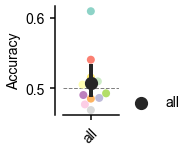

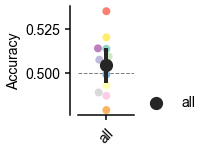

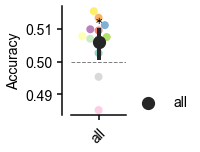

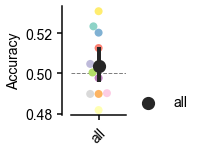

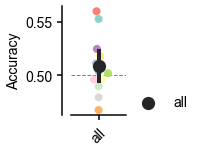

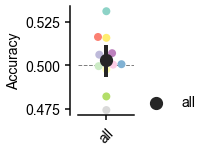

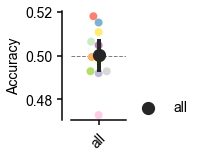

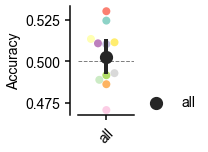

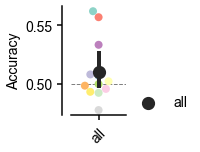

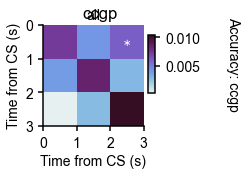

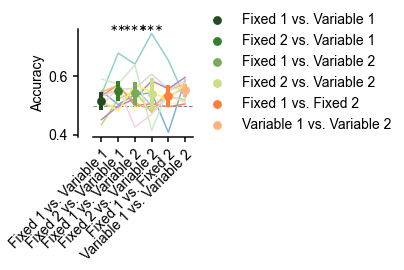

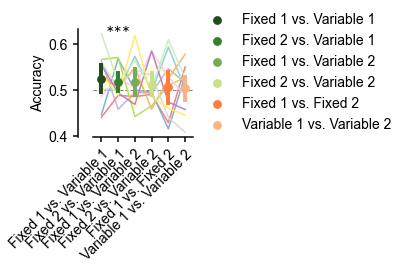

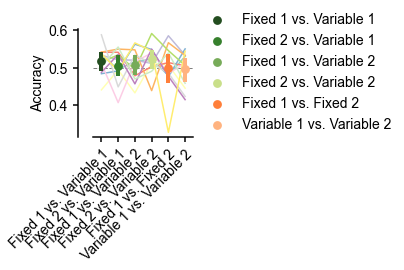

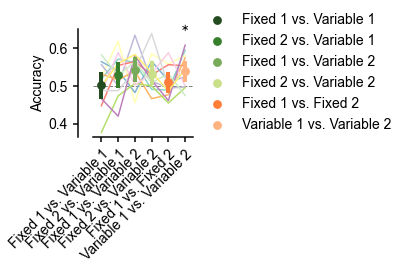

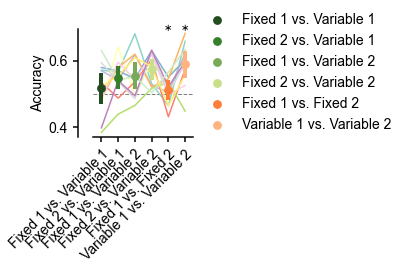

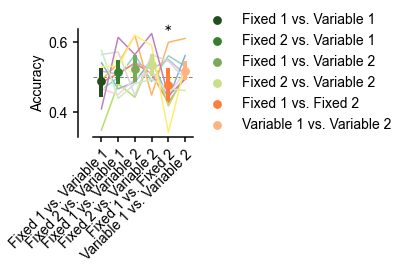

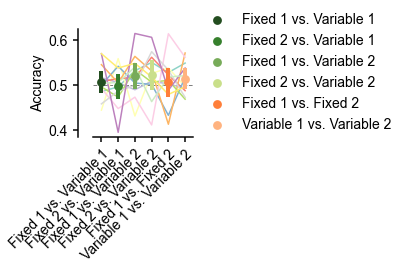

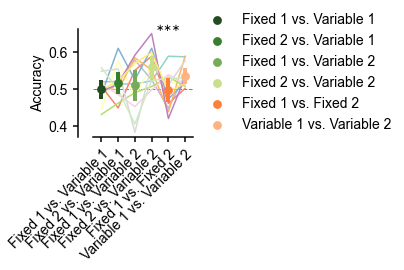

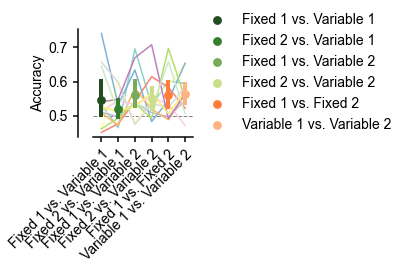

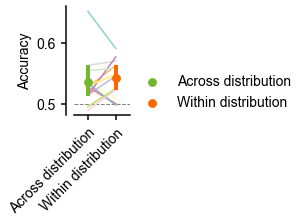

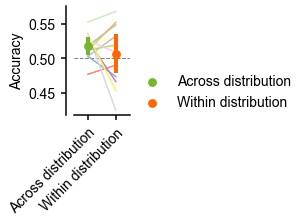

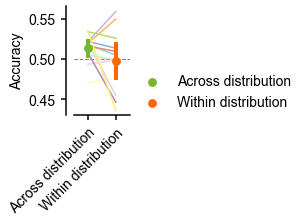

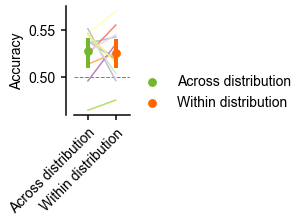

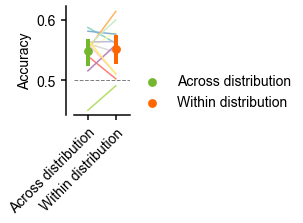

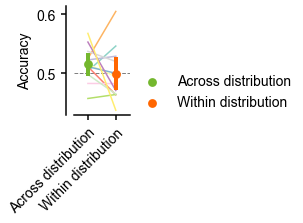

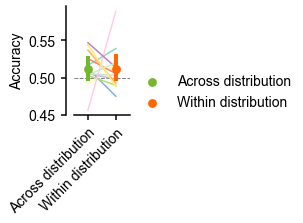

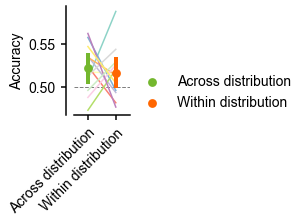

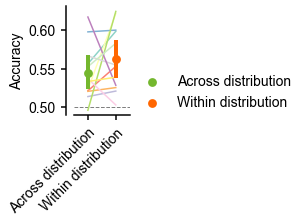

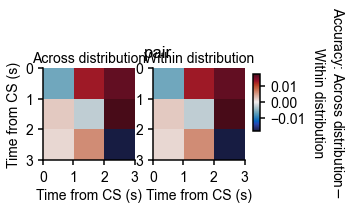

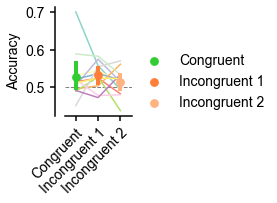

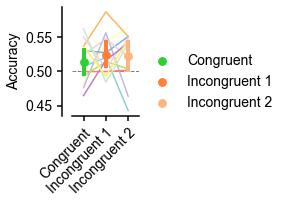

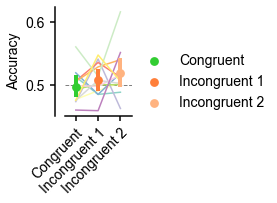

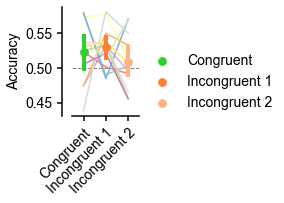

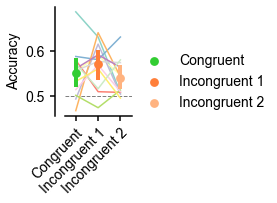

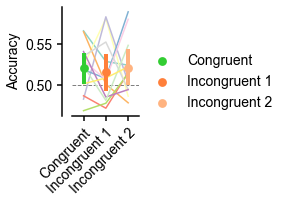

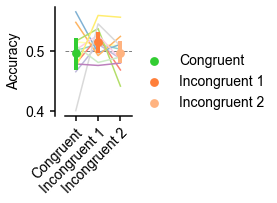

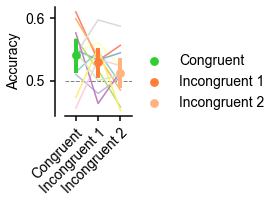

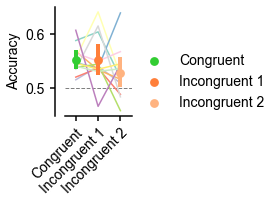

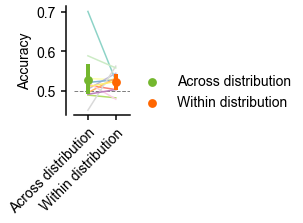

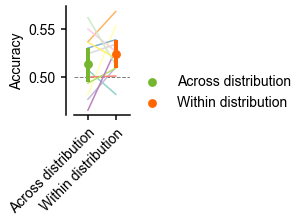

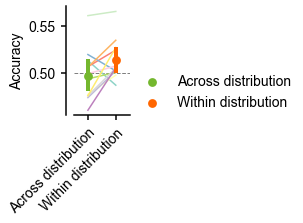

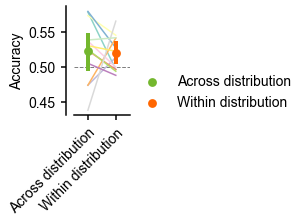

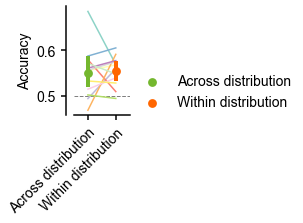

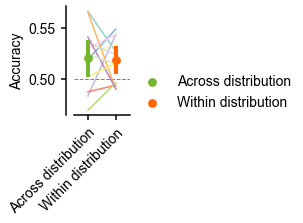

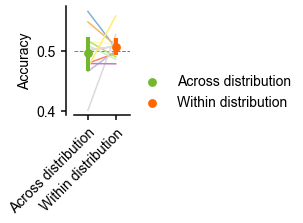

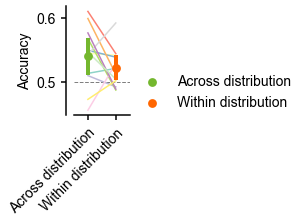

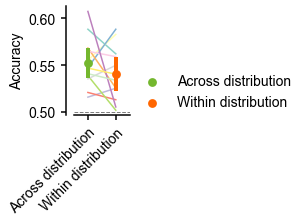

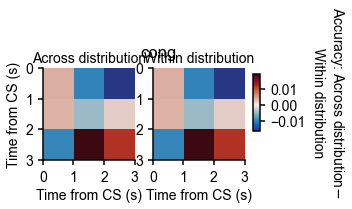

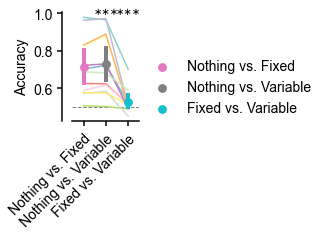

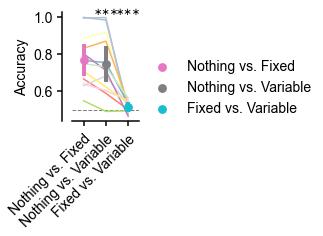

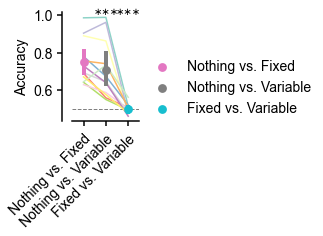

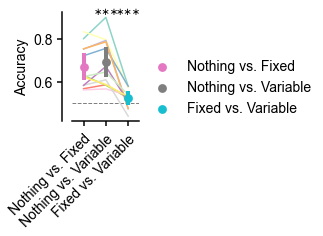

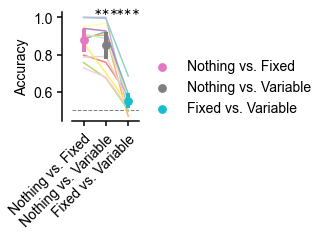

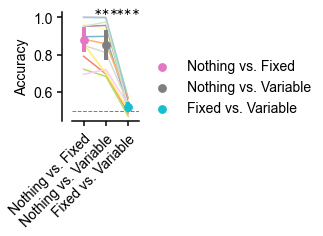

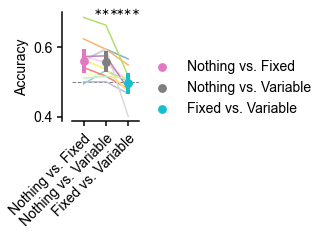

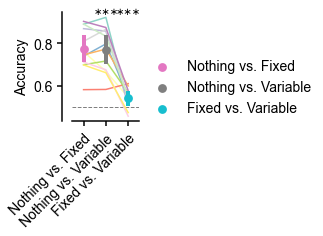

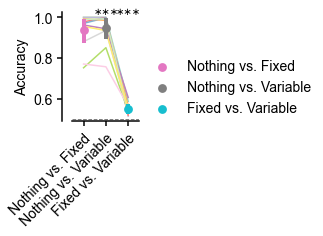

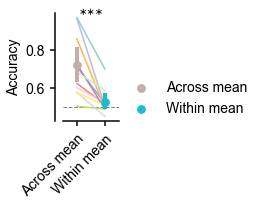

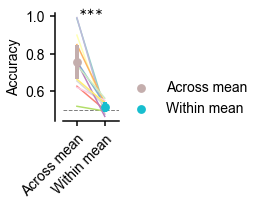

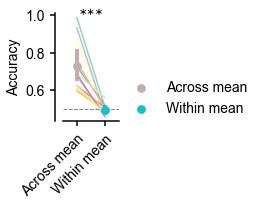

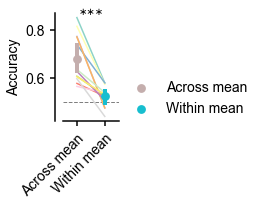

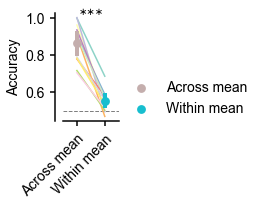

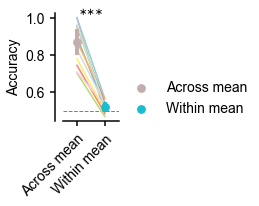

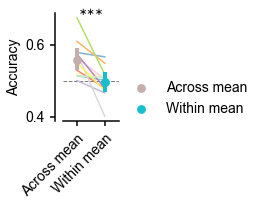

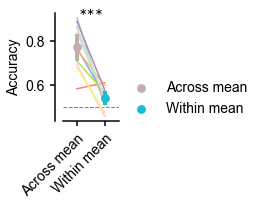

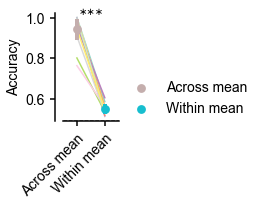

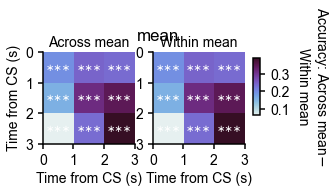

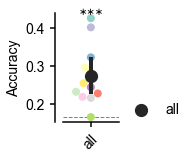

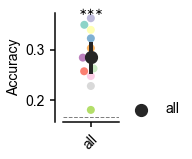

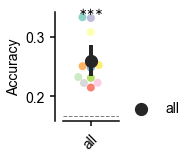

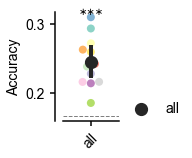

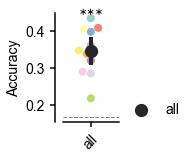

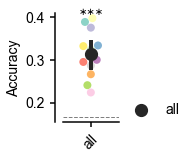

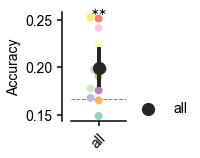

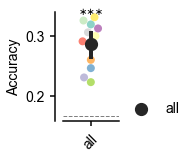

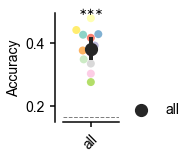

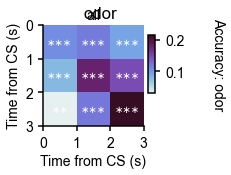

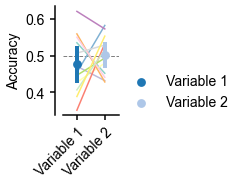

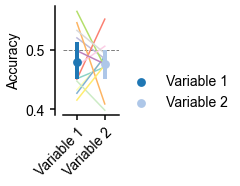

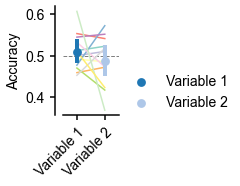

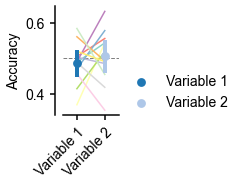

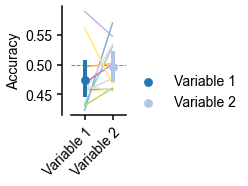

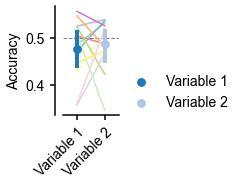

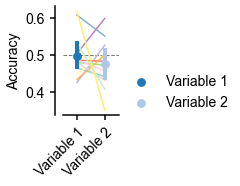

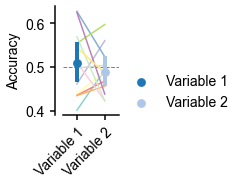

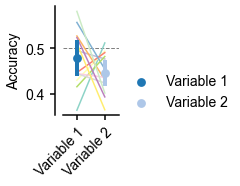

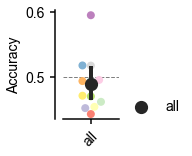

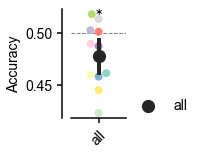

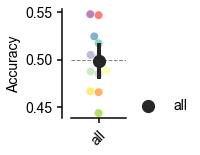

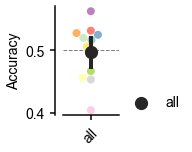

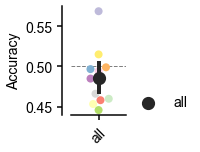

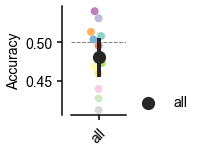

/n/holystore01/LABS/uchida_users/Users/alowet/envs/neural/lib/python3.8/site-packages/seaborn/categorical.py:3544: UserWarning: 8.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


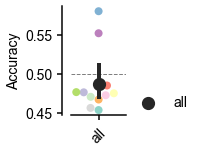

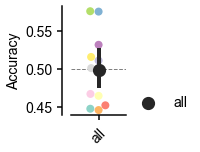

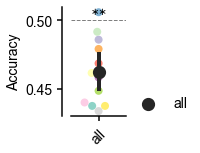

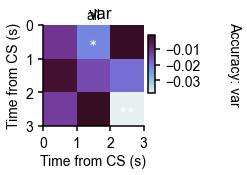

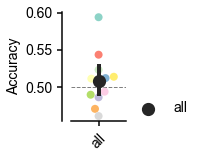

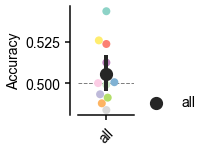

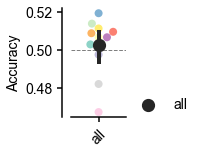

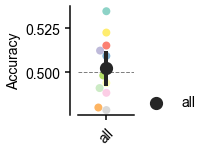

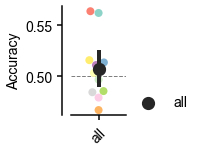

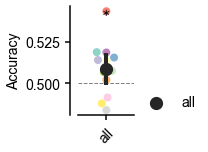

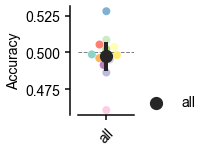

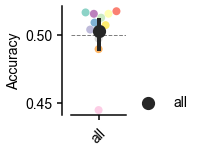

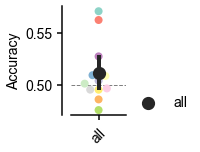

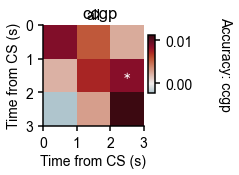

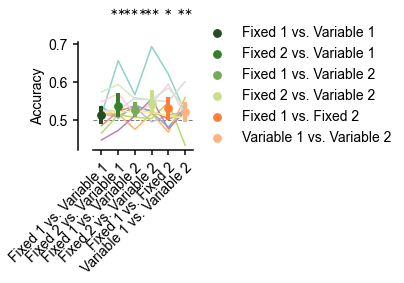

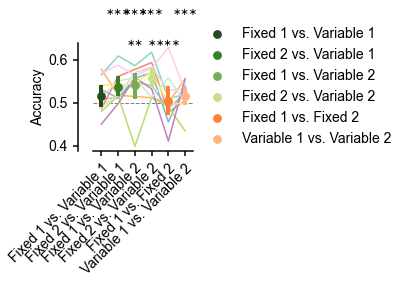

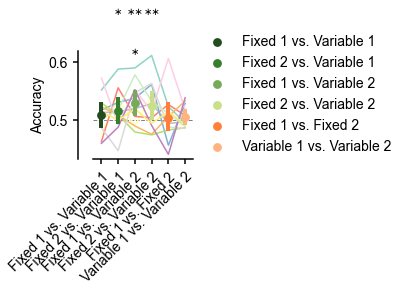

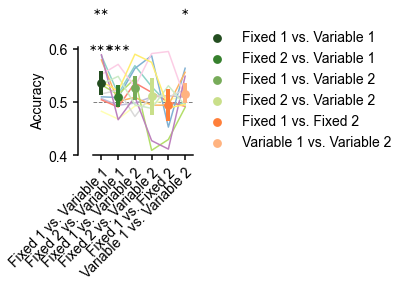

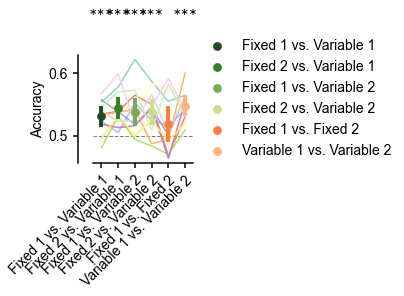

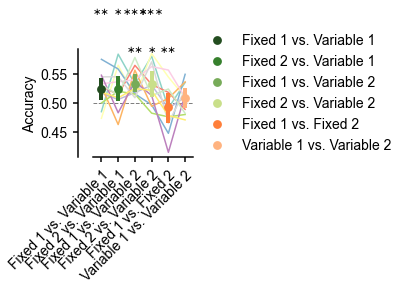

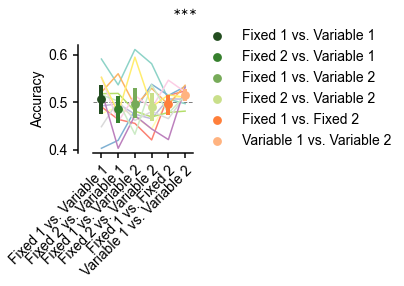

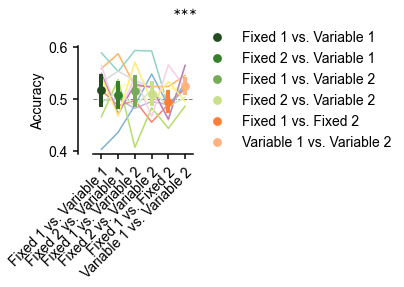

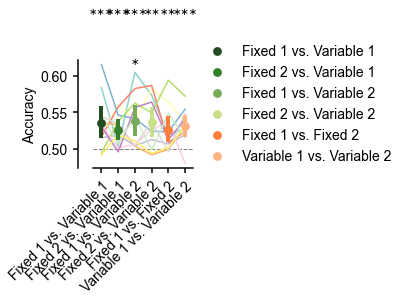

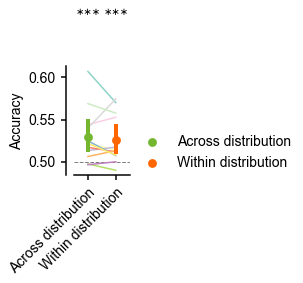

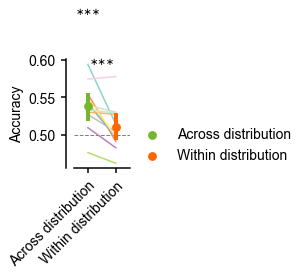

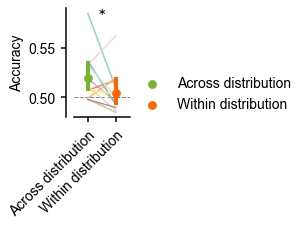

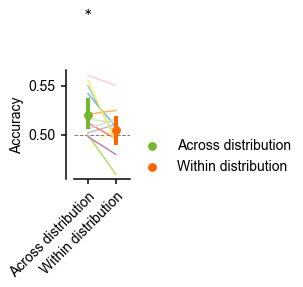

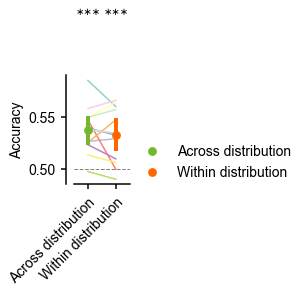

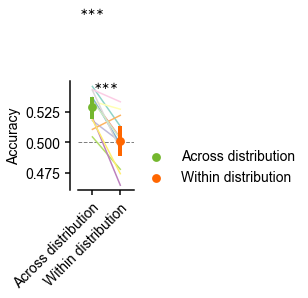

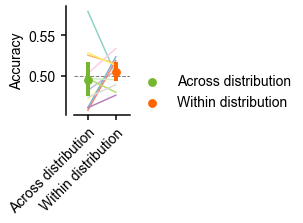

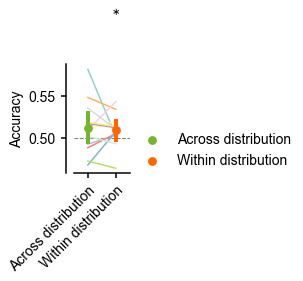

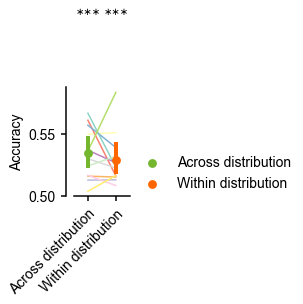

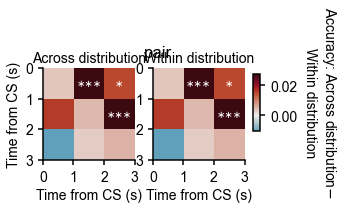

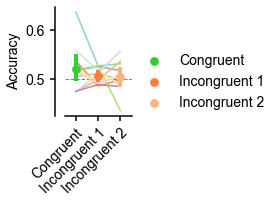

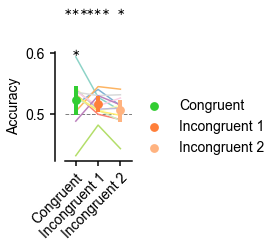

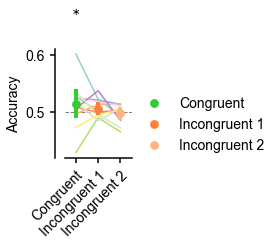

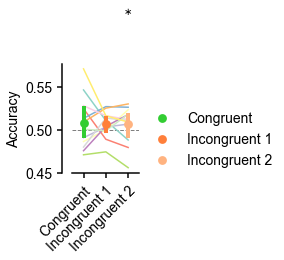

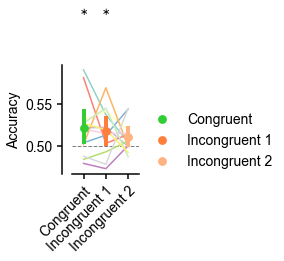

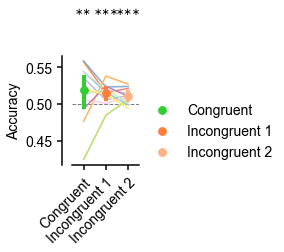

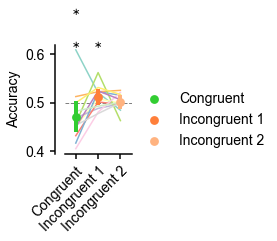

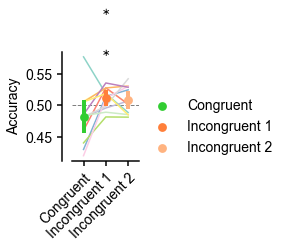

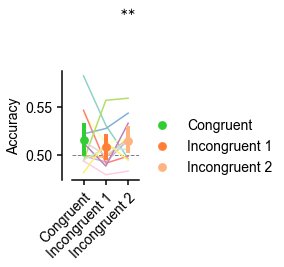

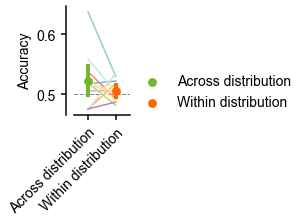

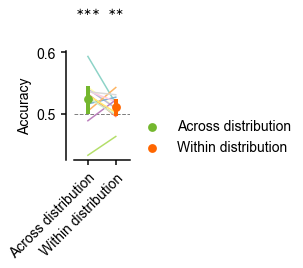

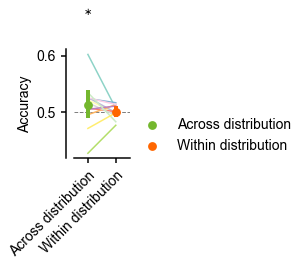

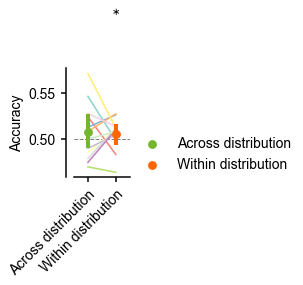

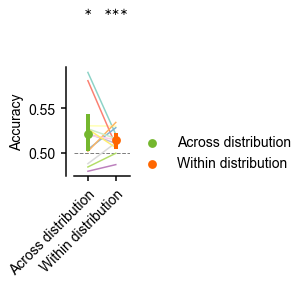

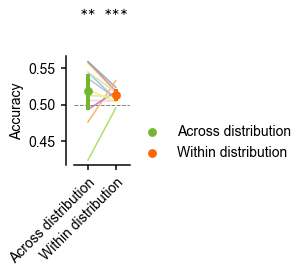

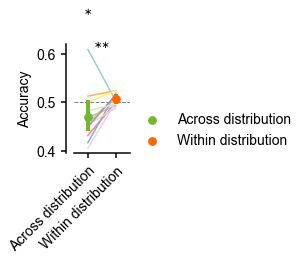

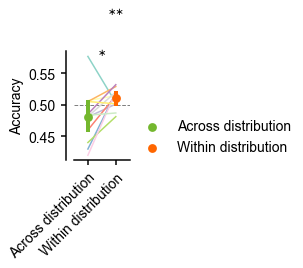

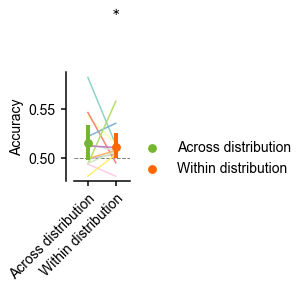

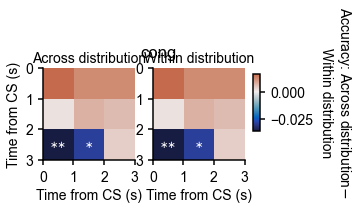

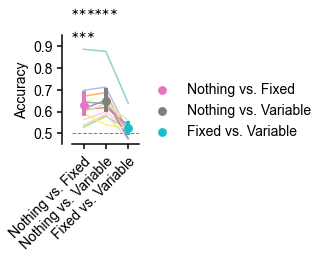

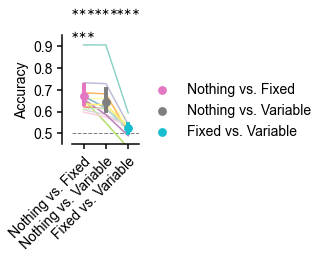

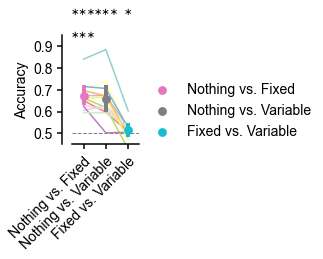

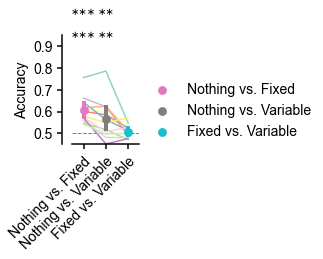

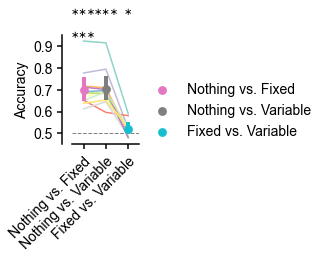

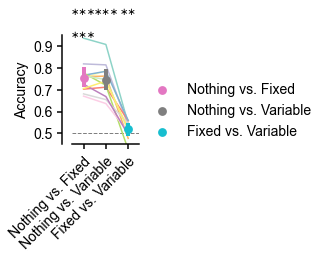

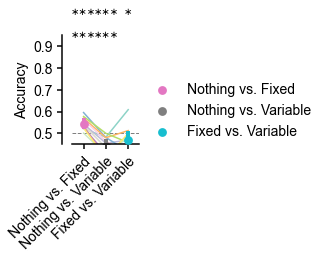

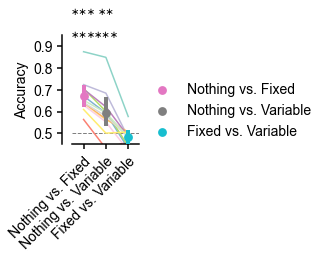

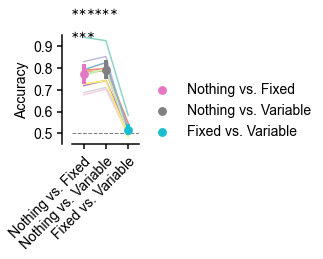

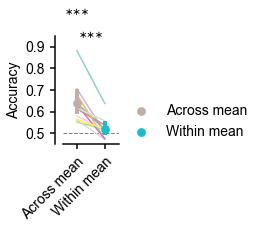

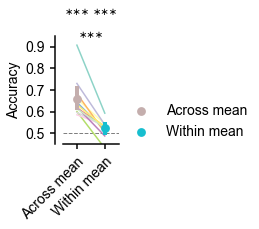

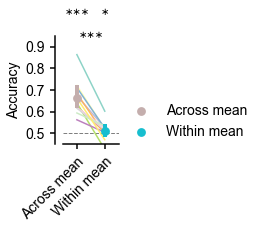

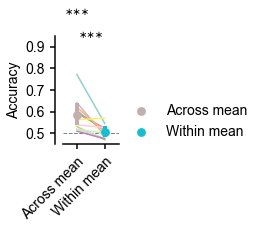

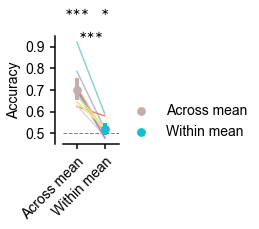

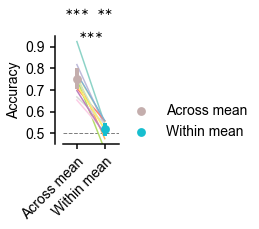

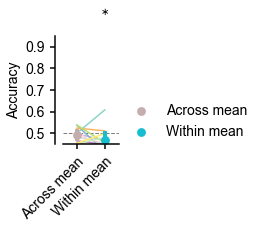

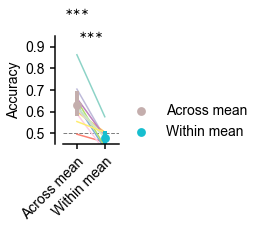

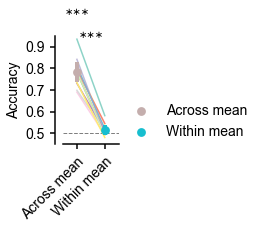

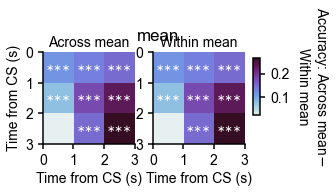

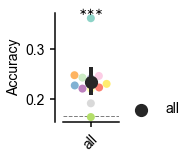

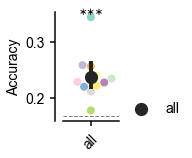

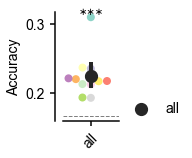

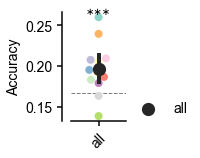

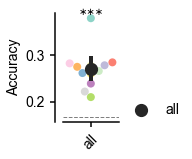

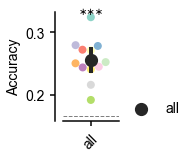

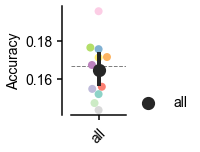

/n/holystore01/LABS/uchida_users/Users/alowet/envs/neural/lib/python3.8/site-packages/seaborn/categorical.py:3544: UserWarning: 16.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


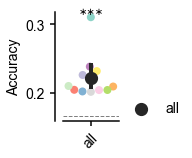

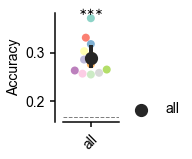

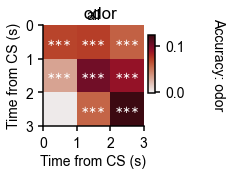

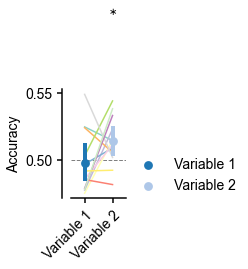

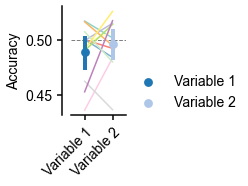

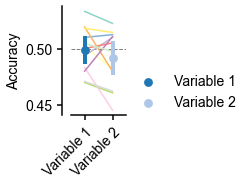

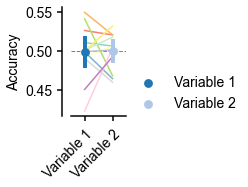

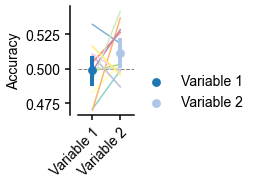

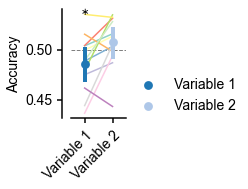

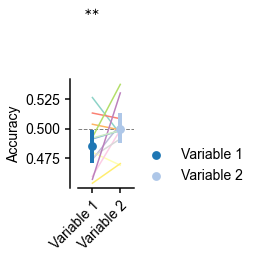

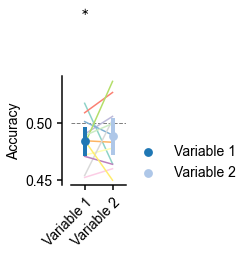

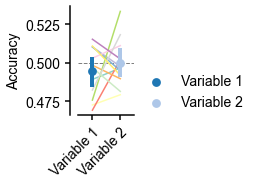

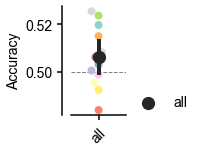

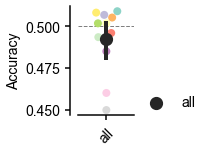

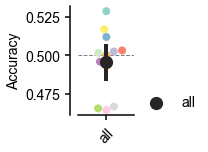

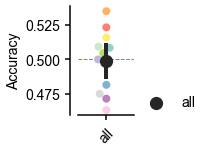

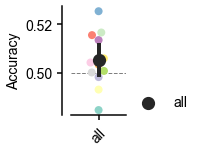

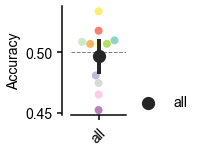

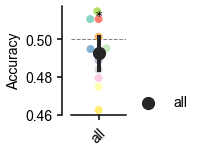

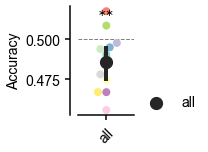

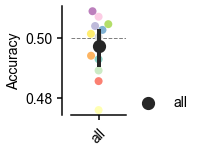

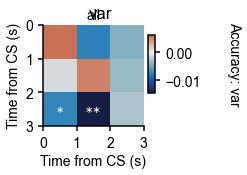

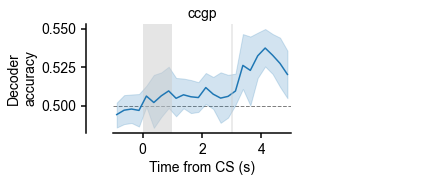

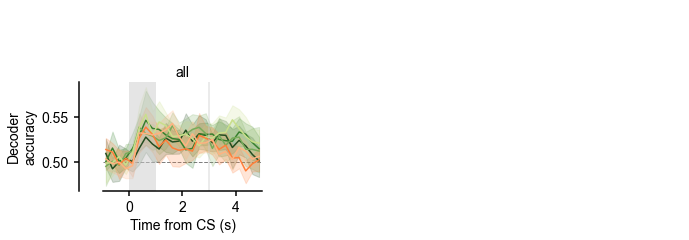

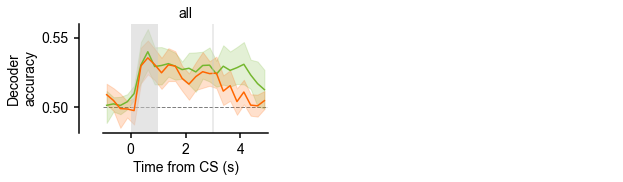

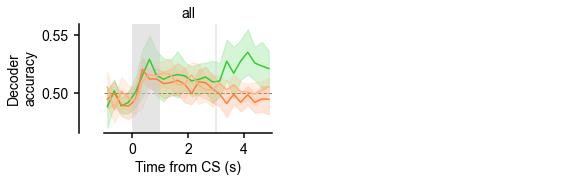

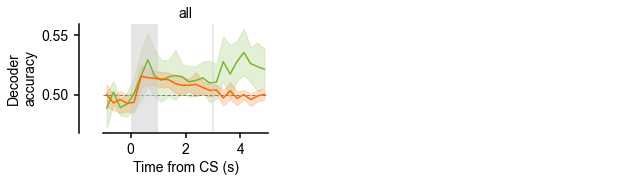

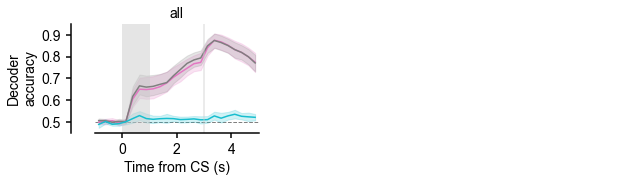

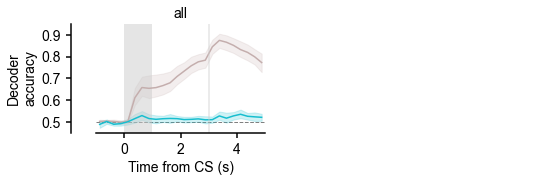

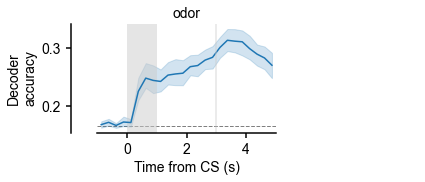

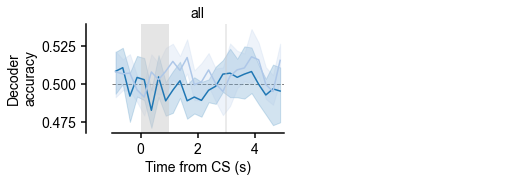

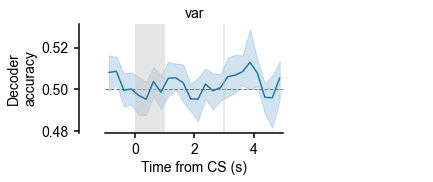

In [34]:
plot_mouse_decode_by_class(class_name, class_labels, dec_dict, per_keys, rois, pseudo=True, n_splits=n_splits,
                           beh=True, mouse_colors=mouse_colors)
plot_mouse_decode_by_class(class_name, class_labels, dec_dict, per_keys, rois, pseudo=False, n_splits=n_splits,
                           beh=True, mouse_colors=mouse_colors, ylims_kw={'mean': {'ylims': [.45, .95], 'yticks': np.arange(.5, 1, .1)}})

1_1


meta NOT subset; don't know how to subset; dropped


2_2


meta NOT subset; don't know how to subset; dropped


3_3


meta NOT subset; don't know how to subset; dropped


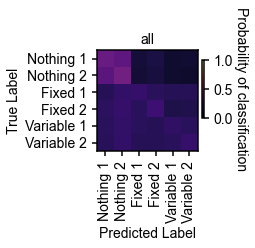

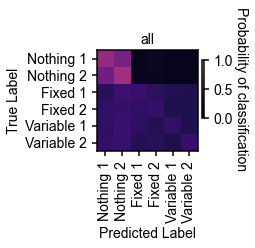

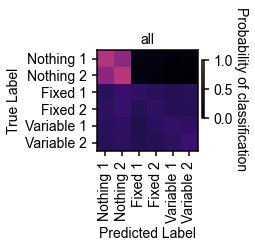

In [37]:
plot_avg_confusion_mat_by_class(class_name, class_labels, dec_dict, ['1_1', '2_2', '3_3'], n_trace_types, protocol_info, beh=True)

# Decoder angles

meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped


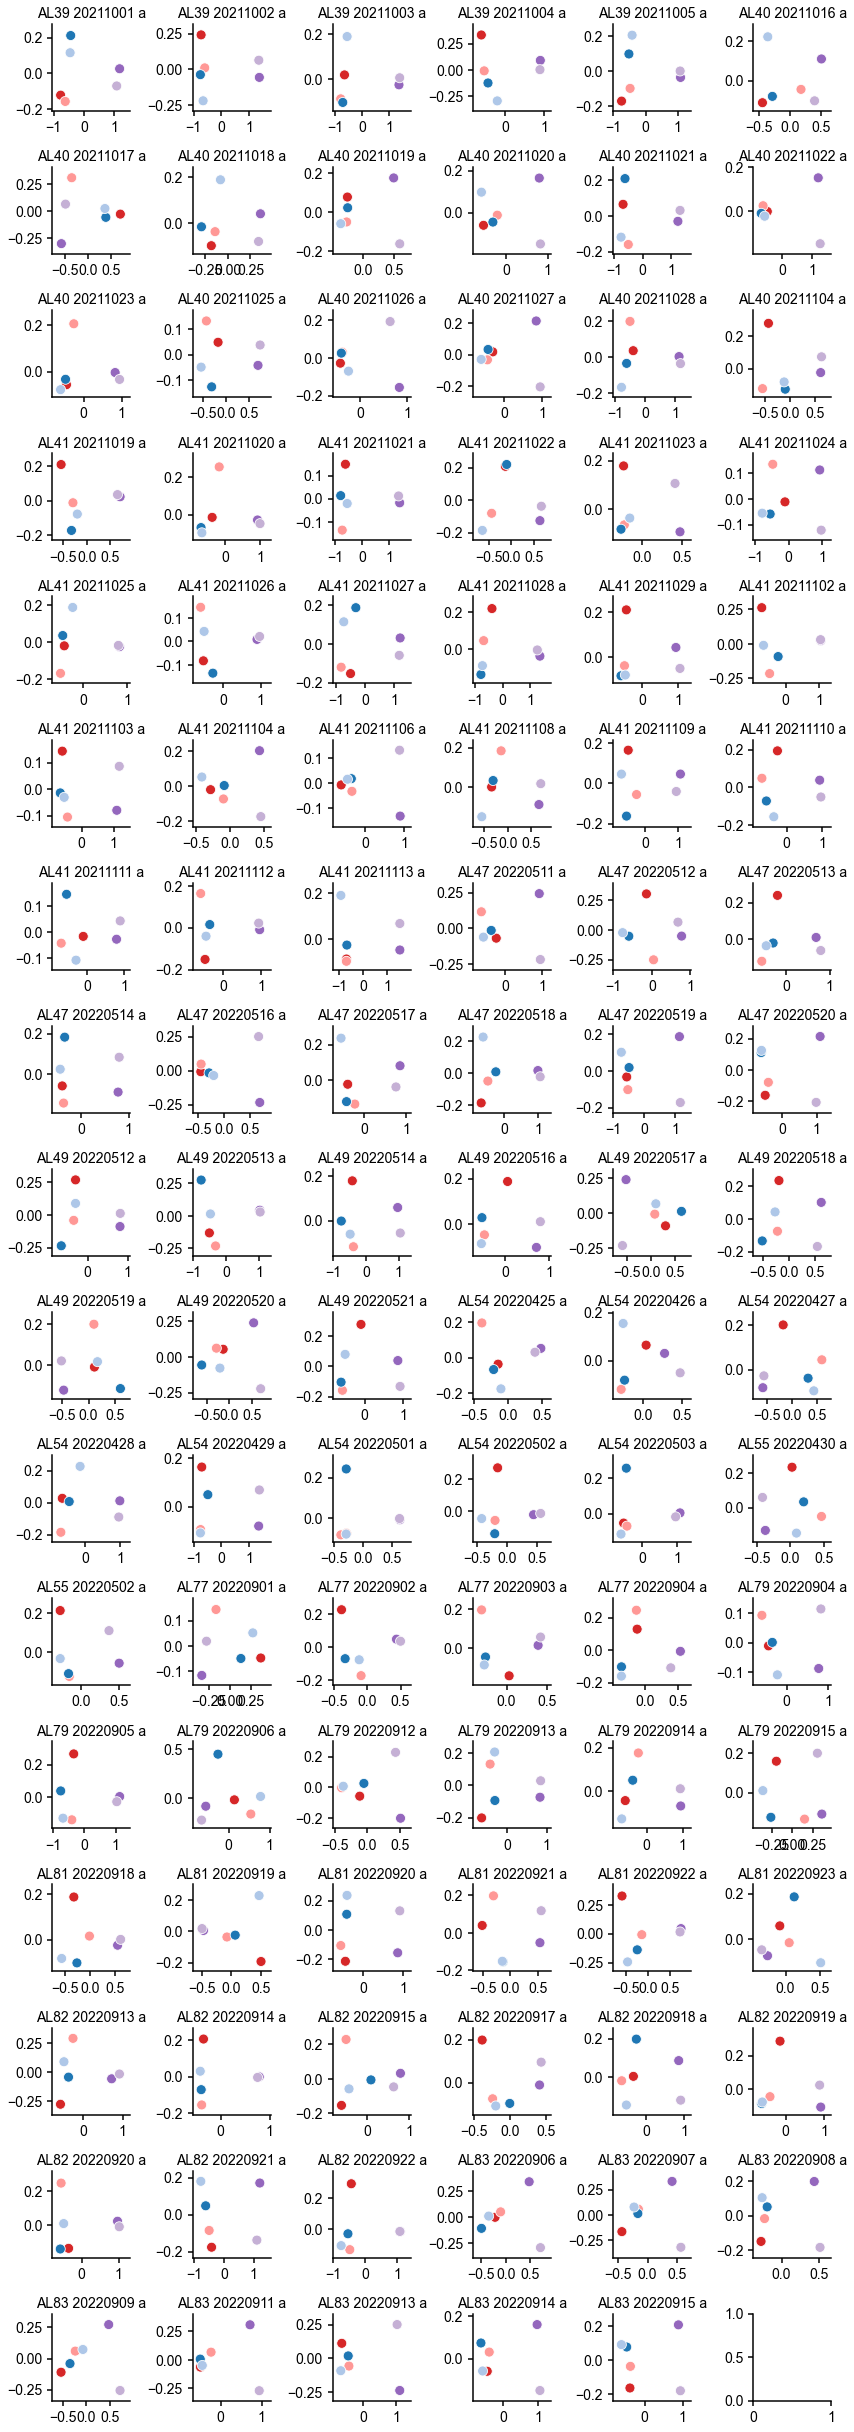

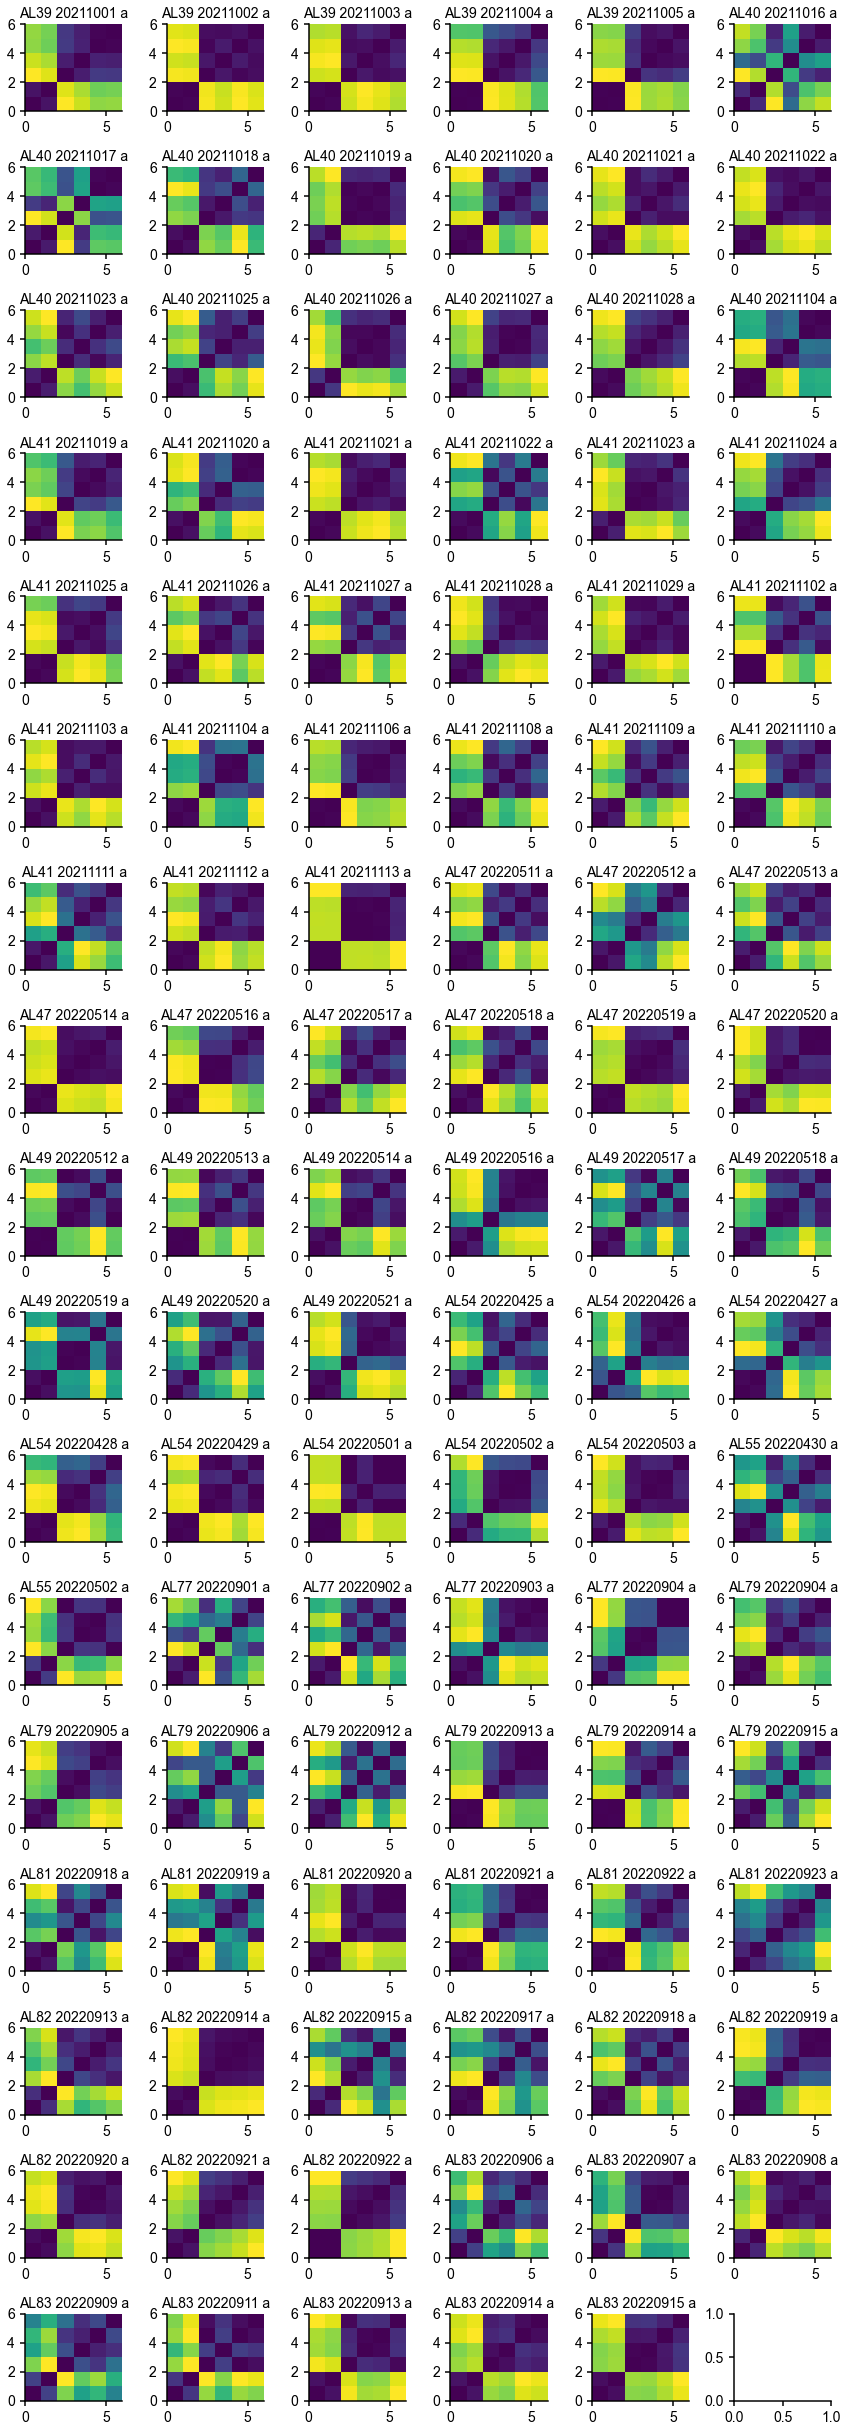

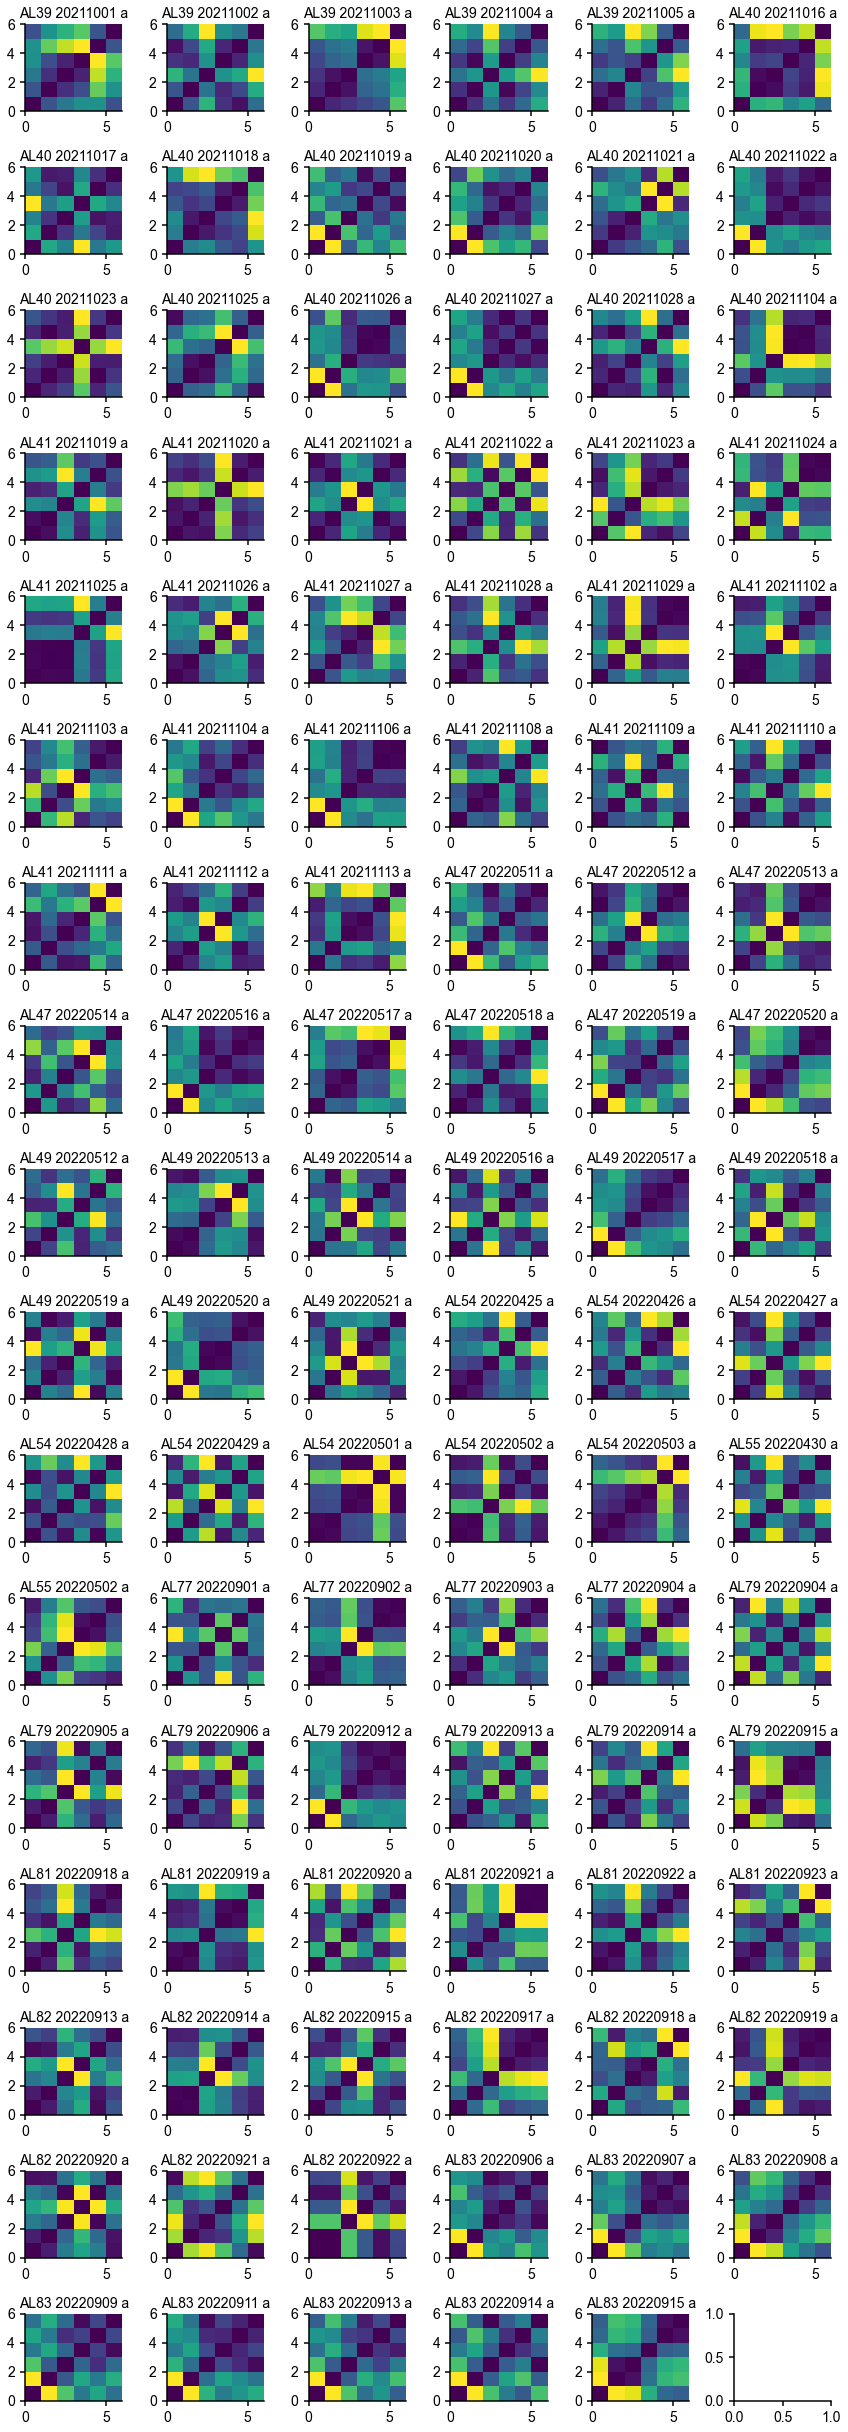

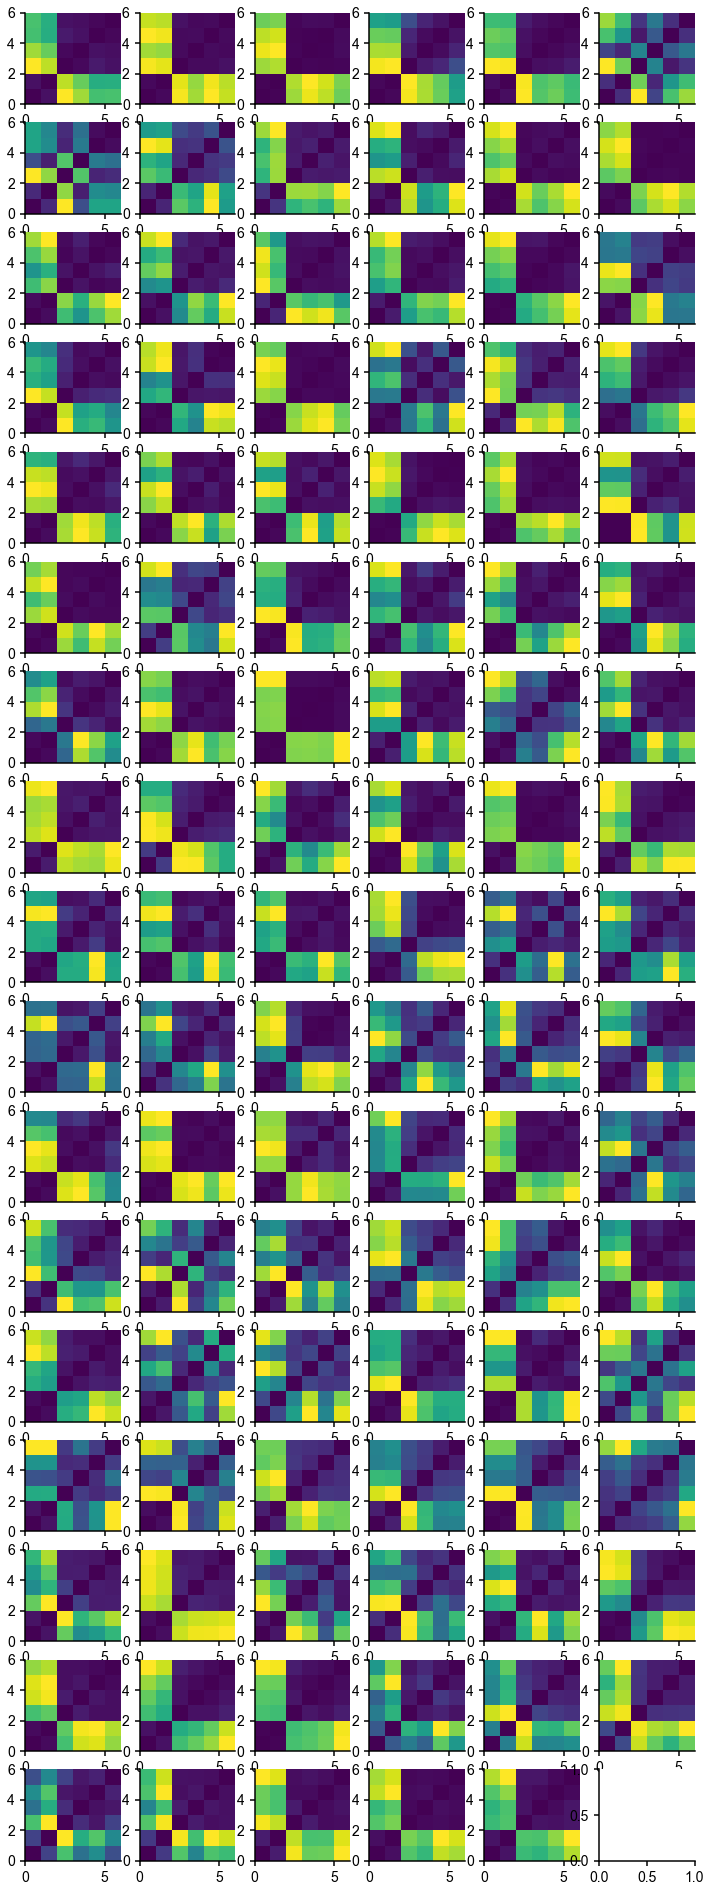

In [45]:
n_components = 2
late_trace_ind = 3
n_pca_splits = 4

ret_df['file_date_id'] = ret_df['exp_date'].astype(str)
ret_df = ret_df.reset_index()
pairwise_dists, rda, session_avg_components, explained_var, sess_class_labels = reduce(
    ret_df, beh_info, X_means_norm, class_name, protocol_info, colors, late_trace_ind, n_components)

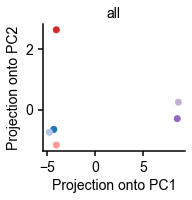

In [46]:
# do a straightforward, no frills PCA on the late cue resps
n_components = 3
pca = PCA(n_components=n_components)
components = {}
fig, axs = plt.subplots(1, len(class_labels), figsize=(3*len(class_labels), 3), squeeze=False)
for i_cls, class_label in enumerate(class_labels):
    projection = pca.fit_transform(X_means_norm[:n_trace_types, beh_info[class_name] == class_label, late_trace_ind])
    components[class_label] = pca.components_
    
    ax = axs[0, i_cls]
    ax.scatter(projection[:, 0], projection[:, 1], color=colors['colors'][:n_trace_types])
    ax.set_xlabel('Projection onto PC1')
    ax.set_ylabel('Projection onto PC2')
    ax.set_title(class_label)
fig.tight_layout()
hide_spines()

In [47]:
angle_df, control_df = compute_angles(dec_dict, beh_info, beh_resps, protocol_info, components, session_avg_components,
                                      ret_df, class_name, class_labels, rois, n_splits=n_splits, train_per=3, test_per=3, use_pseudo=False, do_zscore=True)

['Across distribution', 'Within distribution']
Subregion ['behavior'] dec_key ['ccgp', 'pair', 'cong'] grouping ['Across distribution', 'Within distribution']
pc1_angle simul behavior ccgp
                    Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: abs_cosine_similarity_pc1_angle
No. Observations: 101     Method:             REML                           
No. Groups:       12      Scale:              0.0027                         
Min. group size:  2       Log-Likelihood:     146.4799                       
Max. group size:  21      Converged:          Yes                            
Mean group size:  8.4                                                        
------------------------------------------------------------------------------
                Coef.     Std.Err.      z        P>|z|      [0.025     0.975] 
------------------------------------------------------------------------------
Intercept     1.117e-01  8.527e-03  1.310e+01  3

/n/holystore01/LABS/uchida_users/Users/alowet/envs/neural/lib/python3.8/site-packages/seaborn/categorical.py:3544: UserWarning: 8.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/n/holystore01/LABS/uchida_users/Users/alowet/envs/neural/lib/python3.8/site-packages/seaborn/categorical.py:3544: UserWarning: 8.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
meta NOT subset; don't know how to subset; dropped
/n/holystore01/LABS/uchida_users/Users/alowet/envs/neural/lib/python3.8/site-packages/seaborn/categorical.py:3544: UserWarning: 8.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/n/holystore01/LABS/uchida_users/Users/alowet/envs/neural/lib/python3.8/site-packages/seaborn/categorical.py:3544: UserWarning: 8.3% of the points cann

['Nothing vs. Fixed', 'Nothing vs. Variable', 'Fixed vs. Variable']
Subregion ['behavior'] helper ['all'] key ['Nothing vs. Fixed', 'Nothing vs. Variable', 'Fixed vs. Variable']
pc1_angle simul behavior mean
                           Mixed Linear Model Regression Results
Model:                  MixedLM     Dependent Variable:     abs_cosine_similarity_pc1_angle
No. Observations:       303         Method:                 REML                           
No. Groups:             12          Scale:                  0.0076                         
Min. group size:        6           Log-Likelihood:         296.6176                       
Max. group size:        63          Converged:              Yes                            
Mean group size:        25.2                                                               
-------------------------------------------------------------------------------------------
                                 Coef.    Std.Err.     z       P>|z|      [0.025   

meta NOT subset; don't know how to subset; dropped


['Across distribution', 'Within distribution']
Subregion ['behavior'] dec_key ['ccgp', 'pair', 'cong'] grouping ['Across distribution', 'Within distribution']
pc2_angle simul behavior ccgp
                    Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: abs_cosine_similarity_pc2_angle
No. Observations: 101     Method:             REML                           
No. Groups:       12      Scale:              0.0038                         
Min. group size:  2       Log-Likelihood:     134.5923                       
Max. group size:  21      Converged:          Yes                            
Mean group size:  8.4                                                        
------------------------------------------------------------------------------
                Coef.     Std.Err.      z        P>|z|      [0.025     0.975] 
------------------------------------------------------------------------------
Intercept     3.356e-01  6.124e-03  5.479e+01  0

/n/holystore01/LABS/uchida_users/Users/alowet/envs/neural/lib/python3.8/site-packages/seaborn/categorical.py:3544: UserWarning: 8.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/n/holystore01/LABS/uchida_users/Users/alowet/envs/neural/lib/python3.8/site-packages/seaborn/categorical.py:3544: UserWarning: 8.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/n/holystore01/LABS/uchida_users/Users/alowet/envs/neural/lib/python3.8/site-packages/seaborn/categorical.py:3544: UserWarning: 8.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
meta NOT subset; don't know how to subset; dropped
/n/holystore01/LABS/uchida_users/Users/alowet/envs/neural/lib/python3.8/site-packages/seaborn/categorical.py:3544: UserWarning: 8.3% of the points cann

['Nothing vs. Fixed', 'Nothing vs. Variable', 'Fixed vs. Variable']
Subregion ['behavior'] helper ['all'] key ['Nothing vs. Fixed', 'Nothing vs. Variable', 'Fixed vs. Variable']
pc2_angle simul behavior mean
                            Mixed Linear Model Regression Results
Model:                   MixedLM      Dependent Variable:      abs_cosine_similarity_pc2_angle
No. Observations:        303          Method:                  REML                           
No. Groups:              12           Scale:                   0.0305                         
Min. group size:         6            Log-Likelihood:          89.9712                        
Max. group size:         63           Converged:               Yes                            
Mean group size:         25.2                                                                 
----------------------------------------------------------------------------------------------
                                 Coef.     Std.Err.     z    

meta NOT subset; don't know how to subset; dropped


['Across distribution', 'Within distribution']
Subregion ['behavior'] dec_key ['ccgp', 'pair', 'cong'] grouping ['Across distribution', 'Within distribution']
pc3_angle simul behavior ccgp
                    Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: abs_cosine_similarity_pc3_angle
No. Observations: 101     Method:             REML                           
No. Groups:       12      Scale:              0.0070                         
Min. group size:  2       Log-Likelihood:     103.6387                       
Max. group size:  21      Converged:          Yes                            
Mean group size:  8.4                                                        
------------------------------------------------------------------------------
                Coef.     Std.Err.      z        P>|z|      [0.025     0.975] 
------------------------------------------------------------------------------
Intercept     4.133e-01  8.933e-03  4.627e+01  0

/n/holystore01/LABS/uchida_users/Users/alowet/envs/neural/lib/python3.8/site-packages/seaborn/categorical.py:3544: UserWarning: 50.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/n/holystore01/LABS/uchida_users/Users/alowet/envs/neural/lib/python3.8/site-packages/seaborn/categorical.py:3544: UserWarning: 33.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/n/holystore01/LABS/uchida_users/Users/alowet/envs/neural/lib/python3.8/site-packages/seaborn/categorical.py:3544: UserWarning: 25.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/n/holystore01/LABS/uchida_users/Users/alowet/envs/neural/lib/python3.8/site-packages/seaborn/categorical.py:3544: UserWarning: 66.7% of the points cannot be placed; you may want to decrease the size

['Nothing vs. Fixed', 'Nothing vs. Variable', 'Fixed vs. Variable']
Subregion ['behavior'] helper ['all'] key ['Nothing vs. Fixed', 'Nothing vs. Variable', 'Fixed vs. Variable']
pc3_angle simul behavior mean
                            Mixed Linear Model Regression Results
Model:                   MixedLM      Dependent Variable:      abs_cosine_similarity_pc3_angle
No. Observations:        303          Method:                  REML                           
No. Groups:              12           Scale:                   0.0288                         
Min. group size:         6            Log-Likelihood:          99.0888                        
Max. group size:         63           Converged:               Yes                            
Mean group size:         25.2                                                                 
----------------------------------------------------------------------------------------------
                                 Coef.     Std.Err.     z    

meta NOT subset; don't know how to subset; dropped


['Across distribution', 'Within distribution']
Subregion ['behavior'] dec_key ['ccgp', 'pair', 'cong'] grouping ['Across distribution', 'Within distribution']
value_angle simul behavior ccgp
                     Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: abs_cosine_similarity_value_angle
No. Observations: 101     Method:             REML                             
No. Groups:       12      Scale:              0.0017                           
Min. group size:  2       Log-Likelihood:     173.1719                         
Max. group size:  21      Converged:          Yes                              
Mean group size:  8.4                                                          
---------------------------------------------------------------------------------
              Coef.      Std.Err.       z         P>|z|       [0.025      0.975] 
---------------------------------------------------------------------------------
Intercept   8.911e-02   

/n/holystore01/LABS/uchida_users/Users/alowet/envs/neural/lib/python3.8/site-packages/seaborn/categorical.py:3544: UserWarning: 16.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/n/holystore01/LABS/uchida_users/Users/alowet/envs/neural/lib/python3.8/site-packages/seaborn/categorical.py:3544: UserWarning: 25.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/n/holystore01/LABS/uchida_users/Users/alowet/envs/neural/lib/python3.8/site-packages/seaborn/categorical.py:3544: UserWarning: 8.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/n/holystore01/LABS/uchida_users/Users/alowet/envs/neural/lib/python3.8/site-packages/seaborn/categorical.py:3544: UserWarning: 16.7% of the points cannot be placed; you may want to decrease the size 

['Nothing vs. Fixed', 'Nothing vs. Variable', 'Fixed vs. Variable']
Subregion ['behavior'] helper ['all'] key ['Nothing vs. Fixed', 'Nothing vs. Variable', 'Fixed vs. Variable']
value_angle simul behavior mean
                          Mixed Linear Model Regression Results
Model:                 MixedLM    Dependent Variable:    abs_cosine_similarity_value_angle
No. Observations:      303        Method:                REML                             
No. Groups:            12         Scale:                 0.0047                           
Min. group size:       6          Log-Likelihood:        361.6545                         
Max. group size:       63         Converged:             Yes                              
Mean group size:       25.2                                                               
------------------------------------------------------------------------------------------
                                 Coef.    Std.Err.     z       P>|z|     [0.025    0.975]

meta NOT subset; don't know how to subset; dropped


['Across distribution', 'Within distribution']
Subregion ['behavior'] dec_key ['ccgp', 'pair', 'cong'] grouping ['Across distribution', 'Within distribution']
var_angle simul behavior ccgp
                    Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: abs_cosine_similarity_var_angle
No. Observations: 101     Method:             REML                           
No. Groups:       12      Scale:              0.0033                         
Min. group size:  2       Log-Likelihood:     135.6195                       
Max. group size:  21      Converged:          Yes                            
Mean group size:  8.4                                                        
------------------------------------------------------------------------------
                Coef.     Std.Err.      z        P>|z|      [0.025     0.975] 
------------------------------------------------------------------------------
Intercept     4.302e-01  1.014e-02  4.242e+01  0

/n/holystore01/LABS/uchida_users/Users/alowet/envs/neural/lib/python3.8/site-packages/seaborn/categorical.py:3544: UserWarning: 8.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/n/holystore01/LABS/uchida_users/Users/alowet/envs/neural/lib/python3.8/site-packages/seaborn/categorical.py:3544: UserWarning: 41.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/n/holystore01/LABS/uchida_users/Users/alowet/envs/neural/lib/python3.8/site-packages/seaborn/categorical.py:3544: UserWarning: 33.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/n/holystore01/LABS/uchida_users/Users/alowet/envs/neural/lib/python3.8/site-packages/seaborn/categorical.py:3544: UserWarning: 50.0% of the points cannot be placed; you may want to decrease the size 

['Nothing vs. Fixed', 'Nothing vs. Variable', 'Fixed vs. Variable']
Subregion ['behavior'] helper ['all'] key ['Nothing vs. Fixed', 'Nothing vs. Variable', 'Fixed vs. Variable']
var_angle simul behavior mean
                            Mixed Linear Model Regression Results
Model:                   MixedLM      Dependent Variable:      abs_cosine_similarity_var_angle
No. Observations:        303          Method:                  REML                           
No. Groups:              12           Scale:                   0.0038                         
Min. group size:         6            Log-Likelihood:          395.4992                       
Max. group size:         63           Converged:               Yes                            
Mean group size:         25.2                                                                 
----------------------------------------------------------------------------------------------
                                 Coef.     Std.Err.     z    

meta NOT subset; don't know how to subset; dropped


['Across distribution']
Subregion ['behavior'] grouping ['Across distribution'] helper ['all']
value_pc1_angle simul behavior cong
                       Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: abs_cosine_similarity_value_pc1_angle
No. Observations: 101     Method:             REML                                 
No. Groups:       12      Scale:              0.0079                               
Min. group size:  2       Log-Likelihood:     95.8722                              
Max. group size:  21      Converged:          Yes                                  
Mean group size:  8.4                                                              
-------------------------------------------------------------------------------------
                 Coef.      Std.Err.       z         P>|z|        [0.025      0.975] 
-------------------------------------------------------------------------------------
Intercept      3.371e-01   1.088e-02   3.097e+

meta NOT subset; don't know how to subset; dropped


['Nothing vs. Fixed', 'Nothing vs. Variable', 'Fixed vs. Variable']
Subregion ['behavior'] helper ['all'] key ['Nothing vs. Fixed', 'Nothing vs. Variable', 'Fixed vs. Variable']
value_pc1_angle simul behavior mean
                           Mixed Linear Model Regression Results
Model:               MixedLM    Dependent Variable:    abs_cosine_similarity_value_pc1_angle
No. Observations:    303        Method:                REML                                 
No. Groups:          12         Scale:                 0.0073                               
Min. group size:     6          Log-Likelihood:        296.6335                             
Max. group size:     63         Converged:             Yes                                  
Mean group size:     25.2                                                                   
--------------------------------------------------------------------------------------------
                                 Coef.    Std.Err.     z       P>|z|  

meta NOT subset; don't know how to subset; dropped


['Across distribution']
Subregion ['behavior'] grouping ['Across distribution'] helper ['all']
var_pc2_angle simul behavior cong
                      Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: abs_cosine_similarity_var_pc2_angle
No. Observations: 101     Method:             REML                               
No. Groups:       12      Scale:              0.0095                             
Min. group size:  2       Log-Likelihood:     88.3811                            
Max. group size:  21      Converged:          Yes                                
Mean group size:  8.4                                                            
-----------------------------------------------------------------------------------
                Coef.      Std.Err.       z         P>|z|       [0.025      0.975] 
-----------------------------------------------------------------------------------
Intercept     1.792e-01   9.821e-03   1.825e+01   2.011e-74   1.600

meta NOT subset; don't know how to subset; dropped


['Nothing vs. Fixed', 'Nothing vs. Variable', 'Fixed vs. Variable']
Subregion ['behavior'] helper ['all'] key ['Nothing vs. Fixed', 'Nothing vs. Variable', 'Fixed vs. Variable']
var_pc2_angle simul behavior mean
                            Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     abs_cosine_similarity_var_pc2_angle
No. Observations:     303         Method:                 REML                               
No. Groups:           12          Scale:                  0.0090                             
Min. group size:      6           Log-Likelihood:         269.2388                           
Max. group size:      63          Converged:              Yes                                
Mean group size:      25.2                                                                   
---------------------------------------------------------------------------------------------
                                 Coef.     Std.Err.     z       

meta NOT subset; don't know how to subset; dropped


['Across distribution']
Subregion ['behavior'] grouping ['Across distribution'] helper ['all']
sess_value_pc1_angle simul behavior cong
                         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: abs_cosine_similarity_sess_value_pc1_angle
No. Observations: 101     Method:             REML                                      
No. Groups:       12      Scale:              0.0085                                    
Min. group size:  2       Log-Likelihood:     92.8638                                   
Max. group size:  21      Converged:          Yes                                       
Mean group size:  8.4                                                                   
-------------------------------------------------------------------------------------------
                  Coef.       Std.Err.        z          P>|z|         [0.025       0.975] 
-----------------------------------------------------------------------------------

meta NOT subset; don't know how to subset; dropped


['Nothing vs. Fixed', 'Nothing vs. Variable', 'Fixed vs. Variable']
Subregion ['behavior'] helper ['all'] key ['Nothing vs. Fixed', 'Nothing vs. Variable', 'Fixed vs. Variable']
sess_value_pc1_angle simul behavior mean
                           Mixed Linear Model Regression Results
Model:              MixedLM  Dependent Variable:  abs_cosine_similarity_sess_value_pc1_angle
No. Observations:   303      Method:              REML                                      
No. Groups:         12       Scale:               0.0078                                    
Min. group size:    6        Log-Likelihood:      287.5356                                  
Max. group size:    63       Converged:           Yes                                       
Mean group size:    25.2                                                                    
--------------------------------------------------------------------------------------------
                                 Coef.    Std.Err.     z       P>

meta NOT subset; don't know how to subset; dropped


['Across distribution']
Subregion ['behavior'] grouping ['Across distribution'] helper ['all']
sess_var_pc2_angle simul behavior cong
                        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: abs_cosine_similarity_sess_var_pc2_angle
No. Observations: 101     Method:             REML                                    
No. Groups:       12      Scale:              0.0131                                  
Min. group size:  2       Log-Likelihood:     66.0435                                 
Max. group size:  21      Converged:          Yes                                     
Mean group size:  8.4                                                                 
-----------------------------------------------------------------------------------------
                 Coef.       Std.Err.        z          P>|z|        [0.025       0.975] 
-----------------------------------------------------------------------------------------
Intercept   

meta NOT subset; don't know how to subset; dropped


['Nothing vs. Fixed', 'Nothing vs. Variable', 'Fixed vs. Variable']
Subregion ['behavior'] helper ['all'] key ['Nothing vs. Fixed', 'Nothing vs. Variable', 'Fixed vs. Variable']
sess_var_pc2_angle simul behavior mean
                            Mixed Linear Model Regression Results
Model:               MixedLM   Dependent Variable:   abs_cosine_similarity_sess_var_pc2_angle
No. Observations:    303       Method:               REML                                    
No. Groups:          12        Scale:                0.0120                                  
Min. group size:     6         Log-Likelihood:       216.9026                                
Max. group size:     63        Converged:            Yes                                     
Mean group size:     25.2                                                                    
---------------------------------------------------------------------------------------------
                                 Coef.     Std.Err.     z  

meta NOT subset; don't know how to subset; dropped
/n/holystore01/LABS/uchida_users/Users/alowet/envs/neural/lib/python3.8/site-packages/seaborn/categorical.py:3544: UserWarning: 8.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/n/holystore01/LABS/uchida_users/Users/alowet/envs/neural/lib/python3.8/site-packages/seaborn/categorical.py:3544: UserWarning: 8.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


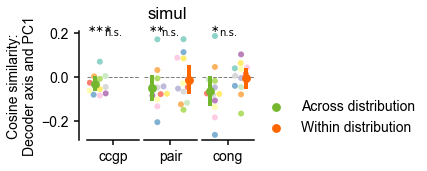

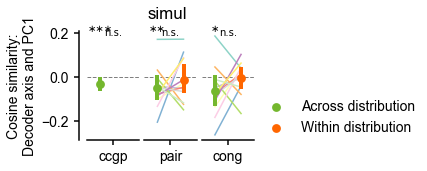

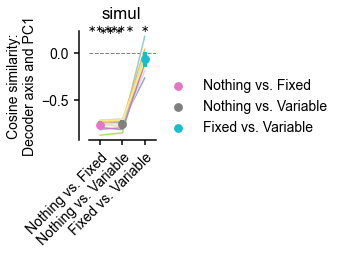

/n/holystore01/LABS/uchida_users/Users/alowet/envs/neural/lib/python3.8/site-packages/seaborn/categorical.py:3544: UserWarning: 8.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/n/holystore01/LABS/uchida_users/Users/alowet/envs/neural/lib/python3.8/site-packages/seaborn/categorical.py:3544: UserWarning: 8.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/n/holystore01/LABS/uchida_users/Users/alowet/envs/neural/lib/python3.8/site-packages/seaborn/categorical.py:3544: UserWarning: 8.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


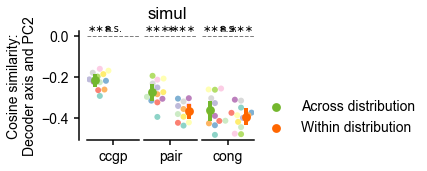

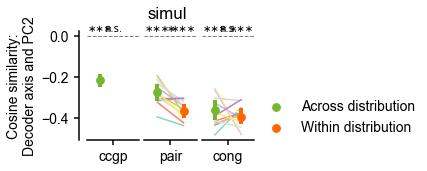

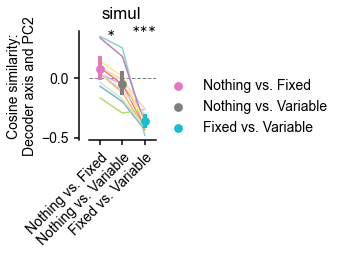

/n/holystore01/LABS/uchida_users/Users/alowet/envs/neural/lib/python3.8/site-packages/seaborn/categorical.py:3544: UserWarning: 50.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/n/holystore01/LABS/uchida_users/Users/alowet/envs/neural/lib/python3.8/site-packages/seaborn/categorical.py:3544: UserWarning: 33.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/n/holystore01/LABS/uchida_users/Users/alowet/envs/neural/lib/python3.8/site-packages/seaborn/categorical.py:3544: UserWarning: 25.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/n/holystore01/LABS/uchida_users/Users/alowet/envs/neural/lib/python3.8/site-packages/seaborn/categorical.py:3544: UserWarning: 66.7% of the points cannot be placed; you may want to decrease the size

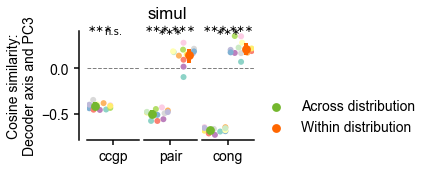

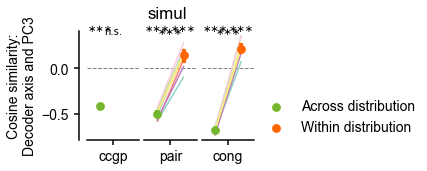

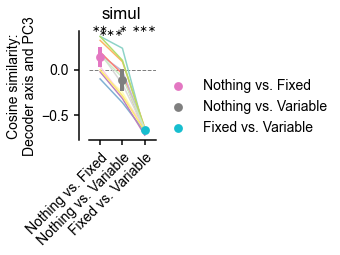

/n/holystore01/LABS/uchida_users/Users/alowet/envs/neural/lib/python3.8/site-packages/seaborn/categorical.py:3544: UserWarning: 16.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/n/holystore01/LABS/uchida_users/Users/alowet/envs/neural/lib/python3.8/site-packages/seaborn/categorical.py:3544: UserWarning: 25.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/n/holystore01/LABS/uchida_users/Users/alowet/envs/neural/lib/python3.8/site-packages/seaborn/categorical.py:3544: UserWarning: 8.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/n/holystore01/LABS/uchida_users/Users/alowet/envs/neural/lib/python3.8/site-packages/seaborn/categorical.py:3544: UserWarning: 16.7% of the points cannot be placed; you may want to decrease the size 

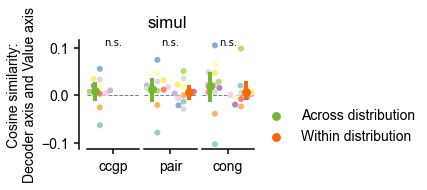

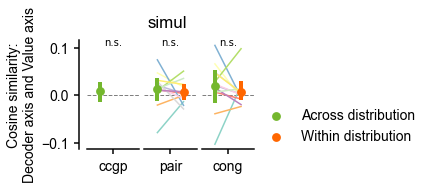

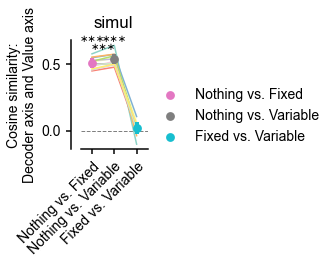

/n/holystore01/LABS/uchida_users/Users/alowet/envs/neural/lib/python3.8/site-packages/seaborn/categorical.py:3544: UserWarning: 8.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/n/holystore01/LABS/uchida_users/Users/alowet/envs/neural/lib/python3.8/site-packages/seaborn/categorical.py:3544: UserWarning: 41.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/n/holystore01/LABS/uchida_users/Users/alowet/envs/neural/lib/python3.8/site-packages/seaborn/categorical.py:3544: UserWarning: 33.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/n/holystore01/LABS/uchida_users/Users/alowet/envs/neural/lib/python3.8/site-packages/seaborn/categorical.py:3544: UserWarning: 50.0% of the points cannot be placed; you may want to decrease the size 

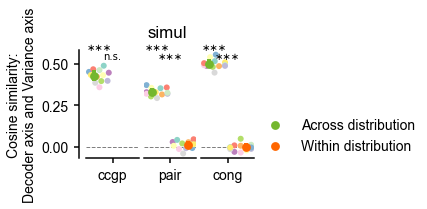

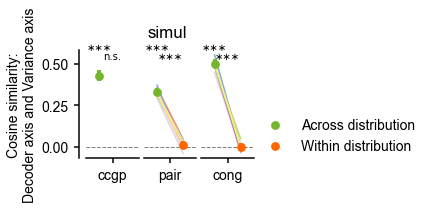

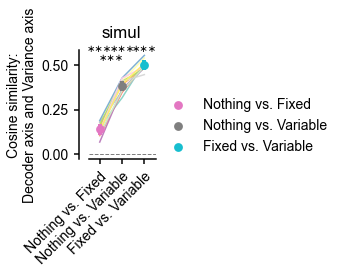

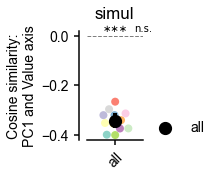

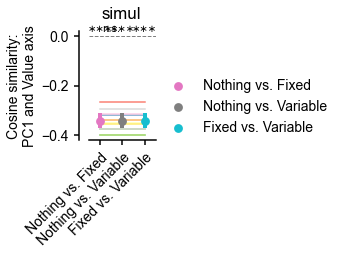

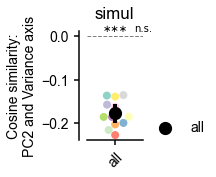

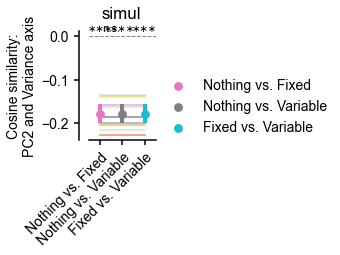

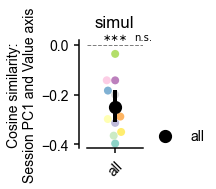

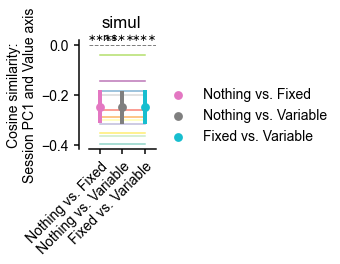

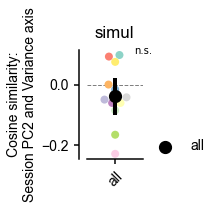

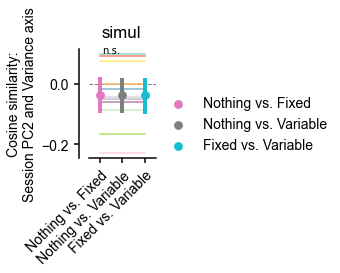

In [48]:
plot_decoder_angles(dec_dict['per'], control_df, angle_df, class_name, class_labels, rois, n_components,
                    mouse_colors=mouse_colors, dec_types=['simul'], savedir='behavioral_decoding')